In [1]:
import pandas as pd 
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from torch import nn 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset , DataLoader
from tensorflow import keras 
from scipy import stats
from sklearn.metrics import r2_score,mean_absolute_percentage_error, mean_absolute_error , mean_squared_error
import tensorflow as tf 
import joblib
import time
import itertools
from tqdm import tqdm 

In [2]:
tf.random.set_seed(42)

# About the Dataset

>## DATA HEADER INFO

### NASA/POWER CERES/MERRA2 Native Resolution Daily Data

**Dates (month/day/year): 01/01/1983 through 08/01/2023**

Location: Latitude 35.0382 Longitude 9.4849
Elevation from MERRA-2: Average for 0.5 x 0.625 degree lat/lon region = 408.34 meters
The value for missing source data that cannot be computed or is outside of the sources availability range: -

Parameter(s):

- ALLSKY_SFC_SW_DWN CERES SYN1deg - All Sky Surface Shortwave Downward Irradiance (kW-hr/m^2/day)

- ALLSKY_KT CERES SYN1deg - All Sky Insolation Clearness Index (dimensionless)

- ALLSKY_SFC_LW_DWN CERES SYN1deg - All Sky Surface Longwave Downward Irradiance (W/m^2)

- ALLSKY_SFC_PAR_TOT CERES SYN1deg - All Sky Surface PAR Total (W/m^2)

- CLRSKY_SFC_PAR_TOT CERES SYN1deg - Clear Sky Surface PAR Total (W/m^2)

- ALLSKY_SFC_UV_INDEX CERES SYN1deg - All Sky Surface UV Index (dimensionless)

- ALLSKY_SFC_UVA CERES SYN1deg - All Sky Surface UVA Irradiance (W/m^2)

- ALLSKY_SFC_UVB CERES SYN1deg - All Sky Surface UVB Irradiance (W/m^2)

- T2M MERRA-2 - Temperature at 2 Meters (C)

- T2MDEW MERRA-2 - Dew/Frost Point at 2 Meters (C)

- T2M_MAX MERRA-2 - Temperature at 2 Meters Maximum (C)

- T2M_MIN MERRA-2 - Temperature at 2 Meters Minimum (C)

- TS MERRA-2 - Earth Skin Temperature (C)

- WS10M MERRA-2 - Wind Speed at 10 Meters (m/s)

- WD10M MERRA-2 - Wind Direction at 10 Meters (Degrees)

- WS50M MERRA-2 - Wind Speed at 50 Meters (m/s)

- WD50M MERRA-2 - Wind Direction at 50 Meters (Degrees)

- PS MERRA-2 - Surface Pressure (kPa)

- PRECTOTCORR MERRA-2 - Precipitation Corrected (mm/day)

- RH2M MERRA-2 - Relative Humidity at 2 Meters (%)

# Data 

In [3]:
data = pd.read_csv("data/Tunisia Weather All Data.csv")
data.head(3)

,YEAR,MO,DY,ALLSKY_SFC_SW_DWN,ALLSKY_KT,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_PAR_TOT,CLRSKY_SFC_PAR_TOT,ALLSKY_SFC_UV_INDEX,ALLSKY_SFC_UVA,...,T2M_MAX,T2M_MIN,TS,WS10M,WD10M,WS50M,WD50M,PS,PRECTOTCORR,RH2M
0,1983,1,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,13.02,-0.81,4.48,2.43,263.62,3.73,265.12,98.23,0.11,70.38
1,1983,1,2,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,12.84,0.74,4.75,3.12,264.19,4.79,263.56,98.09,0.07,76.56
2,1983,1,3,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,11.65,0.27,4.99,3.73,212.50,6.01,212.62,98.47,0.16,84.56


In [4]:
data.isna().sum()

YEAR                   0
MO                     0
DY                     0
ALLSKY_SFC_SW_DWN      0
ALLSKY_KT              0
ALLSKY_SFC_LW_DWN      0
ALLSKY_SFC_PAR_TOT     0
CLRSKY_SFC_PAR_TOT     0
ALLSKY_SFC_UV_INDEX    0
ALLSKY_SFC_UVA         0
ALLSKY_SFC_UVB         0
T2M                    0
T2MDEW                 0
T2M_MAX                0
T2M_MIN                0
TS                     0
WS10M                  0
WD10M                  0
WS50M                  0
WD50M                  0
PS                     0
PRECTOTCORR            0
RH2M                   0
dtype: int64

In [5]:
data.duplicated().sum()

0

In [6]:
#create date format

In [7]:
date_column = []
for row in data.values:
    date = str(int(row[0])) + "-" +str(int(row[1])) +"-" + str(int(row[2]))
    date_column.append(date)
data["Date"] = date_column
data["Date"] = pd.to_datetime(data["Date"])


In [8]:
data.head(3)

,YEAR,MO,DY,ALLSKY_SFC_SW_DWN,ALLSKY_KT,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_PAR_TOT,CLRSKY_SFC_PAR_TOT,ALLSKY_SFC_UV_INDEX,ALLSKY_SFC_UVA,...,T2M_MIN,TS,WS10M,WD10M,WS50M,WD50M,PS,PRECTOTCORR,RH2M,Date
0,1983,1,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-0.81,4.48,2.43,263.62,3.73,265.12,98.23,0.11,70.38,1983-01-01
1,1983,1,2,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,0.74,4.75,3.12,264.19,4.79,263.56,98.09,0.07,76.56,1983-01-02
2,1983,1,3,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,0.27,4.99,3.73,212.50,6.01,212.62,98.47,0.16,84.56,1983-01-03


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14823 entries, 0 to 14822
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   YEAR                 14823 non-null  int64         
 1   MO                   14823 non-null  int64         
 2   DY                   14823 non-null  int64         
 3   ALLSKY_SFC_SW_DWN    14823 non-null  float64       
 4   ALLSKY_KT            14823 non-null  float64       
 5   ALLSKY_SFC_LW_DWN    14823 non-null  float64       
 6   ALLSKY_SFC_PAR_TOT   14823 non-null  float64       
 7   CLRSKY_SFC_PAR_TOT   14823 non-null  float64       
 8   ALLSKY_SFC_UV_INDEX  14823 non-null  float64       
 9   ALLSKY_SFC_UVA       14823 non-null  float64       
 10  ALLSKY_SFC_UVB       14823 non-null  float64       
 11  T2M                  14823 non-null  float64       
 12  T2MDEW               14823 non-null  float64       
 13  T2M_MAX              14823 non-

In [10]:
print(f"data size: {data.shape}")

data size: (14823, 24)


In [11]:
date_range = len(pd.date_range(data["Date"].min(), data["Date"].max()))
actual_data_range = data["Date"].nunique()
print(f"Expected range {date_range}") 
print(f"Our data range {actual_data_range}")

Expected range 14823
Our data range 14823


> **==>** there is no missing date

In [12]:
# take a subset from 2017 to 2013 
data2 = data[data["YEAR"] >= 2017]
print(f"data size: {data2.shape}")

data size: (2404, 24)


In [13]:
ts_data = data2[["Date","T2M"]]
ts_data = ts_data.set_index("Date")
ts_data.head()

,T2M
Date,
2017-01-01,5.45
2017-01-02,5.38
2017-01-03,7.26
2017-01-04,7.92
2017-01-05,8.33


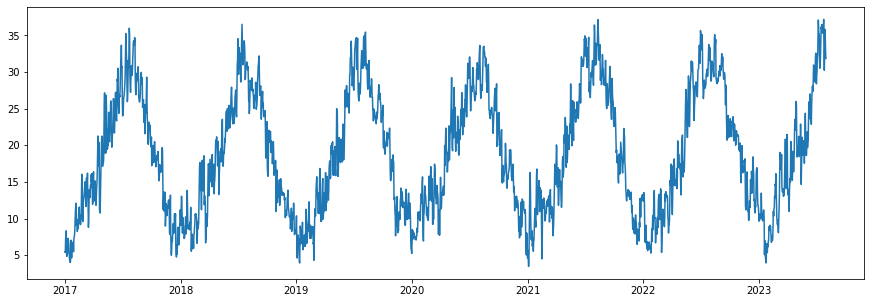

In [14]:
plt.figure(figsize=(15,5))
plt.plot(ts_data["T2M"])

# Trend & Seasonality

In [15]:
decompose = seasonal_decompose(ts_data[ts_data.columns[0]], model="multiplicative")

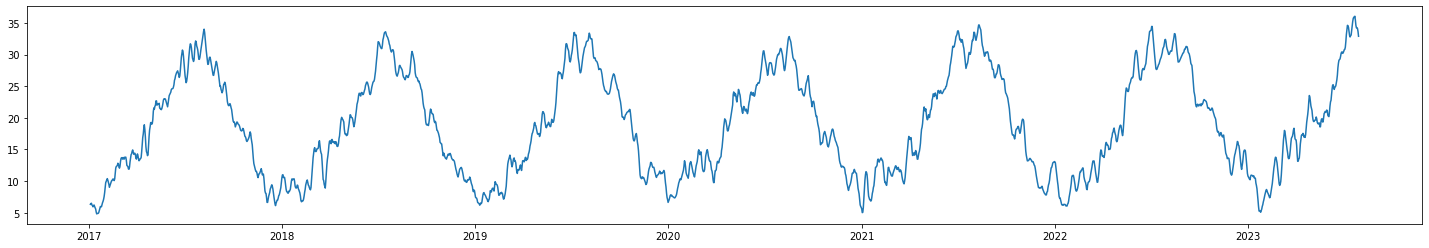

In [36]:
plt.figure(figsize=(25,4))
plt.plot(decompose.trend)

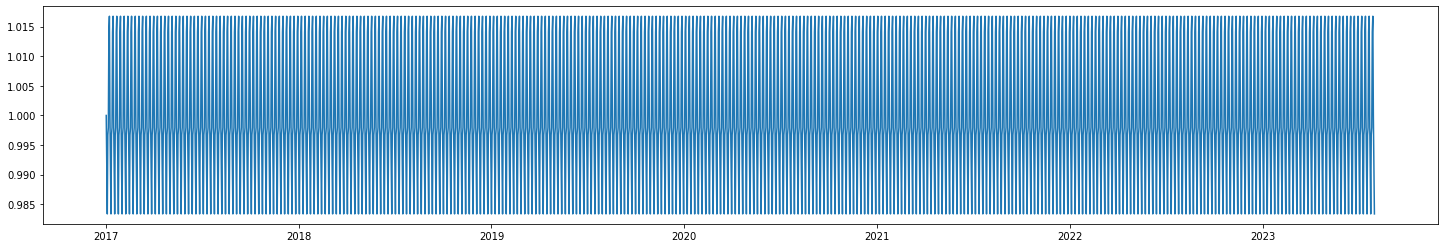

In [37]:
plt.figure(figsize=(25,4))
plt.plot(decompose.seasonal)

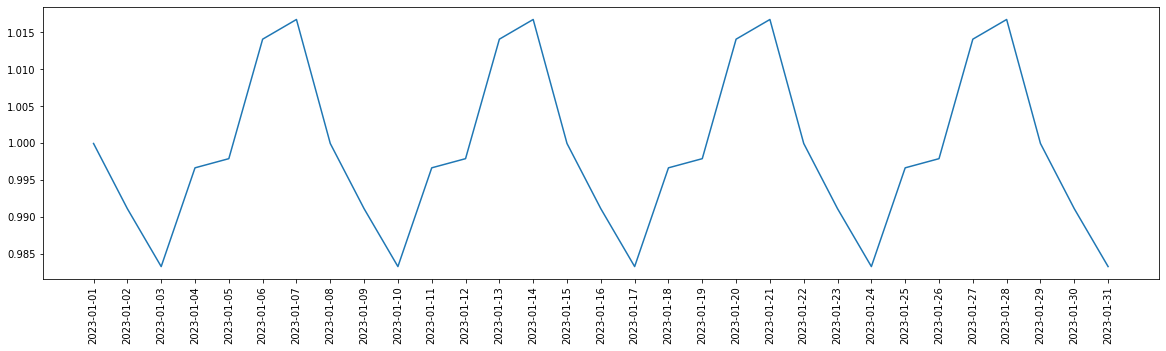

In [38]:
fig,axis = plt.subplots(figsize=(20,5))
axis.plot(decompose.seasonal["01-2023"])
axis.set_xticks(decompose.seasonal["01-2023"].index.date, decompose.seasonal["01-2023"].index.date, rotation = 90)


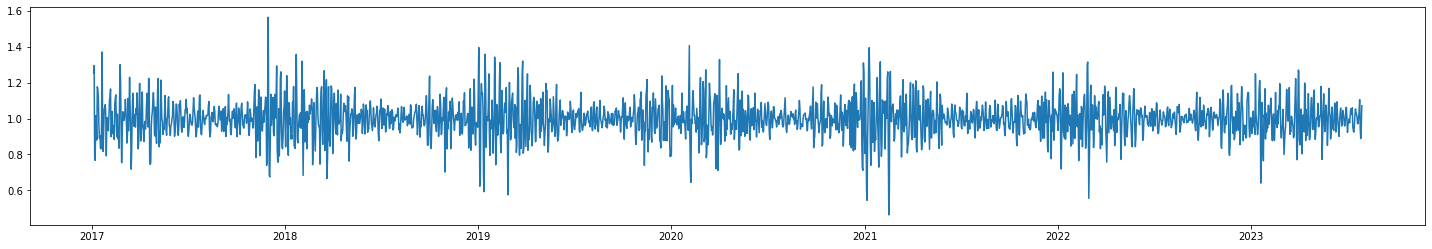

In [39]:
plt.figure(figsize=(25,4))
plt.plot(decompose.resid)

# Anomaly Detection

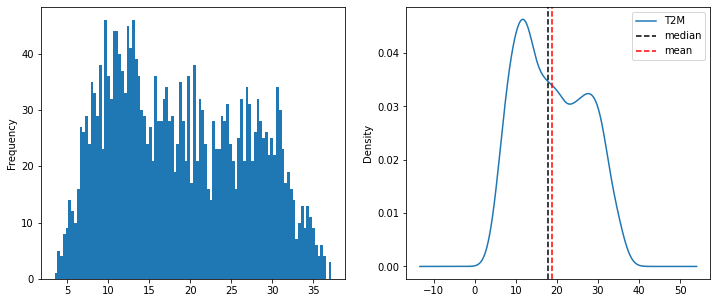

In [60]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
ts_data["T2M"].plot(kind="hist",bins=100)
plt.subplot(1,2,2 )
ts_data["T2M"].plot(kind="kde")
plt.axvline(ts_data["T2M"].median(), 0,1, c='black', ls='--',label="median")
plt.axvline(ts_data["T2M"].mean(), 0,1, c='red', ls='--',label="mean")
plt.legend()



> data is approximately normally distributed, thus we can try MAD method

In [61]:
ts_data["T2M"].mean(), ts_data["T2M"].median()

(18.79521214642263, 17.86)

## Median absolute deviation (MAD)

**conditions:**

>1 - the data is close to a normal distribution 

>2 - the MAD is not equal to 0 (happens when 50% of the data has the same value) 

In [62]:
from scipy.stats import median_abs_deviation

In [63]:
mad = median_abs_deviation(ts_data["T2M"])
median = ts_data["T2M"].median()

def robust_zscore(x):
    return 0.6745 * (x - median)/mad 

print(f"MAD = {mad}") 

MAD = 6.830000000000002


In [64]:
ts_data["Robust_Zscore"] = ts_data["T2M"].apply(robust_zscore)

In [65]:
ts_data.head()

,T2M,Robust_Zscore
Date,,
2017-01-01,5.45,-1.225556
2017-01-02,5.38,-1.232469
2017-01-03,7.26,-1.046808
2017-01-04,7.92,-0.981630
2017-01-05,8.33,-0.941140


In [66]:
#find the outlier (threshhold = 3)
ts_data["MAD_result"] = 1 

ts_data.loc[ts_data["Robust_Zscore"] > 3 ,"MAD_result"] = -1
ts_data.loc[ts_data["Robust_Zscore"] <= -3 ,"MAD_result"] = -1

In [67]:
print("Number of outliers: ",ts_data[ts_data["MAD_result"] == -1].shape[0])
print("Lowest zscore value:",ts_data["Robust_Zscore"].min())
print("Highest zscore value:",ts_data["Robust_Zscore"].max())

Number of outliers:  0
Lowest zscore value: -1.4210915080527082
Highest zscore value: 1.9079560761346994


## Isolation Forest

In [68]:
from sklearn.ensemble import IsolationForest

In [69]:
contamination = 1/ts_data["T2M"].shape[0]

#iso_forest = IsolationForest(contamination=0.5, random_state=42)
iso_forest = IsolationForest(random_state=42)

xtrain = ts_data["T2M"].values.reshape(-1,1)

iso_forest.fit(xtrain)

IsolationForest(random_state=42)

In [70]:
ts_data["IsolationForest_result"] = iso_forest.predict(xtrain)

In [71]:
print("Number of outliers:",ts_data[ts_data["IsolationForest_result"] != 1].shape[0])

Number of outliers: 888


In [72]:
ts_data.shape[0]

2404

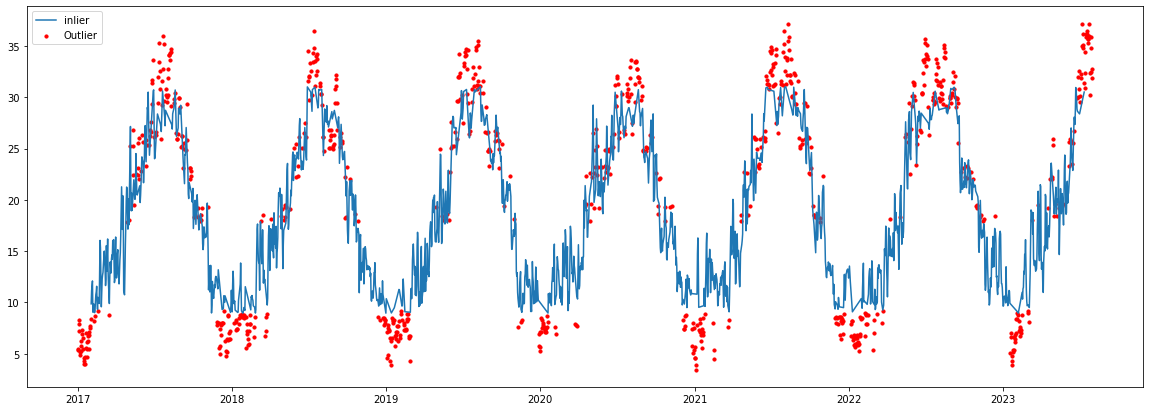

In [73]:
plt.figure(figsize=(20,7))
plt.plot(ts_data[ts_data["IsolationForest_result"] == 1]["T2M"],label="inlier")
plt.scatter(ts_data[ts_data["IsolationForest_result"] != 1].index,ts_data[ts_data["IsolationForest_result"] != 1]["T2M"],
            c="red",label="Outlier",s=10)
plt.legend()

##  Local Outlier Factor (LOF)

>**intuition :** compare the local density of a point to that of its neighbors, if the density is smaller , the the point is isolated , so it's an outlier 

> it is based on the metric "reachablity distance"

> - if LOF is close to 1 or smaller then it is an **inlier** 
> - if LOF is larger then 1, then it is an **outlier**

In [74]:
from sklearn.neighbors import LocalOutlierFactor

In [75]:
contamination = 1/ts_data["T2M"].shape[0]
lof = LocalOutlierFactor(contamination=contamination, novelty=True)

xtrain = ts_data["T2M"].values.reshape(-1,1)

lof.fit(xtrain)

LocalOutlierFactor(contamination=0.00041597337770382697, novelty=True)

In [76]:
preds = lof.predict(xtrain)
print("Number of outliers:",len(preds[preds != 1]))

Number of outliers: 0


## Data preparation for LSTM

In [62]:
batch_size = 32 
epochs = 100

In [78]:
# Split the data 

In [63]:
train_data = ts_data[["T2M"]].loc[:"2022"]
test_data = ts_data[["T2M"]].loc["2023":]
print(f"Size data train: {train_data.shape[0]}")
print(f"Size data test: {test_data.shape[0]}")

Size data train: 2191
Size data test: 213


In [64]:
#Data scaling 

In [65]:
scaler = StandardScaler()
train_data["T2M"] = scaler.fit_transform(train_data) 
test_data["T2M"] = scaler.transform(test_data) 



In [66]:
train_data.head()

,T2M
Date,
2017-01-01,-1.633474
2017-01-02,-1.642043
2017-01-03,-1.411899
2017-01-04,-1.331104
2017-01-05,-1.280913


In [67]:
def create_seq_dataset(x,time_steps=1):
    Xs,ys =  [],[]
    
    for i in range(len(x)-time_steps):
        Xs.append(x.iloc[i:i+time_steps].values)
        ys.append(x.iloc[i+time_steps].values)
    return np.array(Xs), np.array(ys)

In [68]:
def reverse_seq_exact(x,y):
    return x[0].reshape(-1,).tolist()  + y.reshape(-1,).tolist()

def reverse_seq(x):
    reversed_s = x[0].reshape(-1,).tolist() 
    for seq in x[1:]:
        reversed_s.append(seq[-1][0])
    return reversed_s
    

In [69]:
#based on the seasonality plot, there is a seasonal pattern that occure every 7 days
#also based on the data visualisation, we observe a seasonal patt.ern that occure each year (365 days)

In [70]:
TimeSteps = 7 
xtrain, ytrain= create_seq_dataset(train_data, time_steps= TimeSteps)
xtest, ytest= create_seq_dataset(test_data, time_steps= TimeSteps)

In [71]:
xtrain.shape , ytrain.shape

((2184, 7, 1), (2184, 1))

## LSTM Autoencoder

### Model training

In [88]:
model= keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(xtrain.shape[1],xtrain.shape[2])))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.RepeatVector(n= xtrain.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))

model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units= xtrain.shape[2])))

In [89]:
model.compile(loss="mse",optimizer="adam")

In [90]:
history = model.fit(
    xtrain,
    xtrain,
    epochs=epochs,
    batch_size= batch_size,
    validation_split= 0.1,
    shuffle=False
)

Epoch 1/100
62/62 [==============================] - 13s 57ms/step - loss: 0.3158 - val_loss: 0.1272
Epoch 2/100
62/62 [==============================] - 1s 23ms/step - loss: 0.0935 - val_loss: 0.0601
Epoch 3/100
62/62 [==============================] - 1s 23ms/step - loss: 0.0818 - val_loss: 0.0540
Epoch 4/100
62/62 [==============================] - 1s 21ms/step - loss: 0.0722 - val_loss: 0.0472
Epoch 5/100
62/62 [==============================] - 2s 28ms/step - loss: 0.0604 - val_loss: 0.0408
Epoch 6/100
62/62 [==============================] - 2s 26ms/step - loss: 0.0638 - val_loss: 0.1022
Epoch 7/100
62/62 [==============================] - 2s 24ms/step - loss: 0.1035 - val_loss: 0.0842
Epoch 8/100
62/62 [==============================] - 2s 28ms/step - loss: 0.0666 - val_loss: 0.0390
Epoch 9/100
62/62 [==============================] - 2s 27ms/step - loss: 0.0542 - val_loss: 0.0358
Epoch 10/100
62/62 [==============================] - 1s 23ms/step - loss: 0.0517 - val_loss: 0.033

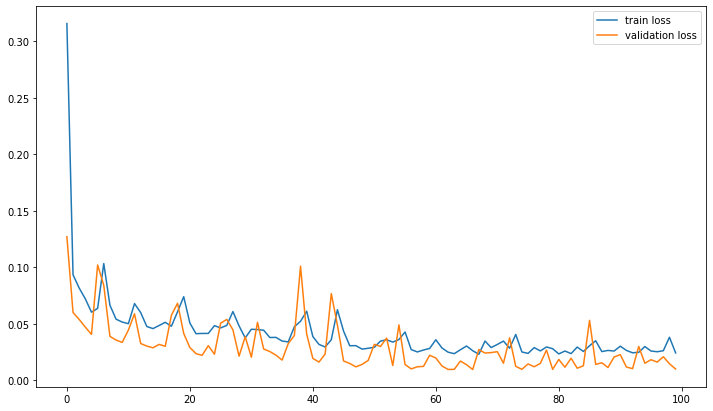

In [91]:
plt.figure(figsize=(12,7))
plt.plot(history.history["loss"],label="train loss")
plt.plot(history.history["val_loss"],label="validation loss")
plt.legend()

In [92]:
xtrain_preds = model.predict(xtrain)
train_mae_loss = np.mean(np.abs(xtrain - xtrain_preds),axis=1)

69/69 [==============================] - 3s 8ms/step


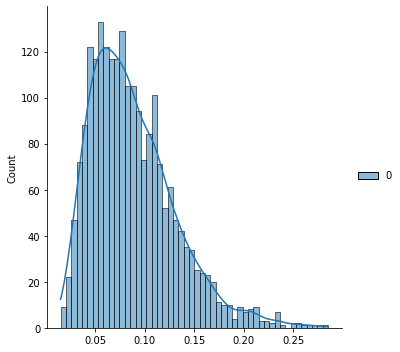

In [93]:
sns.displot(train_mae_loss,bins=50,kde=True)

In [94]:
reversed_seq_train = reverse_seq(xtrain)
reversed_seq_pred = reverse_seq(xtrain_preds)

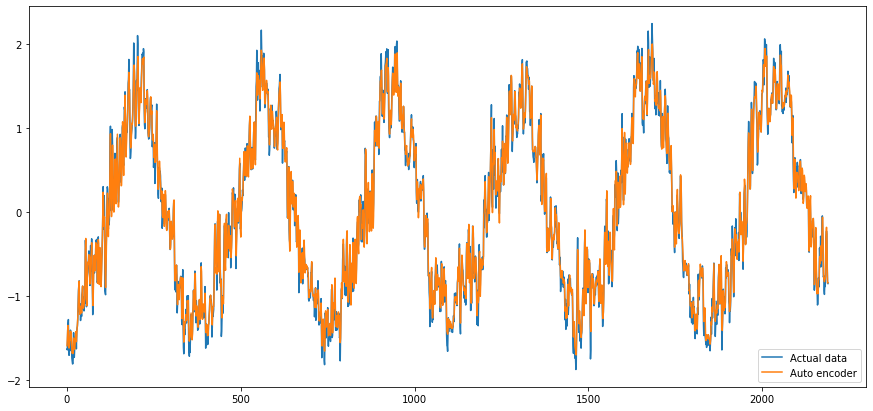

In [95]:
plt.figure(figsize=(15,7))

plt.plot(reversed_seq_train,label="Actual data")
plt.plot(reversed_seq_pred,label="Auto encoder")
plt.legend()

In [97]:
error = []
for i in range(len(reversed_seq_pred)):
    error.append(np.abs(reversed_seq_pred[i] - reversed_seq_train[i]))

(array([81., 87., 84., 90., 79., 89., 82., 81., 84., 87., 75., 68., 79.,
        66., 56., 53., 56., 51., 50., 48., 46., 43., 44., 38., 39., 34.,
        37., 36., 32., 39., 23., 21., 20., 18., 14., 12., 23., 17., 14.,
        24., 14., 10., 14., 10., 11., 11.,  9., 11.,  5.,  2.,  6.,  3.,
         6.,  8.,  5.,  4.,  2.,  3.,  3.,  4.,  2.,  0.,  3.,  0.,  2.,
         1.,  0.,  0.,  4.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  2.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  2.,  1.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.79604459e-05, 4.56441825e-03, 9.11087605e-03, 1.36573338e-02,
        1.82037916e-02, 2.27502494e-02, 2.72967072e-02, 3.18431650e-02,
        3.63896228e-02, 4.09360806e-02, 4.54825384e-02, 5.00289962e-02,
        5.45754540e-02, 5.91219118e-02, 6.36683696e-02, 6.82148274e-02,
        7.27612852e-02, 7.73077430e-02, 8.18542008e-02, 8.64006586e-02,
        9.09471164e-02, 9.54935742e-02, 1.00040032e-01, 1.04586490e-01,
  

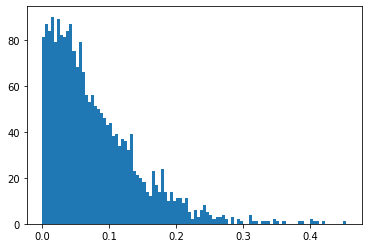

In [98]:
plt.hist(error,bins=100)

In [99]:
#Defining the threshhold for defining the anomalies 

In [100]:
upper_bound = np.quantile(error,0.95)
print("95% of errors are less than",upper_bound) 

95% of errors are less than 0.20474321596616896


In [101]:
anomalies = []
anomalies_idx = [] 
for i in range(len(reversed_seq_pred)):
    if np.abs(reversed_seq_pred[i] - reversed_seq_train[i]) > upper_bound:
        anomalies.append(reversed_seq_train[i])
        anomalies_idx.append(i)

In [102]:
data_real_values = pd.DataFrame({
    "Date":ts_data[:"30-12-2022"].index.tolist() 
}) 

In [103]:
#Get the real values 
real_value_train = scaler.inverse_transform(np.reshape(reversed_seq_train,(-1,1)))
real_value_pred = scaler.inverse_transform(np.reshape(reversed_seq_pred,(-1,1)))
real_value_anomalies = scaler.inverse_transform(np.reshape(anomalies,(-1,1)))

In [104]:
data_real_values["real_value_train"] =  real_value_train.reshape(-1,)
data_real_values["real_value_pred"] =  real_value_pred.reshape(-1,)
data_real_values["real_value_anomalies"] =  pd.Series(real_value_anomalies.reshape(-1,),index=anomalies_idx) 

In [105]:
ts_data[:"30-12-2022"].index.year

Index([2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
       ...
       2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022],
      dtype='int32', name='Date', length=2190)

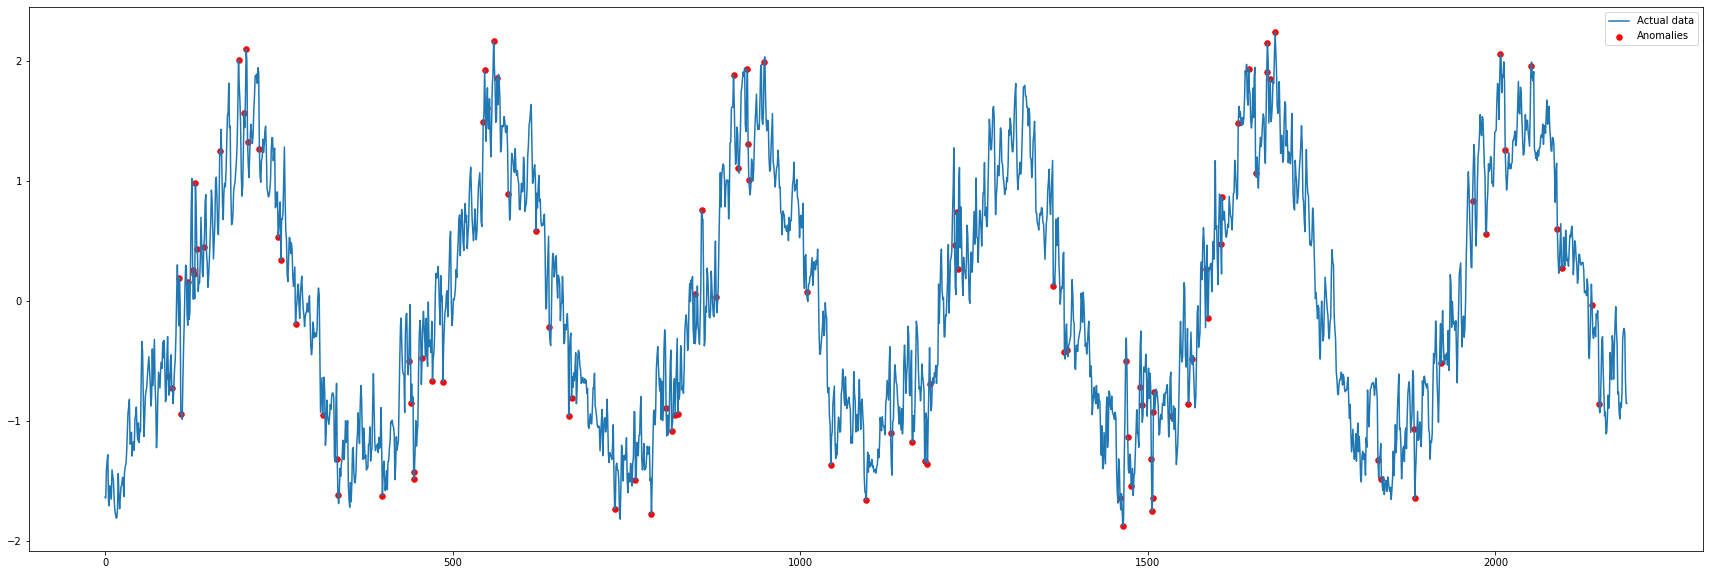

In [106]:
plt.figure(figsize=(30,10))

plt.plot(reversed_seq_train,label="Actual data")
plt.scatter(x=anomalies_idx, y=anomalies, c="red",label="Anomalies",s=30)
plt.legend()

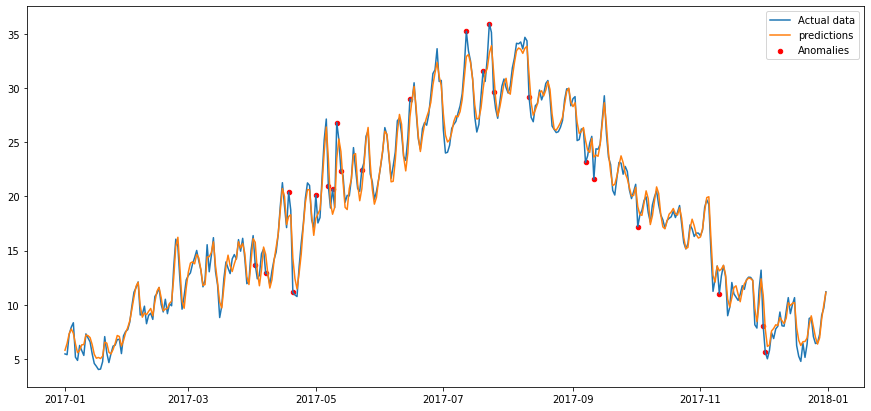

In [107]:
plt.figure(figsize=(15,7))

plt.plot(data_real_values.set_index("Date")["real_value_train"]["2017"],label="Actual data")
plt.plot(data_real_values.set_index("Date")["real_value_pred"]["2017"],label="predictions")

plt.scatter(x=data_real_values.set_index("Date").loc["2017"].index,
            y=data_real_values.set_index("Date")["real_value_anomalies"]["2017"], c="red",label="Anomalies",s=20)
plt.legend()

### Performance on testset 

In [108]:
def evaluation(y_pred,y):
    return pd.DataFrame({
        "R2_Score":[r2_score(y,y_pred)],
        "MAPE":[mean_absolute_percentage_error(y,y_pred)],
        "MAE":[mean_absolute_error(y,y_pred)],
        "MSE":[mean_squared_error(y,y_pred)]
    })

### Save the model

In [120]:
joblib.dump(model,"model/lstm_autoencoder.joblib")

['model/lstm_autoencoder.joblib']

# LSTM (Time series forecasting) 

## Train

In [109]:
model_lstm = keras.Sequential()
model_lstm.add(keras.layers.LSTM(units=64,input_shape=(xtrain.shape[1],xtrain.shape[2])))
model_lstm.add(keras.layers.Dropout(0.2))
model_lstm.add(keras.layers.Dense(1))

In [110]:
model_lstm.compile(loss="mse",optimizer="adam")

In [113]:
history = model_lstm.fit(
    xtrain,
    ytrain,
    epochs=500,
    batch_size= batch_size,
    validation_split= 0.1,
    shuffle=False
)

Epoch 1/500
62/62 [==============================] - 7s 34ms/step - loss: 0.3783 - val_loss: 0.0930
Epoch 2/500
62/62 [==============================] - 1s 12ms/step - loss: 0.1072 - val_loss: 0.0893
Epoch 3/500
62/62 [==============================] - 1s 19ms/step - loss: 0.1029 - val_loss: 0.0872
Epoch 4/500
62/62 [==============================] - 1s 17ms/step - loss: 0.0990 - val_loss: 0.0813
Epoch 5/500
62/62 [==============================] - 1s 18ms/step - loss: 0.0945 - val_loss: 0.0776
Epoch 6/500
62/62 [==============================] - 1s 18ms/step - loss: 0.0906 - val_loss: 0.0754
Epoch 7/500
62/62 [==============================] - 1s 18ms/step - loss: 0.0882 - val_loss: 0.0725
Epoch 8/500
62/62 [==============================] - 1s 15ms/step - loss: 0.0847 - val_loss: 0.0679
Epoch 9/500
62/62 [==============================] - 1s 16ms/step - loss: 0.0814 - val_loss: 0.0657
Epoch 10/500
62/62 [==============================] - 1s 17ms/step - loss: 0.0810 - val_loss: 0.0625

62/62 [==============================] - 1s 11ms/step - loss: 0.0466 - val_loss: 0.0296
Epoch 163/500
62/62 [==============================] - 1s 11ms/step - loss: 0.0470 - val_loss: 0.0296
Epoch 164/500
62/62 [==============================] - 1s 11ms/step - loss: 0.0468 - val_loss: 0.0305
Epoch 165/500
62/62 [==============================] - 1s 11ms/step - loss: 0.0458 - val_loss: 0.0300
Epoch 166/500
62/62 [==============================] - 1s 11ms/step - loss: 0.0482 - val_loss: 0.0294
Epoch 167/500
62/62 [==============================] - 1s 11ms/step - loss: 0.0466 - val_loss: 0.0297
Epoch 168/500
62/62 [==============================] - 1s 11ms/step - loss: 0.0475 - val_loss: 0.0322
Epoch 169/500
62/62 [==============================] - 1s 11ms/step - loss: 0.0472 - val_loss: 0.0299
Epoch 170/500
62/62 [==============================] - 1s 11ms/step - loss: 0.0466 - val_loss: 0.0293
Epoch 171/500
62/62 [==============================] - 1s 11ms/step - loss: 0.0472 - val_loss: 0

62/62 [==============================] - 1s 12ms/step - loss: 0.0467 - val_loss: 0.0305
Epoch 323/500
62/62 [==============================] - 1s 12ms/step - loss: 0.0465 - val_loss: 0.0295
Epoch 324/500
62/62 [==============================] - 1s 12ms/step - loss: 0.0451 - val_loss: 0.0296
Epoch 325/500
62/62 [==============================] - 1s 12ms/step - loss: 0.0459 - val_loss: 0.0311
Epoch 326/500
62/62 [==============================] - 1s 12ms/step - loss: 0.0460 - val_loss: 0.0298
Epoch 327/500
62/62 [==============================] - 1s 14ms/step - loss: 0.0475 - val_loss: 0.0295
Epoch 328/500
62/62 [==============================] - 1s 18ms/step - loss: 0.0459 - val_loss: 0.0295
Epoch 329/500
62/62 [==============================] - 1s 18ms/step - loss: 0.0466 - val_loss: 0.0299
Epoch 330/500
62/62 [==============================] - 1s 18ms/step - loss: 0.0457 - val_loss: 0.0298
Epoch 331/500
62/62 [==============================] - 1s 22ms/step - loss: 0.0461 - val_loss: 0

62/62 [==============================] - 1s 14ms/step - loss: 0.0444 - val_loss: 0.0304
Epoch 483/500
62/62 [==============================] - 1s 16ms/step - loss: 0.0458 - val_loss: 0.0298
Epoch 484/500
62/62 [==============================] - 1s 17ms/step - loss: 0.0459 - val_loss: 0.0296
Epoch 485/500
62/62 [==============================] - 1s 14ms/step - loss: 0.0445 - val_loss: 0.0299
Epoch 486/500
62/62 [==============================] - 1s 21ms/step - loss: 0.0459 - val_loss: 0.0298
Epoch 487/500
62/62 [==============================] - 1s 19ms/step - loss: 0.0455 - val_loss: 0.0299
Epoch 488/500
62/62 [==============================] - 1s 19ms/step - loss: 0.0463 - val_loss: 0.0314
Epoch 489/500
62/62 [==============================] - 1s 12ms/step - loss: 0.0457 - val_loss: 0.0298
Epoch 490/500
62/62 [==============================] - 1s 14ms/step - loss: 0.0458 - val_loss: 0.0308
Epoch 491/500
62/62 [==============================] - 1s 15ms/step - loss: 0.0448 - val_loss: 0

In [114]:
y_pred_lstm_train = model_lstm.predict(xtrain)
y_pred_lstm_test = model_lstm.predict(xtest)

7/7 [==============================] - 0s 7ms/step


## Evaluation 

In [115]:
evaluation(scaler.inverse_transform(ytrain),scaler.inverse_transform(y_pred_lstm_train)) 

,R2_Score,MAPE,MAE,MSE
0,0.95913,0.078995,1.230129,2.651635


In [116]:
evaluation(scaler.inverse_transform(ytest),scaler.inverse_transform(y_pred_lstm_test)) 

,R2_Score,MAPE,MAE,MSE
0,0.954557,0.087694,1.400412,3.258509


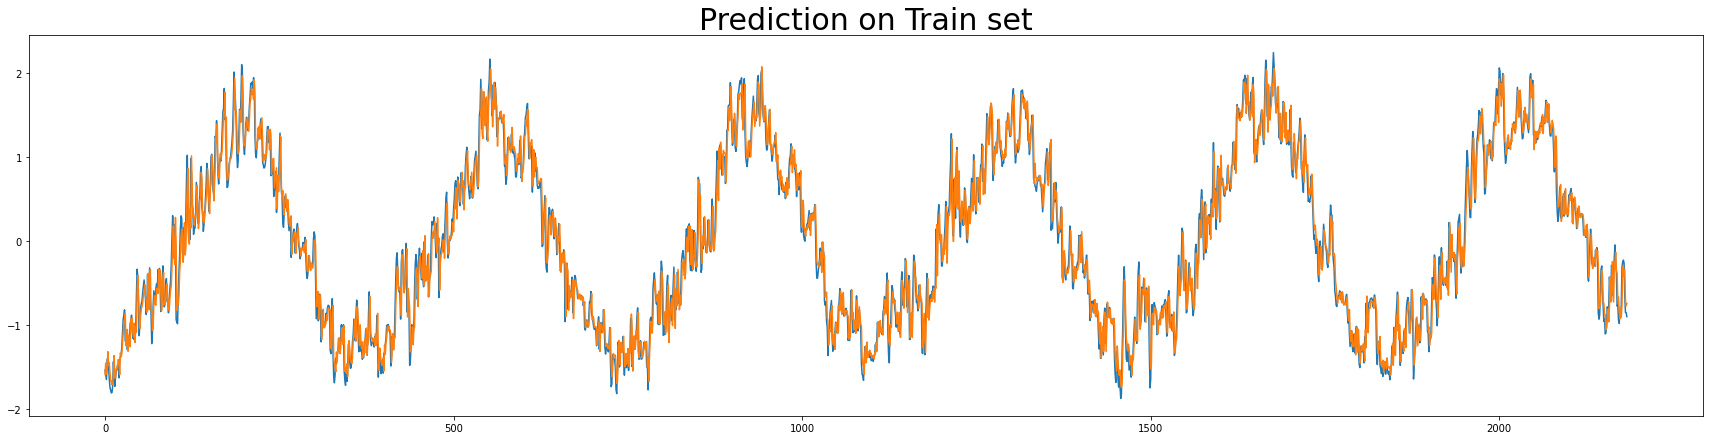

In [117]:
plt.figure(figsize=(30,7))

plt.title("Prediction on Train set",size=30)
plt.plot(ytrain,label="Actual train")
plt.plot(y_pred_lstm_train,label="Prediction")

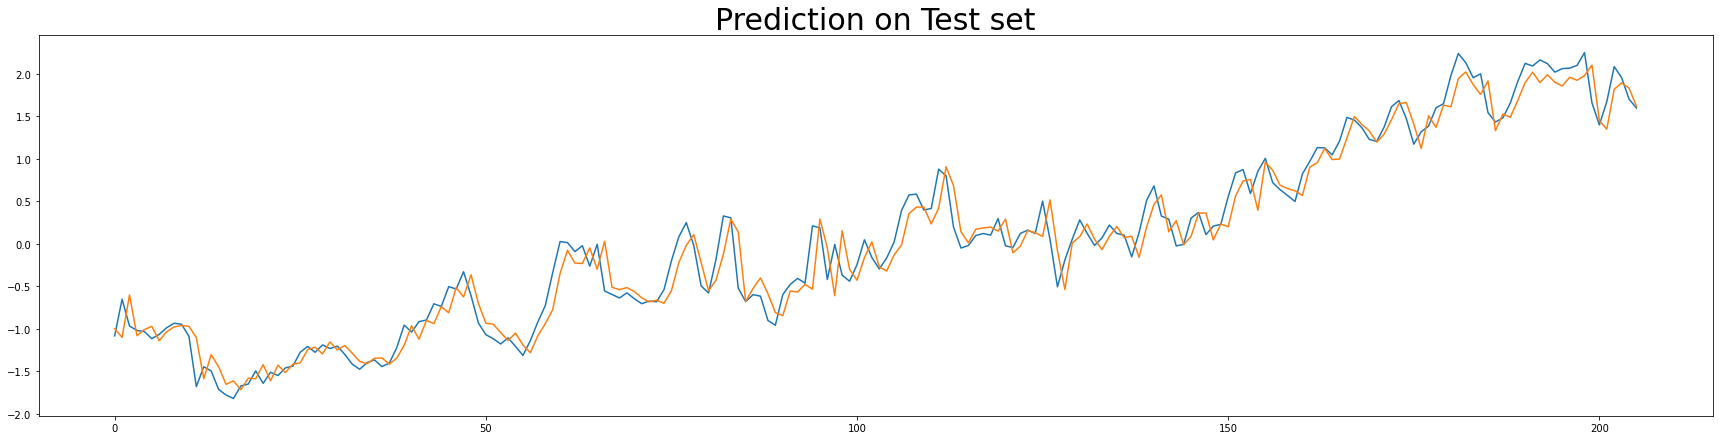

In [118]:
plt.figure(figsize=(30,7))

plt.title("Prediction on Test set",size=30)
plt.plot(ytest,label="Actual train")
plt.plot(y_pred_lstm_test,label="Prediction")

### Save the model

In [121]:
joblib.dump(model_lstm,"model/lstm_forecast.joblib")

['model/lstm_forecast.joblib']

# Prophet

In [16]:
from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

import holidays

## preparing features for prophet model

In [17]:
train_data = ts_data[["T2M"]].loc[:"2022"]
test_data = ts_data[["T2M"]].loc["2023":]
print(f"Size data train: {train_data.shape[0]}")
print(f"Size data test: {test_data.shape[0]}") 


Size data train: 2191
Size data test: 213


In [18]:
train_data = train_data.reset_index()
train_data.columns = ["ds","y"]
test_data = test_data.reset_index()
test_data.columns = ["ds","y"]

train_data.head()

,ds,y
0,2017-01-01,5.45
1,2017-01-02,5.38
2,2017-01-03,7.26
3,2017-01-04,7.92
4,2017-01-05,8.33


## Train model

In [99]:
#parameters 

In [19]:
changepoint_prior_scale  = np.linspace(0.001,0.5,5)
seasonality_prior_scale   = np.linspace(0.01,10,5)
seasonality_mode  = ['multiplicative']
changepoint_range  = np.linspace(0.5,0.95,5)

In [20]:
start_time = time.time()

#create params dictionnary  #GridSearch 
param_grid = {
    'changepoint_prior_scale':changepoint_prior_scale,
    'seasonality_prior_scale':seasonality_prior_scale,
    'changepoint_range':changepoint_range,
    'seasonality_mode':seasonality_mode
}

all_params = [dict(zip(param_grid.keys(), group)) for group in itertools.product(*param_grid.values())]

#list of all pd results 
all_results = []
#Gridsearch (train multiple models)
for param in tqdm(all_params):
    #fit the model
    model = Prophet(**param).fit(train_data)
    
    #apply cross validation 
    cv_data =  cross_validation(model, initial='365 days', period='30 days', horizon='30 days')
    #evaluate the model (calculate metrics)
    performance_data = performance_metrics(cv_data, rolling_window=1)
    
    all_results.append(performance_data)
        
print("--- %s seconds ---" % (time.time() - start_time))
print("--- %s minutes ---" % ((time.time() - start_time)/60))

  0%|                                                                                          | 0/125 [00:00<?, ?it/s]08:55:15 - cmdstanpy - INFO - Chain [1] start processing
08:55:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/60 [00:00<?, ?it/s]

08:55:17 - cmdstanpy - INFO - Chain [1] start processing
08:55:17 - cmdstanpy - INFO - Chain [1] done processing
08:55:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:55:17 - cmdstanpy - INFO - Chain [1] start processing
08:55:18 - cmdstanpy - INFO - Chain [1] done processing
08:55:18 - cmdstanpy - INFO - Chain [1] start processing
08:55:18 - cmdstanpy - INFO - Chain [1] done processing
08:55:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:55:18 - cmdstanpy - INFO - Chain [1] start processing
08:55:19 - cmdstanpy - INFO - Chain [1] done processing
08:55:20 - cmdstanpy - INFO - Chain [1] start processing
08:55:20 - cmdstanpy - INFO - Chain [1] done processing
08:55:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

08:56:09 - cmdstanpy - INFO - Chain [1] done processing
08:56:10 - cmdstanpy - INFO - Chain [1] start processing
08:56:10 - cmdstanpy - INFO - Chain [1] done processing
08:56:11 - cmdstanpy - INFO - Chain [1] start processing
08:56:11 - cmdstanpy - INFO - Chain [1] done processing
08:56:12 - cmdstanpy - INFO - Chain [1] start processing
08:56:12 - cmdstanpy - INFO - Chain [1] done processing
08:56:13 - cmdstanpy - INFO - Chain [1] start processing
08:56:13 - cmdstanpy - INFO - Chain [1] done processing
08:56:14 - cmdstanpy - INFO - Chain [1] start processing
08:56:14 - cmdstanpy - INFO - Chain [1] done processing
08:56:14 - cmdstanpy - INFO - Chain [1] start processing
08:56:15 - cmdstanpy - INFO - Chain [1] done processing
08:56:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:56:15 - cmdstanpy - INFO - Chain [1] start processing
08:56:17 - cmdstanpy - INFO - Chain [1] done processi

  0%|          | 0/60 [00:00<?, ?it/s]

08:56:56 - cmdstanpy - INFO - Chain [1] start processing
08:56:56 - cmdstanpy - INFO - Chain [1] done processing
08:56:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:56:56 - cmdstanpy - INFO - Chain [1] start processing
08:56:57 - cmdstanpy - INFO - Chain [1] done processing
08:56:57 - cmdstanpy - INFO - Chain [1] start processing
08:56:57 - cmdstanpy - INFO - Chain [1] done processing
08:56:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:56:57 - cmdstanpy - INFO - Chain [1] start processing
08:56:58 - cmdstanpy - INFO - Chain [1] done processing
08:56:59 - cmdstanpy - INFO - Chain [1] start processing
08:56:59 - cmdstanpy - INFO - Chain [1] done processing
08:56:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

08:57:45 - cmdstanpy - INFO - Chain [1] start processing
08:57:45 - cmdstanpy - INFO - Chain [1] done processing
08:57:46 - cmdstanpy - INFO - Chain [1] start processing
08:57:46 - cmdstanpy - INFO - Chain [1] done processing
08:57:47 - cmdstanpy - INFO - Chain [1] start processing
08:57:47 - cmdstanpy - INFO - Chain [1] done processing
08:57:48 - cmdstanpy - INFO - Chain [1] start processing
08:57:48 - cmdstanpy - INFO - Chain [1] done processing
08:57:48 - cmdstanpy - INFO - Chain [1] start processing
08:57:49 - cmdstanpy - INFO - Chain [1] done processing
08:57:49 - cmdstanpy - INFO - Chain [1] start processing
08:57:50 - cmdstanpy - INFO - Chain [1] done processing
08:57:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:57:50 - cmdstanpy - INFO - Chain [1] start processing
08:57:53 - cmdstanpy - INFO - Chain [1] done processing
08:57:54 - cmdstanpy - INFO - Chain [1] start process

  0%|          | 0/60 [00:00<?, ?it/s]

08:58:26 - cmdstanpy - INFO - Chain [1] start processing
08:58:26 - cmdstanpy - INFO - Chain [1] done processing
08:58:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:58:26 - cmdstanpy - INFO - Chain [1] start processing
08:58:27 - cmdstanpy - INFO - Chain [1] done processing
08:58:28 - cmdstanpy - INFO - Chain [1] start processing
08:58:28 - cmdstanpy - INFO - Chain [1] done processing
08:58:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:58:28 - cmdstanpy - INFO - Chain [1] start processing
08:58:29 - cmdstanpy - INFO - Chain [1] done processing
08:58:29 - cmdstanpy - INFO - Chain [1] start processing
08:58:30 - cmdstanpy - INFO - Chain [1] done processing
08:58:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

08:59:12 - cmdstanpy - INFO - Chain [1] done processing
08:59:13 - cmdstanpy - INFO - Chain [1] start processing
08:59:13 - cmdstanpy - INFO - Chain [1] done processing
08:59:13 - cmdstanpy - INFO - Chain [1] start processing
08:59:13 - cmdstanpy - INFO - Chain [1] done processing
08:59:14 - cmdstanpy - INFO - Chain [1] start processing
08:59:14 - cmdstanpy - INFO - Chain [1] done processing
08:59:14 - cmdstanpy - INFO - Chain [1] start processing
08:59:14 - cmdstanpy - INFO - Chain [1] done processing
08:59:15 - cmdstanpy - INFO - Chain [1] start processing
08:59:15 - cmdstanpy - INFO - Chain [1] done processing
08:59:15 - cmdstanpy - INFO - Chain [1] start processing
08:59:15 - cmdstanpy - INFO - Chain [1] done processing
08:59:15 - cmdstanpy - INFO - Chain [1] start processing
08:59:16 - cmdstanpy - INFO - Chain [1] done processing
08:59:16 - cmdstanpy - INFO - Chain [1] start processing
08:59:16 - cmdstanpy - INFO - Chain [1] done processing
08:59:16 - cmdstanpy - INFO - Chain [1] 

  0%|          | 0/60 [00:00<?, ?it/s]

08:59:27 - cmdstanpy - INFO - Chain [1] start processing
08:59:28 - cmdstanpy - INFO - Chain [1] done processing
08:59:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:59:28 - cmdstanpy - INFO - Chain [1] start processing
08:59:28 - cmdstanpy - INFO - Chain [1] done processing
08:59:29 - cmdstanpy - INFO - Chain [1] start processing
08:59:29 - cmdstanpy - INFO - Chain [1] done processing
08:59:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:59:29 - cmdstanpy - INFO - Chain [1] start processing
08:59:29 - cmdstanpy - INFO - Chain [1] done processing
08:59:29 - cmdstanpy - INFO - Chain [1] start processing
08:59:30 - cmdstanpy - INFO - Chain [1] done processing
08:59:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:00:04 - cmdstanpy - INFO - Chain [1] done processing
09:00:04 - cmdstanpy - INFO - Chain [1] start processing
09:00:04 - cmdstanpy - INFO - Chain [1] done processing
09:00:05 - cmdstanpy - INFO - Chain [1] start processing
09:00:05 - cmdstanpy - INFO - Chain [1] done processing
09:00:05 - cmdstanpy - INFO - Chain [1] start processing
09:00:05 - cmdstanpy - INFO - Chain [1] done processing
09:00:06 - cmdstanpy - INFO - Chain [1] start processing
09:00:06 - cmdstanpy - INFO - Chain [1] done processing
09:00:07 - cmdstanpy - INFO - Chain [1] start processing
09:00:07 - cmdstanpy - INFO - Chain [1] done processing
09:00:07 - cmdstanpy - INFO - Chain [1] start processing
09:00:07 - cmdstanpy - INFO - Chain [1] done processing
09:00:08 - cmdstanpy - INFO - Chain [1] start processing
09:00:08 - cmdstanpy - INFO - Chain [1] done processing
09:00:09 - cmdstanpy - INFO - Chain [1] start processing
09:00:09 - cmdstanpy - INFO - Chain [1] done processing
09:00:09 - cmdstanpy - INFO - Chain [1] 

  0%|          | 0/60 [00:00<?, ?it/s]

09:00:23 - cmdstanpy - INFO - Chain [1] start processing
09:00:23 - cmdstanpy - INFO - Chain [1] done processing
09:00:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:00:23 - cmdstanpy - INFO - Chain [1] start processing
09:00:24 - cmdstanpy - INFO - Chain [1] done processing
09:00:24 - cmdstanpy - INFO - Chain [1] start processing
09:00:24 - cmdstanpy - INFO - Chain [1] done processing
09:00:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:00:24 - cmdstanpy - INFO - Chain [1] start processing
09:00:25 - cmdstanpy - INFO - Chain [1] done processing
09:00:26 - cmdstanpy - INFO - Chain [1] start processing
09:00:26 - cmdstanpy - INFO - Chain [1] done processing
09:00:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:01:11 - cmdstanpy - INFO - Chain [1] start processing
09:01:11 - cmdstanpy - INFO - Chain [1] done processing
09:01:12 - cmdstanpy - INFO - Chain [1] start processing
09:01:12 - cmdstanpy - INFO - Chain [1] done processing
09:01:12 - cmdstanpy - INFO - Chain [1] start processing
09:01:12 - cmdstanpy - INFO - Chain [1] done processing
09:01:13 - cmdstanpy - INFO - Chain [1] start processing
09:01:13 - cmdstanpy - INFO - Chain [1] done processing
09:01:14 - cmdstanpy - INFO - Chain [1] start processing
09:01:14 - cmdstanpy - INFO - Chain [1] done processing
09:01:15 - cmdstanpy - INFO - Chain [1] start processing
09:01:15 - cmdstanpy - INFO - Chain [1] done processing
09:01:16 - cmdstanpy - INFO - Chain [1] start processing
09:01:16 - cmdstanpy - INFO - Chain [1] done processing
09:01:17 - cmdstanpy - INFO - Chain [1] start processing
09:01:17 - cmdstanpy - INFO - Chain [1] done processing
09:01:18 - cmdstanpy - INFO - Chain [1] start processing
09:01:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:01:27 - cmdstanpy - INFO - Chain [1] start processing
09:01:27 - cmdstanpy - INFO - Chain [1] done processing
09:01:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:01:28 - cmdstanpy - INFO - Chain [1] start processing
09:01:29 - cmdstanpy - INFO - Chain [1] done processing
09:01:29 - cmdstanpy - INFO - Chain [1] start processing
09:01:29 - cmdstanpy - INFO - Chain [1] done processing
09:01:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:01:29 - cmdstanpy - INFO - Chain [1] start processing
09:01:30 - cmdstanpy - INFO - Chain [1] done processing
09:01:31 - cmdstanpy - INFO - Chain [1] start processing
09:01:31 - cmdstanpy - INFO - Chain [1] done processing
09:01:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:02:15 - cmdstanpy - INFO - Chain [1] done processing
09:02:16 - cmdstanpy - INFO - Chain [1] start processing
09:02:16 - cmdstanpy - INFO - Chain [1] done processing
09:02:16 - cmdstanpy - INFO - Chain [1] start processing
09:02:16 - cmdstanpy - INFO - Chain [1] done processing
09:02:17 - cmdstanpy - INFO - Chain [1] start processing
09:02:17 - cmdstanpy - INFO - Chain [1] done processing
09:02:17 - cmdstanpy - INFO - Chain [1] start processing
09:02:17 - cmdstanpy - INFO - Chain [1] done processing
09:02:18 - cmdstanpy - INFO - Chain [1] start processing
09:02:18 - cmdstanpy - INFO - Chain [1] done processing
09:02:18 - cmdstanpy - INFO - Chain [1] start processing
09:02:18 - cmdstanpy - INFO - Chain [1] done processing
09:02:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:02:18 - cmdstanpy - INFO - Chain [1] start processing
09:02:24 - cmdstanpy - INFO - Chain [1] done processi

  0%|          | 0/60 [00:00<?, ?it/s]

09:02:46 - cmdstanpy - INFO - Chain [1] start processing
09:02:46 - cmdstanpy - INFO - Chain [1] done processing
09:02:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:02:46 - cmdstanpy - INFO - Chain [1] start processing
09:02:47 - cmdstanpy - INFO - Chain [1] done processing
09:02:47 - cmdstanpy - INFO - Chain [1] start processing
09:02:47 - cmdstanpy - INFO - Chain [1] done processing
09:02:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:02:47 - cmdstanpy - INFO - Chain [1] start processing
09:02:48 - cmdstanpy - INFO - Chain [1] done processing
09:02:48 - cmdstanpy - INFO - Chain [1] start processing
09:02:48 - cmdstanpy - INFO - Chain [1] done processing
09:02:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:03:25 - cmdstanpy - INFO - Chain [1] start processing
09:03:25 - cmdstanpy - INFO - Chain [1] done processing
09:03:26 - cmdstanpy - INFO - Chain [1] start processing
09:03:26 - cmdstanpy - INFO - Chain [1] done processing
09:03:26 - cmdstanpy - INFO - Chain [1] start processing
09:03:26 - cmdstanpy - INFO - Chain [1] done processing
09:03:27 - cmdstanpy - INFO - Chain [1] start processing
09:03:27 - cmdstanpy - INFO - Chain [1] done processing
09:03:27 - cmdstanpy - INFO - Chain [1] start processing
09:03:27 - cmdstanpy - INFO - Chain [1] done processing
09:03:28 - cmdstanpy - INFO - Chain [1] start processing
09:03:28 - cmdstanpy - INFO - Chain [1] done processing
09:03:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:03:28 - cmdstanpy - INFO - Chain [1] start processing
09:03:29 - cmdstanpy - INFO - Chain [1] done processing
09:03:30 - cmdstanpy - INFO - Chain [1] start process

  0%|          | 0/60 [00:00<?, ?it/s]

09:03:48 - cmdstanpy - INFO - Chain [1] start processing
09:03:48 - cmdstanpy - INFO - Chain [1] done processing
09:03:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:03:48 - cmdstanpy - INFO - Chain [1] start processing
09:03:49 - cmdstanpy - INFO - Chain [1] done processing
09:03:50 - cmdstanpy - INFO - Chain [1] start processing
09:03:50 - cmdstanpy - INFO - Chain [1] done processing
09:03:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:03:50 - cmdstanpy - INFO - Chain [1] start processing
09:03:52 - cmdstanpy - INFO - Chain [1] done processing
09:03:52 - cmdstanpy - INFO - Chain [1] start processing
09:03:52 - cmdstanpy - INFO - Chain [1] done processing
09:03:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:04:26 - cmdstanpy - INFO - Chain [1] done processing
09:04:27 - cmdstanpy - INFO - Chain [1] start processing
09:04:27 - cmdstanpy - INFO - Chain [1] done processing
09:04:27 - cmdstanpy - INFO - Chain [1] start processing
09:04:27 - cmdstanpy - INFO - Chain [1] done processing
09:04:28 - cmdstanpy - INFO - Chain [1] start processing
09:04:28 - cmdstanpy - INFO - Chain [1] done processing
09:04:28 - cmdstanpy - INFO - Chain [1] start processing
09:04:28 - cmdstanpy - INFO - Chain [1] done processing
09:04:29 - cmdstanpy - INFO - Chain [1] start processing
09:04:29 - cmdstanpy - INFO - Chain [1] done processing
09:04:29 - cmdstanpy - INFO - Chain [1] start processing
09:04:29 - cmdstanpy - INFO - Chain [1] done processing
09:04:30 - cmdstanpy - INFO - Chain [1] start processing
09:04:30 - cmdstanpy - INFO - Chain [1] done processing
09:04:30 - cmdstanpy - INFO - Chain [1] start processing
09:04:30 - cmdstanpy - INFO - Chain [1] done processing
09:04:31 - cmdstanpy - INFO - Chain [1] 

  0%|          | 0/60 [00:00<?, ?it/s]

09:04:42 - cmdstanpy - INFO - Chain [1] start processing
09:04:42 - cmdstanpy - INFO - Chain [1] done processing
09:04:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:04:42 - cmdstanpy - INFO - Chain [1] start processing
09:04:42 - cmdstanpy - INFO - Chain [1] done processing
09:04:43 - cmdstanpy - INFO - Chain [1] start processing
09:04:43 - cmdstanpy - INFO - Chain [1] done processing
09:04:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:04:43 - cmdstanpy - INFO - Chain [1] start processing
09:04:43 - cmdstanpy - INFO - Chain [1] done processing
09:04:44 - cmdstanpy - INFO - Chain [1] start processing
09:04:44 - cmdstanpy - INFO - Chain [1] done processing
09:04:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:05:16 - cmdstanpy - INFO - Chain [1] done processing
09:05:17 - cmdstanpy - INFO - Chain [1] start processing
09:05:17 - cmdstanpy - INFO - Chain [1] done processing
09:05:17 - cmdstanpy - INFO - Chain [1] start processing
09:05:17 - cmdstanpy - INFO - Chain [1] done processing
09:05:18 - cmdstanpy - INFO - Chain [1] start processing
09:05:18 - cmdstanpy - INFO - Chain [1] done processing
09:05:18 - cmdstanpy - INFO - Chain [1] start processing
09:05:18 - cmdstanpy - INFO - Chain [1] done processing
09:05:19 - cmdstanpy - INFO - Chain [1] start processing
09:05:19 - cmdstanpy - INFO - Chain [1] done processing
09:05:19 - cmdstanpy - INFO - Chain [1] start processing
09:05:19 - cmdstanpy - INFO - Chain [1] done processing
09:05:20 - cmdstanpy - INFO - Chain [1] start processing
09:05:20 - cmdstanpy - INFO - Chain [1] done processing
09:05:20 - cmdstanpy - INFO - Chain [1] start processing
09:05:20 - cmdstanpy - INFO - Chain [1] done processing
09:05:21 - cmdstanpy - INFO - Chain [1] 

  0%|          | 0/60 [00:00<?, ?it/s]

09:05:31 - cmdstanpy - INFO - Chain [1] start processing
09:05:31 - cmdstanpy - INFO - Chain [1] done processing
09:05:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:05:31 - cmdstanpy - INFO - Chain [1] start processing
09:05:32 - cmdstanpy - INFO - Chain [1] done processing
09:05:33 - cmdstanpy - INFO - Chain [1] start processing
09:05:33 - cmdstanpy - INFO - Chain [1] done processing
09:05:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:05:33 - cmdstanpy - INFO - Chain [1] start processing
09:05:36 - cmdstanpy - INFO - Chain [1] done processing
09:05:36 - cmdstanpy - INFO - Chain [1] start processing
09:05:36 - cmdstanpy - INFO - Chain [1] done processing
09:05:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:06:14 - cmdstanpy - INFO - Chain [1] start processing
09:06:14 - cmdstanpy - INFO - Chain [1] done processing
09:06:14 - cmdstanpy - INFO - Chain [1] start processing
09:06:14 - cmdstanpy - INFO - Chain [1] done processing
09:06:15 - cmdstanpy - INFO - Chain [1] start processing
09:06:15 - cmdstanpy - INFO - Chain [1] done processing
09:06:15 - cmdstanpy - INFO - Chain [1] start processing
09:06:15 - cmdstanpy - INFO - Chain [1] done processing
09:06:16 - cmdstanpy - INFO - Chain [1] start processing
09:06:16 - cmdstanpy - INFO - Chain [1] done processing
09:06:16 - cmdstanpy - INFO - Chain [1] start processing
09:06:16 - cmdstanpy - INFO - Chain [1] done processing
09:06:17 - cmdstanpy - INFO - Chain [1] start processing
09:06:17 - cmdstanpy - INFO - Chain [1] done processing
09:06:17 - cmdstanpy - INFO - Chain [1] start processing
09:06:17 - cmdstanpy - INFO - Chain [1] done processing
09:06:18 - cmdstanpy - INFO - Chain [1] start processing
09:06:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:06:24 - cmdstanpy - INFO - Chain [1] start processing
09:06:24 - cmdstanpy - INFO - Chain [1] done processing
09:06:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:06:24 - cmdstanpy - INFO - Chain [1] start processing
09:06:32 - cmdstanpy - INFO - Chain [1] done processing
09:06:32 - cmdstanpy - INFO - Chain [1] start processing
09:06:32 - cmdstanpy - INFO - Chain [1] done processing
09:06:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:06:32 - cmdstanpy - INFO - Chain [1] start processing
09:06:33 - cmdstanpy - INFO - Chain [1] done processing
09:06:33 - cmdstanpy - INFO - Chain [1] start processing
09:06:33 - cmdstanpy - INFO - Chain [1] done processing
09:06:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:07:10 - cmdstanpy - INFO - Chain [1] done processing
09:07:10 - cmdstanpy - INFO - Chain [1] start processing
09:07:10 - cmdstanpy - INFO - Chain [1] done processing
09:07:11 - cmdstanpy - INFO - Chain [1] start processing
09:07:11 - cmdstanpy - INFO - Chain [1] done processing
09:07:12 - cmdstanpy - INFO - Chain [1] start processing
09:07:12 - cmdstanpy - INFO - Chain [1] done processing
09:07:12 - cmdstanpy - INFO - Chain [1] start processing
09:07:12 - cmdstanpy - INFO - Chain [1] done processing
09:07:13 - cmdstanpy - INFO - Chain [1] start processing
09:07:13 - cmdstanpy - INFO - Chain [1] done processing
09:07:13 - cmdstanpy - INFO - Chain [1] start processing
09:07:13 - cmdstanpy - INFO - Chain [1] done processing
09:07:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:07:13 - cmdstanpy - INFO - Chain [1] start processing
09:07:17 - cmdstanpy - INFO - Chain [1] done processi

  0%|          | 0/60 [00:00<?, ?it/s]

09:07:39 - cmdstanpy - INFO - Chain [1] start processing
09:07:39 - cmdstanpy - INFO - Chain [1] done processing
09:07:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:07:39 - cmdstanpy - INFO - Chain [1] start processing
09:07:39 - cmdstanpy - INFO - Chain [1] done processing
09:07:40 - cmdstanpy - INFO - Chain [1] start processing
09:07:40 - cmdstanpy - INFO - Chain [1] done processing
09:07:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:07:40 - cmdstanpy - INFO - Chain [1] start processing
09:07:40 - cmdstanpy - INFO - Chain [1] done processing
09:07:41 - cmdstanpy - INFO - Chain [1] start processing
09:07:41 - cmdstanpy - INFO - Chain [1] done processing
09:07:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:08:14 - cmdstanpy - INFO - Chain [1] start processing
09:08:14 - cmdstanpy - INFO - Chain [1] done processing
09:08:15 - cmdstanpy - INFO - Chain [1] start processing
09:08:15 - cmdstanpy - INFO - Chain [1] done processing
09:08:15 - cmdstanpy - INFO - Chain [1] start processing
09:08:15 - cmdstanpy - INFO - Chain [1] done processing
09:08:15 - cmdstanpy - INFO - Chain [1] start processing
09:08:16 - cmdstanpy - INFO - Chain [1] done processing
09:08:16 - cmdstanpy - INFO - Chain [1] start processing
09:08:16 - cmdstanpy - INFO - Chain [1] done processing
09:08:16 - cmdstanpy - INFO - Chain [1] start processing
09:08:17 - cmdstanpy - INFO - Chain [1] done processing
09:08:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:08:17 - cmdstanpy - INFO - Chain [1] start processing
09:08:18 - cmdstanpy - INFO - Chain [1] done processing
09:08:19 - cmdstanpy - INFO - Chain [1] start process

  0%|          | 0/60 [00:00<?, ?it/s]

09:08:37 - cmdstanpy - INFO - Chain [1] start processing
09:08:37 - cmdstanpy - INFO - Chain [1] done processing
09:08:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:08:38 - cmdstanpy - INFO - Chain [1] start processing
09:08:38 - cmdstanpy - INFO - Chain [1] done processing
09:08:38 - cmdstanpy - INFO - Chain [1] start processing
09:08:38 - cmdstanpy - INFO - Chain [1] done processing
09:08:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:08:38 - cmdstanpy - INFO - Chain [1] start processing
09:08:39 - cmdstanpy - INFO - Chain [1] done processing
09:08:40 - cmdstanpy - INFO - Chain [1] start processing
09:08:40 - cmdstanpy - INFO - Chain [1] done processing
09:08:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:09:17 - cmdstanpy - INFO - Chain [1] done processing
09:09:17 - cmdstanpy - INFO - Chain [1] start processing
09:09:17 - cmdstanpy - INFO - Chain [1] done processing
09:09:18 - cmdstanpy - INFO - Chain [1] start processing
09:09:18 - cmdstanpy - INFO - Chain [1] done processing
09:09:18 - cmdstanpy - INFO - Chain [1] start processing
09:09:18 - cmdstanpy - INFO - Chain [1] done processing
09:09:19 - cmdstanpy - INFO - Chain [1] start processing
09:09:19 - cmdstanpy - INFO - Chain [1] done processing
09:09:19 - cmdstanpy - INFO - Chain [1] start processing
09:09:19 - cmdstanpy - INFO - Chain [1] done processing
09:09:20 - cmdstanpy - INFO - Chain [1] start processing
09:09:20 - cmdstanpy - INFO - Chain [1] done processing
09:09:20 - cmdstanpy - INFO - Chain [1] start processing
09:09:20 - cmdstanpy - INFO - Chain [1] done processing
09:09:21 - cmdstanpy - INFO - Chain [1] start processing
09:09:21 - cmdstanpy - INFO - Chain [1] done processing
09:09:21 - cmdstanpy - INFO - Chain [1] 

  0%|          | 0/60 [00:00<?, ?it/s]

09:09:32 - cmdstanpy - INFO - Chain [1] start processing
09:09:32 - cmdstanpy - INFO - Chain [1] done processing
09:09:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:09:32 - cmdstanpy - INFO - Chain [1] start processing
09:09:33 - cmdstanpy - INFO - Chain [1] done processing
09:09:33 - cmdstanpy - INFO - Chain [1] start processing
09:09:33 - cmdstanpy - INFO - Chain [1] done processing
09:09:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:09:33 - cmdstanpy - INFO - Chain [1] start processing
09:09:34 - cmdstanpy - INFO - Chain [1] done processing
09:09:34 - cmdstanpy - INFO - Chain [1] start processing
09:09:34 - cmdstanpy - INFO - Chain [1] done processing
09:09:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:10:09 - cmdstanpy - INFO - Chain [1] done processing
09:10:10 - cmdstanpy - INFO - Chain [1] start processing
09:10:10 - cmdstanpy - INFO - Chain [1] done processing
09:10:10 - cmdstanpy - INFO - Chain [1] start processing
09:10:10 - cmdstanpy - INFO - Chain [1] done processing
09:10:11 - cmdstanpy - INFO - Chain [1] start processing
09:10:11 - cmdstanpy - INFO - Chain [1] done processing
09:10:11 - cmdstanpy - INFO - Chain [1] start processing
09:10:11 - cmdstanpy - INFO - Chain [1] done processing
09:10:12 - cmdstanpy - INFO - Chain [1] start processing
09:10:12 - cmdstanpy - INFO - Chain [1] done processing
09:10:12 - cmdstanpy - INFO - Chain [1] start processing
09:10:12 - cmdstanpy - INFO - Chain [1] done processing
09:10:13 - cmdstanpy - INFO - Chain [1] start processing
09:10:13 - cmdstanpy - INFO - Chain [1] done processing
09:10:13 - cmdstanpy - INFO - Chain [1] start processing
09:10:13 - cmdstanpy - INFO - Chain [1] done processing
09:10:14 - cmdstanpy - INFO - Chain [1] 

  0%|          | 0/60 [00:00<?, ?it/s]

09:10:24 - cmdstanpy - INFO - Chain [1] start processing
09:10:24 - cmdstanpy - INFO - Chain [1] done processing
09:10:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:10:24 - cmdstanpy - INFO - Chain [1] start processing
09:10:24 - cmdstanpy - INFO - Chain [1] done processing
09:10:24 - cmdstanpy - INFO - Chain [1] start processing
09:10:25 - cmdstanpy - INFO - Chain [1] done processing
09:10:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:10:25 - cmdstanpy - INFO - Chain [1] start processing
09:10:25 - cmdstanpy - INFO - Chain [1] done processing
09:10:26 - cmdstanpy - INFO - Chain [1] start processing
09:10:26 - cmdstanpy - INFO - Chain [1] done processing
09:10:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:11:01 - cmdstanpy - INFO - Chain [1] start processing
09:11:01 - cmdstanpy - INFO - Chain [1] done processing
09:11:01 - cmdstanpy - INFO - Chain [1] start processing
09:11:01 - cmdstanpy - INFO - Chain [1] done processing
09:11:02 - cmdstanpy - INFO - Chain [1] start processing
09:11:02 - cmdstanpy - INFO - Chain [1] done processing
09:11:02 - cmdstanpy - INFO - Chain [1] start processing
09:11:03 - cmdstanpy - INFO - Chain [1] done processing
09:11:03 - cmdstanpy - INFO - Chain [1] start processing
09:11:03 - cmdstanpy - INFO - Chain [1] done processing
09:11:03 - cmdstanpy - INFO - Chain [1] start processing
09:11:03 - cmdstanpy - INFO - Chain [1] done processing
09:11:04 - cmdstanpy - INFO - Chain [1] start processing
09:11:04 - cmdstanpy - INFO - Chain [1] done processing
09:11:04 - cmdstanpy - INFO - Chain [1] start processing
09:11:05 - cmdstanpy - INFO - Chain [1] done processing
09:11:05 - cmdstanpy - INFO - Chain [1] start processing
09:11:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:11:11 - cmdstanpy - INFO - Chain [1] start processing
09:11:11 - cmdstanpy - INFO - Chain [1] done processing
09:11:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:11:11 - cmdstanpy - INFO - Chain [1] start processing
09:11:12 - cmdstanpy - INFO - Chain [1] done processing
09:11:12 - cmdstanpy - INFO - Chain [1] start processing
09:11:12 - cmdstanpy - INFO - Chain [1] done processing
09:11:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:11:12 - cmdstanpy - INFO - Chain [1] start processing
09:11:13 - cmdstanpy - INFO - Chain [1] done processing
09:11:13 - cmdstanpy - INFO - Chain [1] start processing
09:11:13 - cmdstanpy - INFO - Chain [1] done processing
09:11:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:11:49 - cmdstanpy - INFO - Chain [1] done processing
09:11:49 - cmdstanpy - INFO - Chain [1] start processing
09:11:49 - cmdstanpy - INFO - Chain [1] done processing
09:11:50 - cmdstanpy - INFO - Chain [1] start processing
09:11:50 - cmdstanpy - INFO - Chain [1] done processing
09:11:50 - cmdstanpy - INFO - Chain [1] start processing
09:11:50 - cmdstanpy - INFO - Chain [1] done processing
09:11:51 - cmdstanpy - INFO - Chain [1] start processing
09:11:51 - cmdstanpy - INFO - Chain [1] done processing
09:11:51 - cmdstanpy - INFO - Chain [1] start processing
09:11:51 - cmdstanpy - INFO - Chain [1] done processing
09:11:52 - cmdstanpy - INFO - Chain [1] start processing
09:11:52 - cmdstanpy - INFO - Chain [1] done processing
09:11:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:11:52 - cmdstanpy - INFO - Chain [1] start processing
09:11:56 - cmdstanpy - INFO - Chain [1] done processi

  0%|          | 0/60 [00:00<?, ?it/s]

09:12:18 - cmdstanpy - INFO - Chain [1] start processing
09:12:18 - cmdstanpy - INFO - Chain [1] done processing
09:12:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:12:18 - cmdstanpy - INFO - Chain [1] start processing
09:12:19 - cmdstanpy - INFO - Chain [1] done processing
09:12:19 - cmdstanpy - INFO - Chain [1] start processing
09:12:19 - cmdstanpy - INFO - Chain [1] done processing
09:12:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:12:19 - cmdstanpy - INFO - Chain [1] start processing
09:12:20 - cmdstanpy - INFO - Chain [1] done processing
09:12:20 - cmdstanpy - INFO - Chain [1] start processing
09:12:20 - cmdstanpy - INFO - Chain [1] done processing
09:12:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:12:55 - cmdstanpy - INFO - Chain [1] start processing
09:12:55 - cmdstanpy - INFO - Chain [1] done processing
09:12:55 - cmdstanpy - INFO - Chain [1] start processing
09:12:55 - cmdstanpy - INFO - Chain [1] done processing
09:12:56 - cmdstanpy - INFO - Chain [1] start processing
09:12:56 - cmdstanpy - INFO - Chain [1] done processing
09:12:56 - cmdstanpy - INFO - Chain [1] start processing
09:12:56 - cmdstanpy - INFO - Chain [1] done processing
09:12:57 - cmdstanpy - INFO - Chain [1] start processing
09:12:57 - cmdstanpy - INFO - Chain [1] done processing
09:12:57 - cmdstanpy - INFO - Chain [1] start processing
09:12:57 - cmdstanpy - INFO - Chain [1] done processing
09:12:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:12:57 - cmdstanpy - INFO - Chain [1] start processing
09:12:59 - cmdstanpy - INFO - Chain [1] done processing
09:13:00 - cmdstanpy - INFO - Chain [1] start process

  0%|          | 0/60 [00:00<?, ?it/s]

09:13:18 - cmdstanpy - INFO - Chain [1] start processing
09:13:18 - cmdstanpy - INFO - Chain [1] done processing
09:13:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:13:18 - cmdstanpy - INFO - Chain [1] start processing
09:13:19 - cmdstanpy - INFO - Chain [1] done processing
09:13:19 - cmdstanpy - INFO - Chain [1] start processing
09:13:19 - cmdstanpy - INFO - Chain [1] done processing
09:13:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:13:19 - cmdstanpy - INFO - Chain [1] start processing
09:13:20 - cmdstanpy - INFO - Chain [1] done processing
09:13:21 - cmdstanpy - INFO - Chain [1] start processing
09:13:21 - cmdstanpy - INFO - Chain [1] done processing
09:13:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:13:59 - cmdstanpy - INFO - Chain [1] done processing
09:13:59 - cmdstanpy - INFO - Chain [1] start processing
09:13:59 - cmdstanpy - INFO - Chain [1] done processing
09:14:00 - cmdstanpy - INFO - Chain [1] start processing
09:14:00 - cmdstanpy - INFO - Chain [1] done processing
09:14:00 - cmdstanpy - INFO - Chain [1] start processing
09:14:00 - cmdstanpy - INFO - Chain [1] done processing
09:14:01 - cmdstanpy - INFO - Chain [1] start processing
09:14:01 - cmdstanpy - INFO - Chain [1] done processing
09:14:01 - cmdstanpy - INFO - Chain [1] start processing
09:14:01 - cmdstanpy - INFO - Chain [1] done processing
09:14:02 - cmdstanpy - INFO - Chain [1] start processing
09:14:02 - cmdstanpy - INFO - Chain [1] done processing
09:14:02 - cmdstanpy - INFO - Chain [1] start processing
09:14:02 - cmdstanpy - INFO - Chain [1] done processing
09:14:03 - cmdstanpy - INFO - Chain [1] start processing
09:14:03 - cmdstanpy - INFO - Chain [1] done processing
09:14:03 - cmdstanpy - INFO - Chain [1] 

  0%|          | 0/60 [00:00<?, ?it/s]

09:14:15 - cmdstanpy - INFO - Chain [1] start processing
09:14:15 - cmdstanpy - INFO - Chain [1] done processing
09:14:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:14:15 - cmdstanpy - INFO - Chain [1] start processing
09:14:16 - cmdstanpy - INFO - Chain [1] done processing
09:14:16 - cmdstanpy - INFO - Chain [1] start processing
09:14:16 - cmdstanpy - INFO - Chain [1] done processing
09:14:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:14:16 - cmdstanpy - INFO - Chain [1] start processing
09:14:17 - cmdstanpy - INFO - Chain [1] done processing
09:14:17 - cmdstanpy - INFO - Chain [1] start processing
09:14:17 - cmdstanpy - INFO - Chain [1] done processing
09:14:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:14:53 - cmdstanpy - INFO - Chain [1] done processing
09:14:54 - cmdstanpy - INFO - Chain [1] start processing
09:14:54 - cmdstanpy - INFO - Chain [1] done processing
09:14:54 - cmdstanpy - INFO - Chain [1] start processing
09:14:54 - cmdstanpy - INFO - Chain [1] done processing
09:14:55 - cmdstanpy - INFO - Chain [1] start processing
09:14:55 - cmdstanpy - INFO - Chain [1] done processing
09:14:55 - cmdstanpy - INFO - Chain [1] start processing
09:14:55 - cmdstanpy - INFO - Chain [1] done processing
09:14:56 - cmdstanpy - INFO - Chain [1] start processing
09:14:56 - cmdstanpy - INFO - Chain [1] done processing
09:14:56 - cmdstanpy - INFO - Chain [1] start processing
09:14:56 - cmdstanpy - INFO - Chain [1] done processing
09:14:57 - cmdstanpy - INFO - Chain [1] start processing
09:14:57 - cmdstanpy - INFO - Chain [1] done processing
09:14:57 - cmdstanpy - INFO - Chain [1] start processing
09:14:57 - cmdstanpy - INFO - Chain [1] done processing
09:14:58 - cmdstanpy - INFO - Chain [1] 

  0%|          | 0/60 [00:00<?, ?it/s]

09:15:08 - cmdstanpy - INFO - Chain [1] start processing
09:15:08 - cmdstanpy - INFO - Chain [1] done processing
09:15:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:15:08 - cmdstanpy - INFO - Chain [1] start processing
09:15:08 - cmdstanpy - INFO - Chain [1] done processing
09:15:09 - cmdstanpy - INFO - Chain [1] start processing
09:15:09 - cmdstanpy - INFO - Chain [1] done processing
09:15:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:15:09 - cmdstanpy - INFO - Chain [1] start processing
09:15:10 - cmdstanpy - INFO - Chain [1] done processing
09:15:10 - cmdstanpy - INFO - Chain [1] start processing
09:15:10 - cmdstanpy - INFO - Chain [1] done processing
09:15:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:15:45 - cmdstanpy - INFO - Chain [1] start processing
09:15:45 - cmdstanpy - INFO - Chain [1] done processing
09:15:46 - cmdstanpy - INFO - Chain [1] start processing
09:15:46 - cmdstanpy - INFO - Chain [1] done processing
09:15:46 - cmdstanpy - INFO - Chain [1] start processing
09:15:46 - cmdstanpy - INFO - Chain [1] done processing
09:15:47 - cmdstanpy - INFO - Chain [1] start processing
09:15:47 - cmdstanpy - INFO - Chain [1] done processing
09:15:47 - cmdstanpy - INFO - Chain [1] start processing
09:15:47 - cmdstanpy - INFO - Chain [1] done processing
09:15:48 - cmdstanpy - INFO - Chain [1] start processing
09:15:48 - cmdstanpy - INFO - Chain [1] done processing
09:15:48 - cmdstanpy - INFO - Chain [1] start processing
09:15:48 - cmdstanpy - INFO - Chain [1] done processing
09:15:49 - cmdstanpy - INFO - Chain [1] start processing
09:15:49 - cmdstanpy - INFO - Chain [1] done processing
09:15:49 - cmdstanpy - INFO - Chain [1] start processing
09:15:49 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:15:56 - cmdstanpy - INFO - Chain [1] start processing
09:15:56 - cmdstanpy - INFO - Chain [1] done processing
09:15:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:15:56 - cmdstanpy - INFO - Chain [1] start processing
09:15:56 - cmdstanpy - INFO - Chain [1] done processing
09:15:57 - cmdstanpy - INFO - Chain [1] start processing
09:15:57 - cmdstanpy - INFO - Chain [1] done processing
09:15:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:15:57 - cmdstanpy - INFO - Chain [1] start processing
09:15:58 - cmdstanpy - INFO - Chain [1] done processing
09:15:58 - cmdstanpy - INFO - Chain [1] start processing
09:15:58 - cmdstanpy - INFO - Chain [1] done processing
09:15:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:16:34 - cmdstanpy - INFO - Chain [1] done processing
09:16:34 - cmdstanpy - INFO - Chain [1] start processing
09:16:34 - cmdstanpy - INFO - Chain [1] done processing
09:16:35 - cmdstanpy - INFO - Chain [1] start processing
09:16:35 - cmdstanpy - INFO - Chain [1] done processing
09:16:35 - cmdstanpy - INFO - Chain [1] start processing
09:16:35 - cmdstanpy - INFO - Chain [1] done processing
09:16:36 - cmdstanpy - INFO - Chain [1] start processing
09:16:36 - cmdstanpy - INFO - Chain [1] done processing
09:16:36 - cmdstanpy - INFO - Chain [1] start processing
09:16:36 - cmdstanpy - INFO - Chain [1] done processing
09:16:37 - cmdstanpy - INFO - Chain [1] start processing
09:16:37 - cmdstanpy - INFO - Chain [1] done processing
09:16:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:16:37 - cmdstanpy - INFO - Chain [1] start processing
09:16:40 - cmdstanpy - INFO - Chain [1] done processi

  0%|          | 0/60 [00:00<?, ?it/s]

09:17:03 - cmdstanpy - INFO - Chain [1] start processing
09:17:03 - cmdstanpy - INFO - Chain [1] done processing
09:17:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:17:03 - cmdstanpy - INFO - Chain [1] start processing
09:17:04 - cmdstanpy - INFO - Chain [1] done processing
09:17:04 - cmdstanpy - INFO - Chain [1] start processing
09:17:04 - cmdstanpy - INFO - Chain [1] done processing
09:17:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:17:04 - cmdstanpy - INFO - Chain [1] start processing
09:17:05 - cmdstanpy - INFO - Chain [1] done processing
09:17:06 - cmdstanpy - INFO - Chain [1] start processing
09:17:06 - cmdstanpy - INFO - Chain [1] done processing
09:17:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:17:40 - cmdstanpy - INFO - Chain [1] start processing
09:17:40 - cmdstanpy - INFO - Chain [1] done processing
09:17:40 - cmdstanpy - INFO - Chain [1] start processing
09:17:40 - cmdstanpy - INFO - Chain [1] done processing
09:17:41 - cmdstanpy - INFO - Chain [1] start processing
09:17:41 - cmdstanpy - INFO - Chain [1] done processing
09:17:41 - cmdstanpy - INFO - Chain [1] start processing
09:17:41 - cmdstanpy - INFO - Chain [1] done processing
09:17:41 - cmdstanpy - INFO - Chain [1] start processing
09:17:42 - cmdstanpy - INFO - Chain [1] done processing
09:17:42 - cmdstanpy - INFO - Chain [1] start processing
09:17:42 - cmdstanpy - INFO - Chain [1] done processing
09:17:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:17:42 - cmdstanpy - INFO - Chain [1] start processing
09:17:44 - cmdstanpy - INFO - Chain [1] done processing
09:17:44 - cmdstanpy - INFO - Chain [1] start process

  0%|          | 0/60 [00:00<?, ?it/s]

09:18:03 - cmdstanpy - INFO - Chain [1] start processing
09:18:03 - cmdstanpy - INFO - Chain [1] done processing
09:18:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:18:03 - cmdstanpy - INFO - Chain [1] start processing
09:18:04 - cmdstanpy - INFO - Chain [1] done processing
09:18:04 - cmdstanpy - INFO - Chain [1] start processing
09:18:04 - cmdstanpy - INFO - Chain [1] done processing
09:18:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:18:04 - cmdstanpy - INFO - Chain [1] start processing
09:18:05 - cmdstanpy - INFO - Chain [1] done processing
09:18:05 - cmdstanpy - INFO - Chain [1] start processing
09:18:05 - cmdstanpy - INFO - Chain [1] done processing
09:18:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:18:39 - cmdstanpy - INFO - Chain [1] done processing
09:18:39 - cmdstanpy - INFO - Chain [1] start processing
09:18:40 - cmdstanpy - INFO - Chain [1] done processing
09:18:40 - cmdstanpy - INFO - Chain [1] start processing
09:18:40 - cmdstanpy - INFO - Chain [1] done processing
09:18:40 - cmdstanpy - INFO - Chain [1] start processing
09:18:41 - cmdstanpy - INFO - Chain [1] done processing
09:18:41 - cmdstanpy - INFO - Chain [1] start processing
09:18:41 - cmdstanpy - INFO - Chain [1] done processing
09:18:41 - cmdstanpy - INFO - Chain [1] start processing
09:18:42 - cmdstanpy - INFO - Chain [1] done processing
09:18:42 - cmdstanpy - INFO - Chain [1] start processing
09:18:42 - cmdstanpy - INFO - Chain [1] done processing
09:18:42 - cmdstanpy - INFO - Chain [1] start processing
09:18:42 - cmdstanpy - INFO - Chain [1] done processing
09:18:43 - cmdstanpy - INFO - Chain [1] start processing
09:18:43 - cmdstanpy - INFO - Chain [1] done processing
09:18:43 - cmdstanpy - INFO - Chain [1] 

  0%|          | 0/60 [00:00<?, ?it/s]

09:18:55 - cmdstanpy - INFO - Chain [1] start processing
09:18:55 - cmdstanpy - INFO - Chain [1] done processing
09:18:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:18:55 - cmdstanpy - INFO - Chain [1] start processing
09:18:56 - cmdstanpy - INFO - Chain [1] done processing
09:18:56 - cmdstanpy - INFO - Chain [1] start processing
09:18:56 - cmdstanpy - INFO - Chain [1] done processing
09:18:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:18:56 - cmdstanpy - INFO - Chain [1] start processing
09:18:57 - cmdstanpy - INFO - Chain [1] done processing
09:18:57 - cmdstanpy - INFO - Chain [1] start processing
09:18:57 - cmdstanpy - INFO - Chain [1] done processing
09:18:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:19:33 - cmdstanpy - INFO - Chain [1] done processing
09:19:33 - cmdstanpy - INFO - Chain [1] start processing
09:19:33 - cmdstanpy - INFO - Chain [1] done processing
09:19:34 - cmdstanpy - INFO - Chain [1] start processing
09:19:34 - cmdstanpy - INFO - Chain [1] done processing
09:19:34 - cmdstanpy - INFO - Chain [1] start processing
09:19:34 - cmdstanpy - INFO - Chain [1] done processing
09:19:35 - cmdstanpy - INFO - Chain [1] start processing
09:19:35 - cmdstanpy - INFO - Chain [1] done processing
09:19:35 - cmdstanpy - INFO - Chain [1] start processing
09:19:35 - cmdstanpy - INFO - Chain [1] done processing
09:19:36 - cmdstanpy - INFO - Chain [1] start processing
09:19:36 - cmdstanpy - INFO - Chain [1] done processing
09:19:36 - cmdstanpy - INFO - Chain [1] start processing
09:19:36 - cmdstanpy - INFO - Chain [1] done processing
09:19:37 - cmdstanpy - INFO - Chain [1] start processing
09:19:37 - cmdstanpy - INFO - Chain [1] done processing
09:19:37 - cmdstanpy - INFO - Chain [1] 

  0%|          | 0/60 [00:00<?, ?it/s]

09:19:47 - cmdstanpy - INFO - Chain [1] start processing
09:19:47 - cmdstanpy - INFO - Chain [1] done processing
09:19:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:19:47 - cmdstanpy - INFO - Chain [1] start processing
09:19:48 - cmdstanpy - INFO - Chain [1] done processing
09:19:48 - cmdstanpy - INFO - Chain [1] start processing
09:19:48 - cmdstanpy - INFO - Chain [1] done processing
09:19:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:19:48 - cmdstanpy - INFO - Chain [1] start processing
09:19:49 - cmdstanpy - INFO - Chain [1] done processing
09:19:50 - cmdstanpy - INFO - Chain [1] start processing
09:19:50 - cmdstanpy - INFO - Chain [1] done processing
09:19:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

09:20:27 - cmdstanpy - INFO - Chain [1] start processing
09:20:27 - cmdstanpy - INFO - Chain [1] done processing
09:20:27 - cmdstanpy - INFO - Chain [1] start processing
09:20:27 - cmdstanpy - INFO - Chain [1] done processing
09:20:28 - cmdstanpy - INFO - Chain [1] start processing
09:20:28 - cmdstanpy - INFO - Chain [1] done processing
09:20:28 - cmdstanpy - INFO - Chain [1] start processing
09:20:28 - cmdstanpy - INFO - Chain [1] done processing
09:20:29 - cmdstanpy - INFO - Chain [1] start processing
09:20:29 - cmdstanpy - INFO - Chain [1] done processing
09:20:29 - cmdstanpy - INFO - Chain [1] start processing
09:20:29 - cmdstanpy - INFO - Chain [1] done processing
09:20:30 - cmdstanpy - INFO - Chain [1] start processing
09:20:30 - cmdstanpy - INFO - Chain [1] done processing
09:20:30 - cmdstanpy - INFO - Chain [1] start processing
09:20:30 - cmdstanpy - INFO - Chain [1] done processing
09:20:31 - cmdstanpy - INFO - Chain [1] start processing
09:20:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:20:37 - cmdstanpy - INFO - Chain [1] start processing
09:20:37 - cmdstanpy - INFO - Chain [1] done processing
09:20:38 - cmdstanpy - INFO - Chain [1] start processing
09:20:38 - cmdstanpy - INFO - Chain [1] done processing
09:20:38 - cmdstanpy - INFO - Chain [1] start processing
09:20:38 - cmdstanpy - INFO - Chain [1] done processing
09:20:39 - cmdstanpy - INFO - Chain [1] start processing
09:20:39 - cmdstanpy - INFO - Chain [1] done processing
09:20:39 - cmdstanpy - INFO - Chain [1] start processing
09:20:39 - cmdstanpy - INFO - Chain [1] done processing
09:20:39 - cmdstanpy - INFO - Chain [1] start processing
09:20:39 - cmdstanpy - INFO - Chain [1] done processing
09:20:40 - cmdstanpy - INFO - Chain [1] start processing
09:20:40 - cmdstanpy - INFO - Chain [1] done processing
09:20:40 - cmdstanpy - INFO - Chain [1] start processing
09:20:40 - cmdstanpy - INFO - Chain [1] done processing
09:20:41 - cmdstanpy - INFO - Chain [1] start processing
09:20:41 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:21:15 - cmdstanpy - INFO - Chain [1] start processing
09:21:16 - cmdstanpy - INFO - Chain [1] done processing
09:21:16 - cmdstanpy - INFO - Chain [1] start processing
09:21:16 - cmdstanpy - INFO - Chain [1] done processing
09:21:16 - cmdstanpy - INFO - Chain [1] start processing
09:21:16 - cmdstanpy - INFO - Chain [1] done processing
09:21:17 - cmdstanpy - INFO - Chain [1] start processing
09:21:17 - cmdstanpy - INFO - Chain [1] done processing
09:21:17 - cmdstanpy - INFO - Chain [1] start processing
09:21:17 - cmdstanpy - INFO - Chain [1] done processing
09:21:18 - cmdstanpy - INFO - Chain [1] start processing
09:21:18 - cmdstanpy - INFO - Chain [1] done processing
09:21:18 - cmdstanpy - INFO - Chain [1] start processing
09:21:18 - cmdstanpy - INFO - Chain [1] done processing
09:21:18 - cmdstanpy - INFO - Chain [1] start processing
09:21:19 - cmdstanpy - INFO - Chain [1] done processing
09:21:19 - cmdstanpy - INFO - Chain [1] start processing
09:21:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:21:56 - cmdstanpy - INFO - Chain [1] start processing
09:21:56 - cmdstanpy - INFO - Chain [1] done processing
09:21:56 - cmdstanpy - INFO - Chain [1] start processing
09:21:56 - cmdstanpy - INFO - Chain [1] done processing
09:21:57 - cmdstanpy - INFO - Chain [1] start processing
09:21:57 - cmdstanpy - INFO - Chain [1] done processing
09:21:57 - cmdstanpy - INFO - Chain [1] start processing
09:21:57 - cmdstanpy - INFO - Chain [1] done processing
09:21:57 - cmdstanpy - INFO - Chain [1] start processing
09:21:58 - cmdstanpy - INFO - Chain [1] done processing
09:21:58 - cmdstanpy - INFO - Chain [1] start processing
09:21:58 - cmdstanpy - INFO - Chain [1] done processing
09:21:58 - cmdstanpy - INFO - Chain [1] start processing
09:21:58 - cmdstanpy - INFO - Chain [1] done processing
09:21:59 - cmdstanpy - INFO - Chain [1] start processing
09:21:59 - cmdstanpy - INFO - Chain [1] done processing
09:21:59 - cmdstanpy - INFO - Chain [1] start processing
09:21:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:22:38 - cmdstanpy - INFO - Chain [1] start processing
09:22:38 - cmdstanpy - INFO - Chain [1] done processing
09:22:38 - cmdstanpy - INFO - Chain [1] start processing
09:22:38 - cmdstanpy - INFO - Chain [1] done processing
09:22:39 - cmdstanpy - INFO - Chain [1] start processing
09:22:39 - cmdstanpy - INFO - Chain [1] done processing
09:22:39 - cmdstanpy - INFO - Chain [1] start processing
09:22:39 - cmdstanpy - INFO - Chain [1] done processing
09:22:40 - cmdstanpy - INFO - Chain [1] start processing
09:22:40 - cmdstanpy - INFO - Chain [1] done processing
09:22:40 - cmdstanpy - INFO - Chain [1] start processing
09:22:40 - cmdstanpy - INFO - Chain [1] done processing
09:22:41 - cmdstanpy - INFO - Chain [1] start processing
09:22:41 - cmdstanpy - INFO - Chain [1] done processing
09:22:41 - cmdstanpy - INFO - Chain [1] start processing
09:22:41 - cmdstanpy - INFO - Chain [1] done processing
09:22:42 - cmdstanpy - INFO - Chain [1] start processing
09:22:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:23:22 - cmdstanpy - INFO - Chain [1] start processing
09:23:22 - cmdstanpy - INFO - Chain [1] done processing
09:23:23 - cmdstanpy - INFO - Chain [1] start processing
09:23:23 - cmdstanpy - INFO - Chain [1] done processing
09:23:23 - cmdstanpy - INFO - Chain [1] start processing
09:23:23 - cmdstanpy - INFO - Chain [1] done processing
09:23:23 - cmdstanpy - INFO - Chain [1] start processing
09:23:24 - cmdstanpy - INFO - Chain [1] done processing
09:23:24 - cmdstanpy - INFO - Chain [1] start processing
09:23:24 - cmdstanpy - INFO - Chain [1] done processing
09:23:24 - cmdstanpy - INFO - Chain [1] start processing
09:23:24 - cmdstanpy - INFO - Chain [1] done processing
09:23:25 - cmdstanpy - INFO - Chain [1] start processing
09:23:25 - cmdstanpy - INFO - Chain [1] done processing
09:23:25 - cmdstanpy - INFO - Chain [1] start processing
09:23:25 - cmdstanpy - INFO - Chain [1] done processing
09:23:26 - cmdstanpy - INFO - Chain [1] start processing
09:23:26 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:24:08 - cmdstanpy - INFO - Chain [1] start processing
09:24:08 - cmdstanpy - INFO - Chain [1] done processing
09:24:08 - cmdstanpy - INFO - Chain [1] start processing
09:24:08 - cmdstanpy - INFO - Chain [1] done processing
09:24:09 - cmdstanpy - INFO - Chain [1] start processing
09:24:09 - cmdstanpy - INFO - Chain [1] done processing
09:24:09 - cmdstanpy - INFO - Chain [1] start processing
09:24:09 - cmdstanpy - INFO - Chain [1] done processing
09:24:09 - cmdstanpy - INFO - Chain [1] start processing
09:24:09 - cmdstanpy - INFO - Chain [1] done processing
09:24:10 - cmdstanpy - INFO - Chain [1] start processing
09:24:10 - cmdstanpy - INFO - Chain [1] done processing
09:24:10 - cmdstanpy - INFO - Chain [1] start processing
09:24:10 - cmdstanpy - INFO - Chain [1] done processing
09:24:11 - cmdstanpy - INFO - Chain [1] start processing
09:24:11 - cmdstanpy - INFO - Chain [1] done processing
09:24:11 - cmdstanpy - INFO - Chain [1] start processing
09:24:11 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:24:40 - cmdstanpy - INFO - Chain [1] start processing
09:24:40 - cmdstanpy - INFO - Chain [1] done processing
09:24:41 - cmdstanpy - INFO - Chain [1] start processing
09:24:41 - cmdstanpy - INFO - Chain [1] done processing
09:24:41 - cmdstanpy - INFO - Chain [1] start processing
09:24:41 - cmdstanpy - INFO - Chain [1] done processing
09:24:41 - cmdstanpy - INFO - Chain [1] start processing
09:24:41 - cmdstanpy - INFO - Chain [1] done processing
09:24:42 - cmdstanpy - INFO - Chain [1] start processing
09:24:42 - cmdstanpy - INFO - Chain [1] done processing
09:24:42 - cmdstanpy - INFO - Chain [1] start processing
09:24:42 - cmdstanpy - INFO - Chain [1] done processing
09:24:43 - cmdstanpy - INFO - Chain [1] start processing
09:24:43 - cmdstanpy - INFO - Chain [1] done processing
09:24:43 - cmdstanpy - INFO - Chain [1] start processing
09:24:43 - cmdstanpy - INFO - Chain [1] done processing
09:24:43 - cmdstanpy - INFO - Chain [1] start processing
09:24:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:25:13 - cmdstanpy - INFO - Chain [1] start processing
09:25:13 - cmdstanpy - INFO - Chain [1] done processing
09:25:14 - cmdstanpy - INFO - Chain [1] start processing
09:25:14 - cmdstanpy - INFO - Chain [1] done processing
09:25:14 - cmdstanpy - INFO - Chain [1] start processing
09:25:14 - cmdstanpy - INFO - Chain [1] done processing
09:25:14 - cmdstanpy - INFO - Chain [1] start processing
09:25:14 - cmdstanpy - INFO - Chain [1] done processing
09:25:15 - cmdstanpy - INFO - Chain [1] start processing
09:25:15 - cmdstanpy - INFO - Chain [1] done processing
09:25:15 - cmdstanpy - INFO - Chain [1] start processing
09:25:15 - cmdstanpy - INFO - Chain [1] done processing
09:25:16 - cmdstanpy - INFO - Chain [1] start processing
09:25:16 - cmdstanpy - INFO - Chain [1] done processing
09:25:16 - cmdstanpy - INFO - Chain [1] start processing
09:25:16 - cmdstanpy - INFO - Chain [1] done processing
09:25:17 - cmdstanpy - INFO - Chain [1] start processing
09:25:17 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:25:47 - cmdstanpy - INFO - Chain [1] start processing
09:25:47 - cmdstanpy - INFO - Chain [1] done processing
09:25:47 - cmdstanpy - INFO - Chain [1] start processing
09:25:47 - cmdstanpy - INFO - Chain [1] done processing
09:25:48 - cmdstanpy - INFO - Chain [1] start processing
09:25:48 - cmdstanpy - INFO - Chain [1] done processing
09:25:48 - cmdstanpy - INFO - Chain [1] start processing
09:25:48 - cmdstanpy - INFO - Chain [1] done processing
09:25:49 - cmdstanpy - INFO - Chain [1] start processing
09:25:49 - cmdstanpy - INFO - Chain [1] done processing
09:25:49 - cmdstanpy - INFO - Chain [1] start processing
09:25:49 - cmdstanpy - INFO - Chain [1] done processing
09:25:49 - cmdstanpy - INFO - Chain [1] start processing
09:25:49 - cmdstanpy - INFO - Chain [1] done processing
09:25:50 - cmdstanpy - INFO - Chain [1] start processing
09:25:50 - cmdstanpy - INFO - Chain [1] done processing
09:25:50 - cmdstanpy - INFO - Chain [1] start processing
09:25:50 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:26:20 - cmdstanpy - INFO - Chain [1] start processing
09:26:20 - cmdstanpy - INFO - Chain [1] done processing
09:26:20 - cmdstanpy - INFO - Chain [1] start processing
09:26:20 - cmdstanpy - INFO - Chain [1] done processing
09:26:21 - cmdstanpy - INFO - Chain [1] start processing
09:26:21 - cmdstanpy - INFO - Chain [1] done processing
09:26:21 - cmdstanpy - INFO - Chain [1] start processing
09:26:21 - cmdstanpy - INFO - Chain [1] done processing
09:26:22 - cmdstanpy - INFO - Chain [1] start processing
09:26:22 - cmdstanpy - INFO - Chain [1] done processing
09:26:22 - cmdstanpy - INFO - Chain [1] start processing
09:26:22 - cmdstanpy - INFO - Chain [1] done processing
09:26:22 - cmdstanpy - INFO - Chain [1] start processing
09:26:22 - cmdstanpy - INFO - Chain [1] done processing
09:26:23 - cmdstanpy - INFO - Chain [1] start processing
09:26:23 - cmdstanpy - INFO - Chain [1] done processing
09:26:23 - cmdstanpy - INFO - Chain [1] start processing
09:26:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:26:54 - cmdstanpy - INFO - Chain [1] start processing
09:26:54 - cmdstanpy - INFO - Chain [1] done processing
09:26:54 - cmdstanpy - INFO - Chain [1] start processing
09:26:54 - cmdstanpy - INFO - Chain [1] done processing
09:26:55 - cmdstanpy - INFO - Chain [1] start processing
09:26:55 - cmdstanpy - INFO - Chain [1] done processing
09:26:55 - cmdstanpy - INFO - Chain [1] start processing
09:26:55 - cmdstanpy - INFO - Chain [1] done processing
09:26:55 - cmdstanpy - INFO - Chain [1] start processing
09:26:55 - cmdstanpy - INFO - Chain [1] done processing
09:26:56 - cmdstanpy - INFO - Chain [1] start processing
09:26:56 - cmdstanpy - INFO - Chain [1] done processing
09:26:56 - cmdstanpy - INFO - Chain [1] start processing
09:26:56 - cmdstanpy - INFO - Chain [1] done processing
09:26:57 - cmdstanpy - INFO - Chain [1] start processing
09:26:57 - cmdstanpy - INFO - Chain [1] done processing
09:26:57 - cmdstanpy - INFO - Chain [1] start processing
09:26:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:27:26 - cmdstanpy - INFO - Chain [1] start processing
09:27:26 - cmdstanpy - INFO - Chain [1] done processing
09:27:27 - cmdstanpy - INFO - Chain [1] start processing
09:27:27 - cmdstanpy - INFO - Chain [1] done processing
09:27:27 - cmdstanpy - INFO - Chain [1] start processing
09:27:27 - cmdstanpy - INFO - Chain [1] done processing
09:27:27 - cmdstanpy - INFO - Chain [1] start processing
09:27:27 - cmdstanpy - INFO - Chain [1] done processing
09:27:28 - cmdstanpy - INFO - Chain [1] start processing
09:27:28 - cmdstanpy - INFO - Chain [1] done processing
09:27:28 - cmdstanpy - INFO - Chain [1] start processing
09:27:28 - cmdstanpy - INFO - Chain [1] done processing
09:27:29 - cmdstanpy - INFO - Chain [1] start processing
09:27:29 - cmdstanpy - INFO - Chain [1] done processing
09:27:29 - cmdstanpy - INFO - Chain [1] start processing
09:27:29 - cmdstanpy - INFO - Chain [1] done processing
09:27:29 - cmdstanpy - INFO - Chain [1] start processing
09:27:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:28:00 - cmdstanpy - INFO - Chain [1] start processing
09:28:00 - cmdstanpy - INFO - Chain [1] done processing
09:28:00 - cmdstanpy - INFO - Chain [1] start processing
09:28:00 - cmdstanpy - INFO - Chain [1] done processing
09:28:00 - cmdstanpy - INFO - Chain [1] start processing
09:28:00 - cmdstanpy - INFO - Chain [1] done processing
09:28:01 - cmdstanpy - INFO - Chain [1] start processing
09:28:01 - cmdstanpy - INFO - Chain [1] done processing
09:28:01 - cmdstanpy - INFO - Chain [1] start processing
09:28:01 - cmdstanpy - INFO - Chain [1] done processing
09:28:02 - cmdstanpy - INFO - Chain [1] start processing
09:28:02 - cmdstanpy - INFO - Chain [1] done processing
09:28:02 - cmdstanpy - INFO - Chain [1] start processing
09:28:02 - cmdstanpy - INFO - Chain [1] done processing
09:28:02 - cmdstanpy - INFO - Chain [1] start processing
09:28:03 - cmdstanpy - INFO - Chain [1] done processing
09:28:03 - cmdstanpy - INFO - Chain [1] start processing
09:28:03 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:28:33 - cmdstanpy - INFO - Chain [1] start processing
09:28:33 - cmdstanpy - INFO - Chain [1] done processing
09:28:33 - cmdstanpy - INFO - Chain [1] start processing
09:28:34 - cmdstanpy - INFO - Chain [1] done processing
09:28:34 - cmdstanpy - INFO - Chain [1] start processing
09:28:34 - cmdstanpy - INFO - Chain [1] done processing
09:28:34 - cmdstanpy - INFO - Chain [1] start processing
09:28:34 - cmdstanpy - INFO - Chain [1] done processing
09:28:35 - cmdstanpy - INFO - Chain [1] start processing
09:28:35 - cmdstanpy - INFO - Chain [1] done processing
09:28:35 - cmdstanpy - INFO - Chain [1] start processing
09:28:35 - cmdstanpy - INFO - Chain [1] done processing
09:28:36 - cmdstanpy - INFO - Chain [1] start processing
09:28:36 - cmdstanpy - INFO - Chain [1] done processing
09:28:36 - cmdstanpy - INFO - Chain [1] start processing
09:28:36 - cmdstanpy - INFO - Chain [1] done processing
09:28:36 - cmdstanpy - INFO - Chain [1] start processing
09:28:36 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:29:08 - cmdstanpy - INFO - Chain [1] start processing
09:29:08 - cmdstanpy - INFO - Chain [1] done processing
09:29:09 - cmdstanpy - INFO - Chain [1] start processing
09:29:09 - cmdstanpy - INFO - Chain [1] done processing
09:29:09 - cmdstanpy - INFO - Chain [1] start processing
09:29:10 - cmdstanpy - INFO - Chain [1] done processing
09:29:10 - cmdstanpy - INFO - Chain [1] start processing
09:29:10 - cmdstanpy - INFO - Chain [1] done processing
09:29:10 - cmdstanpy - INFO - Chain [1] start processing
09:29:11 - cmdstanpy - INFO - Chain [1] done processing
09:29:11 - cmdstanpy - INFO - Chain [1] start processing
09:29:11 - cmdstanpy - INFO - Chain [1] done processing
09:29:11 - cmdstanpy - INFO - Chain [1] start processing
09:29:12 - cmdstanpy - INFO - Chain [1] done processing
09:29:12 - cmdstanpy - INFO - Chain [1] start processing
09:29:12 - cmdstanpy - INFO - Chain [1] done processing
09:29:13 - cmdstanpy - INFO - Chain [1] start processing
09:29:13 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:29:43 - cmdstanpy - INFO - Chain [1] start processing
09:29:43 - cmdstanpy - INFO - Chain [1] done processing
09:29:43 - cmdstanpy - INFO - Chain [1] start processing
09:29:43 - cmdstanpy - INFO - Chain [1] done processing
09:29:44 - cmdstanpy - INFO - Chain [1] start processing
09:29:44 - cmdstanpy - INFO - Chain [1] done processing
09:29:44 - cmdstanpy - INFO - Chain [1] start processing
09:29:44 - cmdstanpy - INFO - Chain [1] done processing
09:29:45 - cmdstanpy - INFO - Chain [1] start processing
09:29:45 - cmdstanpy - INFO - Chain [1] done processing
09:29:45 - cmdstanpy - INFO - Chain [1] start processing
09:29:45 - cmdstanpy - INFO - Chain [1] done processing
09:29:45 - cmdstanpy - INFO - Chain [1] start processing
09:29:45 - cmdstanpy - INFO - Chain [1] done processing
09:29:46 - cmdstanpy - INFO - Chain [1] start processing
09:29:46 - cmdstanpy - INFO - Chain [1] done processing
09:29:46 - cmdstanpy - INFO - Chain [1] start processing
09:29:46 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:30:15 - cmdstanpy - INFO - Chain [1] start processing
09:30:15 - cmdstanpy - INFO - Chain [1] done processing
09:30:15 - cmdstanpy - INFO - Chain [1] start processing
09:30:16 - cmdstanpy - INFO - Chain [1] done processing
09:30:16 - cmdstanpy - INFO - Chain [1] start processing
09:30:16 - cmdstanpy - INFO - Chain [1] done processing
09:30:16 - cmdstanpy - INFO - Chain [1] start processing
09:30:16 - cmdstanpy - INFO - Chain [1] done processing
09:30:17 - cmdstanpy - INFO - Chain [1] start processing
09:30:17 - cmdstanpy - INFO - Chain [1] done processing
09:30:17 - cmdstanpy - INFO - Chain [1] start processing
09:30:17 - cmdstanpy - INFO - Chain [1] done processing
09:30:17 - cmdstanpy - INFO - Chain [1] start processing
09:30:18 - cmdstanpy - INFO - Chain [1] done processing
09:30:18 - cmdstanpy - INFO - Chain [1] start processing
09:30:18 - cmdstanpy - INFO - Chain [1] done processing
09:30:18 - cmdstanpy - INFO - Chain [1] start processing
09:30:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:30:48 - cmdstanpy - INFO - Chain [1] start processing
09:30:48 - cmdstanpy - INFO - Chain [1] done processing
09:30:49 - cmdstanpy - INFO - Chain [1] start processing
09:30:49 - cmdstanpy - INFO - Chain [1] done processing
09:30:49 - cmdstanpy - INFO - Chain [1] start processing
09:30:49 - cmdstanpy - INFO - Chain [1] done processing
09:30:49 - cmdstanpy - INFO - Chain [1] start processing
09:30:49 - cmdstanpy - INFO - Chain [1] done processing
09:30:50 - cmdstanpy - INFO - Chain [1] start processing
09:30:50 - cmdstanpy - INFO - Chain [1] done processing
09:30:50 - cmdstanpy - INFO - Chain [1] start processing
09:30:50 - cmdstanpy - INFO - Chain [1] done processing
09:30:51 - cmdstanpy - INFO - Chain [1] start processing
09:30:51 - cmdstanpy - INFO - Chain [1] done processing
09:30:51 - cmdstanpy - INFO - Chain [1] start processing
09:30:51 - cmdstanpy - INFO - Chain [1] done processing
09:30:51 - cmdstanpy - INFO - Chain [1] start processing
09:30:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:31:21 - cmdstanpy - INFO - Chain [1] start processing
09:31:21 - cmdstanpy - INFO - Chain [1] done processing
09:31:22 - cmdstanpy - INFO - Chain [1] start processing
09:31:22 - cmdstanpy - INFO - Chain [1] done processing
09:31:22 - cmdstanpy - INFO - Chain [1] start processing
09:31:22 - cmdstanpy - INFO - Chain [1] done processing
09:31:22 - cmdstanpy - INFO - Chain [1] start processing
09:31:23 - cmdstanpy - INFO - Chain [1] done processing
09:31:23 - cmdstanpy - INFO - Chain [1] start processing
09:31:23 - cmdstanpy - INFO - Chain [1] done processing
09:31:23 - cmdstanpy - INFO - Chain [1] start processing
09:31:23 - cmdstanpy - INFO - Chain [1] done processing
09:31:24 - cmdstanpy - INFO - Chain [1] start processing
09:31:24 - cmdstanpy - INFO - Chain [1] done processing
09:31:24 - cmdstanpy - INFO - Chain [1] start processing
09:31:24 - cmdstanpy - INFO - Chain [1] done processing
09:31:25 - cmdstanpy - INFO - Chain [1] start processing
09:31:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:31:55 - cmdstanpy - INFO - Chain [1] start processing
09:31:55 - cmdstanpy - INFO - Chain [1] done processing
09:31:55 - cmdstanpy - INFO - Chain [1] start processing
09:31:55 - cmdstanpy - INFO - Chain [1] done processing
09:31:56 - cmdstanpy - INFO - Chain [1] start processing
09:31:56 - cmdstanpy - INFO - Chain [1] done processing
09:31:56 - cmdstanpy - INFO - Chain [1] start processing
09:31:56 - cmdstanpy - INFO - Chain [1] done processing
09:31:56 - cmdstanpy - INFO - Chain [1] start processing
09:31:56 - cmdstanpy - INFO - Chain [1] done processing
09:31:57 - cmdstanpy - INFO - Chain [1] start processing
09:31:57 - cmdstanpy - INFO - Chain [1] done processing
09:31:57 - cmdstanpy - INFO - Chain [1] start processing
09:31:57 - cmdstanpy - INFO - Chain [1] done processing
09:31:58 - cmdstanpy - INFO - Chain [1] start processing
09:31:58 - cmdstanpy - INFO - Chain [1] done processing
09:31:58 - cmdstanpy - INFO - Chain [1] start processing
09:31:58 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:32:34 - cmdstanpy - INFO - Chain [1] start processing
09:32:34 - cmdstanpy - INFO - Chain [1] done processing
09:32:34 - cmdstanpy - INFO - Chain [1] start processing
09:32:34 - cmdstanpy - INFO - Chain [1] done processing
09:32:35 - cmdstanpy - INFO - Chain [1] start processing
09:32:35 - cmdstanpy - INFO - Chain [1] done processing
09:32:35 - cmdstanpy - INFO - Chain [1] start processing
09:32:35 - cmdstanpy - INFO - Chain [1] done processing
09:32:36 - cmdstanpy - INFO - Chain [1] start processing
09:32:36 - cmdstanpy - INFO - Chain [1] done processing
09:32:36 - cmdstanpy - INFO - Chain [1] start processing
09:32:36 - cmdstanpy - INFO - Chain [1] done processing
09:32:37 - cmdstanpy - INFO - Chain [1] start processing
09:32:37 - cmdstanpy - INFO - Chain [1] done processing
09:32:37 - cmdstanpy - INFO - Chain [1] start processing
09:32:37 - cmdstanpy - INFO - Chain [1] done processing
09:32:38 - cmdstanpy - INFO - Chain [1] start processing
09:32:38 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:33:07 - cmdstanpy - INFO - Chain [1] start processing
09:33:07 - cmdstanpy - INFO - Chain [1] done processing
09:33:07 - cmdstanpy - INFO - Chain [1] start processing
09:33:07 - cmdstanpy - INFO - Chain [1] done processing
09:33:07 - cmdstanpy - INFO - Chain [1] start processing
09:33:07 - cmdstanpy - INFO - Chain [1] done processing
09:33:08 - cmdstanpy - INFO - Chain [1] start processing
09:33:08 - cmdstanpy - INFO - Chain [1] done processing
09:33:08 - cmdstanpy - INFO - Chain [1] start processing
09:33:08 - cmdstanpy - INFO - Chain [1] done processing
09:33:09 - cmdstanpy - INFO - Chain [1] start processing
09:33:09 - cmdstanpy - INFO - Chain [1] done processing
09:33:09 - cmdstanpy - INFO - Chain [1] start processing
09:33:09 - cmdstanpy - INFO - Chain [1] done processing
09:33:09 - cmdstanpy - INFO - Chain [1] start processing
09:33:10 - cmdstanpy - INFO - Chain [1] done processing
09:33:10 - cmdstanpy - INFO - Chain [1] start processing
09:33:10 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:33:40 - cmdstanpy - INFO - Chain [1] start processing
09:33:40 - cmdstanpy - INFO - Chain [1] done processing
09:33:40 - cmdstanpy - INFO - Chain [1] start processing
09:33:40 - cmdstanpy - INFO - Chain [1] done processing
09:33:40 - cmdstanpy - INFO - Chain [1] start processing
09:33:40 - cmdstanpy - INFO - Chain [1] done processing
09:33:41 - cmdstanpy - INFO - Chain [1] start processing
09:33:41 - cmdstanpy - INFO - Chain [1] done processing
09:33:41 - cmdstanpy - INFO - Chain [1] start processing
09:33:41 - cmdstanpy - INFO - Chain [1] done processing
09:33:42 - cmdstanpy - INFO - Chain [1] start processing
09:33:42 - cmdstanpy - INFO - Chain [1] done processing
09:33:42 - cmdstanpy - INFO - Chain [1] start processing
09:33:42 - cmdstanpy - INFO - Chain [1] done processing
09:33:42 - cmdstanpy - INFO - Chain [1] start processing
09:33:43 - cmdstanpy - INFO - Chain [1] done processing
09:33:43 - cmdstanpy - INFO - Chain [1] start processing
09:33:43 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:34:13 - cmdstanpy - INFO - Chain [1] start processing
09:34:13 - cmdstanpy - INFO - Chain [1] done processing
09:34:14 - cmdstanpy - INFO - Chain [1] start processing
09:34:14 - cmdstanpy - INFO - Chain [1] done processing
09:34:14 - cmdstanpy - INFO - Chain [1] start processing
09:34:14 - cmdstanpy - INFO - Chain [1] done processing
09:34:15 - cmdstanpy - INFO - Chain [1] start processing
09:34:15 - cmdstanpy - INFO - Chain [1] done processing
09:34:15 - cmdstanpy - INFO - Chain [1] start processing
09:34:15 - cmdstanpy - INFO - Chain [1] done processing
09:34:15 - cmdstanpy - INFO - Chain [1] start processing
09:34:15 - cmdstanpy - INFO - Chain [1] done processing
09:34:16 - cmdstanpy - INFO - Chain [1] start processing
09:34:16 - cmdstanpy - INFO - Chain [1] done processing
09:34:16 - cmdstanpy - INFO - Chain [1] start processing
09:34:16 - cmdstanpy - INFO - Chain [1] done processing
09:34:17 - cmdstanpy - INFO - Chain [1] start processing
09:34:17 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:34:47 - cmdstanpy - INFO - Chain [1] start processing
09:34:47 - cmdstanpy - INFO - Chain [1] done processing
09:34:48 - cmdstanpy - INFO - Chain [1] start processing
09:34:48 - cmdstanpy - INFO - Chain [1] done processing
09:34:48 - cmdstanpy - INFO - Chain [1] start processing
09:34:48 - cmdstanpy - INFO - Chain [1] done processing
09:34:48 - cmdstanpy - INFO - Chain [1] start processing
09:34:48 - cmdstanpy - INFO - Chain [1] done processing
09:34:49 - cmdstanpy - INFO - Chain [1] start processing
09:34:49 - cmdstanpy - INFO - Chain [1] done processing
09:34:49 - cmdstanpy - INFO - Chain [1] start processing
09:34:49 - cmdstanpy - INFO - Chain [1] done processing
09:34:50 - cmdstanpy - INFO - Chain [1] start processing
09:34:50 - cmdstanpy - INFO - Chain [1] done processing
09:34:50 - cmdstanpy - INFO - Chain [1] start processing
09:34:50 - cmdstanpy - INFO - Chain [1] done processing
09:34:50 - cmdstanpy - INFO - Chain [1] start processing
09:34:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:35:21 - cmdstanpy - INFO - Chain [1] start processing
09:35:22 - cmdstanpy - INFO - Chain [1] done processing
09:35:22 - cmdstanpy - INFO - Chain [1] start processing
09:35:22 - cmdstanpy - INFO - Chain [1] done processing
09:35:22 - cmdstanpy - INFO - Chain [1] start processing
09:35:22 - cmdstanpy - INFO - Chain [1] done processing
09:35:23 - cmdstanpy - INFO - Chain [1] start processing
09:35:23 - cmdstanpy - INFO - Chain [1] done processing
09:35:23 - cmdstanpy - INFO - Chain [1] start processing
09:35:23 - cmdstanpy - INFO - Chain [1] done processing
09:35:24 - cmdstanpy - INFO - Chain [1] start processing
09:35:24 - cmdstanpy - INFO - Chain [1] done processing
09:35:24 - cmdstanpy - INFO - Chain [1] start processing
09:35:24 - cmdstanpy - INFO - Chain [1] done processing
09:35:24 - cmdstanpy - INFO - Chain [1] start processing
09:35:25 - cmdstanpy - INFO - Chain [1] done processing
09:35:25 - cmdstanpy - INFO - Chain [1] start processing
09:35:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:36:05 - cmdstanpy - INFO - Chain [1] start processing
09:36:05 - cmdstanpy - INFO - Chain [1] done processing
09:36:06 - cmdstanpy - INFO - Chain [1] start processing
09:36:06 - cmdstanpy - INFO - Chain [1] done processing
09:36:06 - cmdstanpy - INFO - Chain [1] start processing
09:36:06 - cmdstanpy - INFO - Chain [1] done processing
09:36:07 - cmdstanpy - INFO - Chain [1] start processing
09:36:07 - cmdstanpy - INFO - Chain [1] done processing
09:36:07 - cmdstanpy - INFO - Chain [1] start processing
09:36:07 - cmdstanpy - INFO - Chain [1] done processing
09:36:07 - cmdstanpy - INFO - Chain [1] start processing
09:36:07 - cmdstanpy - INFO - Chain [1] done processing
09:36:08 - cmdstanpy - INFO - Chain [1] start processing
09:36:08 - cmdstanpy - INFO - Chain [1] done processing
09:36:08 - cmdstanpy - INFO - Chain [1] start processing
09:36:08 - cmdstanpy - INFO - Chain [1] done processing
09:36:09 - cmdstanpy - INFO - Chain [1] start processing
09:36:09 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:36:50 - cmdstanpy - INFO - Chain [1] start processing
09:36:50 - cmdstanpy - INFO - Chain [1] done processing
09:36:50 - cmdstanpy - INFO - Chain [1] start processing
09:36:50 - cmdstanpy - INFO - Chain [1] done processing
09:36:51 - cmdstanpy - INFO - Chain [1] start processing
09:36:51 - cmdstanpy - INFO - Chain [1] done processing
09:36:51 - cmdstanpy - INFO - Chain [1] start processing
09:36:51 - cmdstanpy - INFO - Chain [1] done processing
09:36:51 - cmdstanpy - INFO - Chain [1] start processing
09:36:52 - cmdstanpy - INFO - Chain [1] done processing
09:36:52 - cmdstanpy - INFO - Chain [1] start processing
09:36:52 - cmdstanpy - INFO - Chain [1] done processing
09:36:52 - cmdstanpy - INFO - Chain [1] start processing
09:36:53 - cmdstanpy - INFO - Chain [1] done processing
09:36:53 - cmdstanpy - INFO - Chain [1] start processing
09:36:53 - cmdstanpy - INFO - Chain [1] done processing
09:36:53 - cmdstanpy - INFO - Chain [1] start processing
09:36:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:37:37 - cmdstanpy - INFO - Chain [1] start processing
09:37:37 - cmdstanpy - INFO - Chain [1] done processing
09:37:38 - cmdstanpy - INFO - Chain [1] start processing
09:37:38 - cmdstanpy - INFO - Chain [1] done processing
09:37:38 - cmdstanpy - INFO - Chain [1] start processing
09:37:38 - cmdstanpy - INFO - Chain [1] done processing
09:37:38 - cmdstanpy - INFO - Chain [1] start processing
09:37:38 - cmdstanpy - INFO - Chain [1] done processing
09:37:39 - cmdstanpy - INFO - Chain [1] start processing
09:37:39 - cmdstanpy - INFO - Chain [1] done processing
09:37:39 - cmdstanpy - INFO - Chain [1] start processing
09:37:39 - cmdstanpy - INFO - Chain [1] done processing
09:37:40 - cmdstanpy - INFO - Chain [1] start processing
09:37:40 - cmdstanpy - INFO - Chain [1] done processing
09:37:40 - cmdstanpy - INFO - Chain [1] start processing
09:37:40 - cmdstanpy - INFO - Chain [1] done processing
09:37:41 - cmdstanpy - INFO - Chain [1] start processing
09:37:41 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:38:27 - cmdstanpy - INFO - Chain [1] start processing
09:38:27 - cmdstanpy - INFO - Chain [1] done processing
09:38:28 - cmdstanpy - INFO - Chain [1] start processing
09:38:28 - cmdstanpy - INFO - Chain [1] done processing
09:38:28 - cmdstanpy - INFO - Chain [1] start processing
09:38:28 - cmdstanpy - INFO - Chain [1] done processing
09:38:29 - cmdstanpy - INFO - Chain [1] start processing
09:38:29 - cmdstanpy - INFO - Chain [1] done processing
09:38:29 - cmdstanpy - INFO - Chain [1] start processing
09:38:29 - cmdstanpy - INFO - Chain [1] done processing
09:38:30 - cmdstanpy - INFO - Chain [1] start processing
09:38:30 - cmdstanpy - INFO - Chain [1] done processing
09:38:30 - cmdstanpy - INFO - Chain [1] start processing
09:38:30 - cmdstanpy - INFO - Chain [1] done processing
09:38:30 - cmdstanpy - INFO - Chain [1] start processing
09:38:31 - cmdstanpy - INFO - Chain [1] done processing
09:38:31 - cmdstanpy - INFO - Chain [1] start processing
09:38:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:39:17 - cmdstanpy - INFO - Chain [1] start processing
09:39:17 - cmdstanpy - INFO - Chain [1] done processing
09:39:17 - cmdstanpy - INFO - Chain [1] start processing
09:39:18 - cmdstanpy - INFO - Chain [1] done processing
09:39:18 - cmdstanpy - INFO - Chain [1] start processing
09:39:18 - cmdstanpy - INFO - Chain [1] done processing
09:39:18 - cmdstanpy - INFO - Chain [1] start processing
09:39:18 - cmdstanpy - INFO - Chain [1] done processing
09:39:19 - cmdstanpy - INFO - Chain [1] start processing
09:39:19 - cmdstanpy - INFO - Chain [1] done processing
09:39:19 - cmdstanpy - INFO - Chain [1] start processing
09:39:19 - cmdstanpy - INFO - Chain [1] done processing
09:39:20 - cmdstanpy - INFO - Chain [1] start processing
09:39:20 - cmdstanpy - INFO - Chain [1] done processing
09:39:20 - cmdstanpy - INFO - Chain [1] start processing
09:39:20 - cmdstanpy - INFO - Chain [1] done processing
09:39:20 - cmdstanpy - INFO - Chain [1] start processing
09:39:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:39:51 - cmdstanpy - INFO - Chain [1] start processing
09:39:51 - cmdstanpy - INFO - Chain [1] done processing
09:39:51 - cmdstanpy - INFO - Chain [1] start processing
09:39:51 - cmdstanpy - INFO - Chain [1] done processing
09:39:52 - cmdstanpy - INFO - Chain [1] start processing
09:39:52 - cmdstanpy - INFO - Chain [1] done processing
09:39:52 - cmdstanpy - INFO - Chain [1] start processing
09:39:52 - cmdstanpy - INFO - Chain [1] done processing
09:39:52 - cmdstanpy - INFO - Chain [1] start processing
09:39:52 - cmdstanpy - INFO - Chain [1] done processing
09:39:53 - cmdstanpy - INFO - Chain [1] start processing
09:39:53 - cmdstanpy - INFO - Chain [1] done processing
09:39:53 - cmdstanpy - INFO - Chain [1] start processing
09:39:53 - cmdstanpy - INFO - Chain [1] done processing
09:39:54 - cmdstanpy - INFO - Chain [1] start processing
09:39:54 - cmdstanpy - INFO - Chain [1] done processing
09:39:54 - cmdstanpy - INFO - Chain [1] start processing
09:39:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:40:27 - cmdstanpy - INFO - Chain [1] start processing
09:40:27 - cmdstanpy - INFO - Chain [1] done processing
09:40:27 - cmdstanpy - INFO - Chain [1] start processing
09:40:27 - cmdstanpy - INFO - Chain [1] done processing
09:40:28 - cmdstanpy - INFO - Chain [1] start processing
09:40:28 - cmdstanpy - INFO - Chain [1] done processing
09:40:28 - cmdstanpy - INFO - Chain [1] start processing
09:40:28 - cmdstanpy - INFO - Chain [1] done processing
09:40:28 - cmdstanpy - INFO - Chain [1] start processing
09:40:28 - cmdstanpy - INFO - Chain [1] done processing
09:40:29 - cmdstanpy - INFO - Chain [1] start processing
09:40:29 - cmdstanpy - INFO - Chain [1] done processing
09:40:29 - cmdstanpy - INFO - Chain [1] start processing
09:40:29 - cmdstanpy - INFO - Chain [1] done processing
09:40:30 - cmdstanpy - INFO - Chain [1] start processing
09:40:30 - cmdstanpy - INFO - Chain [1] done processing
09:40:30 - cmdstanpy - INFO - Chain [1] start processing
09:40:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:41:03 - cmdstanpy - INFO - Chain [1] start processing
09:41:03 - cmdstanpy - INFO - Chain [1] done processing
09:41:04 - cmdstanpy - INFO - Chain [1] start processing
09:41:04 - cmdstanpy - INFO - Chain [1] done processing
09:41:04 - cmdstanpy - INFO - Chain [1] start processing
09:41:04 - cmdstanpy - INFO - Chain [1] done processing
09:41:05 - cmdstanpy - INFO - Chain [1] start processing
09:41:05 - cmdstanpy - INFO - Chain [1] done processing
09:41:05 - cmdstanpy - INFO - Chain [1] start processing
09:41:05 - cmdstanpy - INFO - Chain [1] done processing
09:41:05 - cmdstanpy - INFO - Chain [1] start processing
09:41:05 - cmdstanpy - INFO - Chain [1] done processing
09:41:06 - cmdstanpy - INFO - Chain [1] start processing
09:41:06 - cmdstanpy - INFO - Chain [1] done processing
09:41:06 - cmdstanpy - INFO - Chain [1] start processing
09:41:06 - cmdstanpy - INFO - Chain [1] done processing
09:41:07 - cmdstanpy - INFO - Chain [1] start processing
09:41:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:41:40 - cmdstanpy - INFO - Chain [1] start processing
09:41:40 - cmdstanpy - INFO - Chain [1] done processing
09:41:40 - cmdstanpy - INFO - Chain [1] start processing
09:41:40 - cmdstanpy - INFO - Chain [1] done processing
09:41:40 - cmdstanpy - INFO - Chain [1] start processing
09:41:41 - cmdstanpy - INFO - Chain [1] done processing
09:41:41 - cmdstanpy - INFO - Chain [1] start processing
09:41:41 - cmdstanpy - INFO - Chain [1] done processing
09:41:41 - cmdstanpy - INFO - Chain [1] start processing
09:41:41 - cmdstanpy - INFO - Chain [1] done processing
09:41:42 - cmdstanpy - INFO - Chain [1] start processing
09:41:42 - cmdstanpy - INFO - Chain [1] done processing
09:41:42 - cmdstanpy - INFO - Chain [1] start processing
09:41:42 - cmdstanpy - INFO - Chain [1] done processing
09:41:43 - cmdstanpy - INFO - Chain [1] start processing
09:41:43 - cmdstanpy - INFO - Chain [1] done processing
09:41:43 - cmdstanpy - INFO - Chain [1] start processing
09:41:43 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:42:15 - cmdstanpy - INFO - Chain [1] start processing
09:42:15 - cmdstanpy - INFO - Chain [1] done processing
09:42:16 - cmdstanpy - INFO - Chain [1] start processing
09:42:16 - cmdstanpy - INFO - Chain [1] done processing
09:42:16 - cmdstanpy - INFO - Chain [1] start processing
09:42:16 - cmdstanpy - INFO - Chain [1] done processing
09:42:16 - cmdstanpy - INFO - Chain [1] start processing
09:42:16 - cmdstanpy - INFO - Chain [1] done processing
09:42:17 - cmdstanpy - INFO - Chain [1] start processing
09:42:17 - cmdstanpy - INFO - Chain [1] done processing
09:42:17 - cmdstanpy - INFO - Chain [1] start processing
09:42:17 - cmdstanpy - INFO - Chain [1] done processing
09:42:18 - cmdstanpy - INFO - Chain [1] start processing
09:42:18 - cmdstanpy - INFO - Chain [1] done processing
09:42:18 - cmdstanpy - INFO - Chain [1] start processing
09:42:18 - cmdstanpy - INFO - Chain [1] done processing
09:42:19 - cmdstanpy - INFO - Chain [1] start processing
09:42:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:42:49 - cmdstanpy - INFO - Chain [1] start processing
09:42:49 - cmdstanpy - INFO - Chain [1] done processing
09:42:50 - cmdstanpy - INFO - Chain [1] start processing
09:42:50 - cmdstanpy - INFO - Chain [1] done processing
09:42:50 - cmdstanpy - INFO - Chain [1] start processing
09:42:50 - cmdstanpy - INFO - Chain [1] done processing
09:42:51 - cmdstanpy - INFO - Chain [1] start processing
09:42:51 - cmdstanpy - INFO - Chain [1] done processing
09:42:51 - cmdstanpy - INFO - Chain [1] start processing
09:42:51 - cmdstanpy - INFO - Chain [1] done processing
09:42:51 - cmdstanpy - INFO - Chain [1] start processing
09:42:52 - cmdstanpy - INFO - Chain [1] done processing
09:42:52 - cmdstanpy - INFO - Chain [1] start processing
09:42:52 - cmdstanpy - INFO - Chain [1] done processing
09:42:52 - cmdstanpy - INFO - Chain [1] start processing
09:42:52 - cmdstanpy - INFO - Chain [1] done processing
09:42:53 - cmdstanpy - INFO - Chain [1] start processing
09:42:53 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:43:27 - cmdstanpy - INFO - Chain [1] start processing
09:43:27 - cmdstanpy - INFO - Chain [1] done processing
09:43:28 - cmdstanpy - INFO - Chain [1] start processing
09:43:28 - cmdstanpy - INFO - Chain [1] done processing
09:43:28 - cmdstanpy - INFO - Chain [1] start processing
09:43:28 - cmdstanpy - INFO - Chain [1] done processing
09:43:28 - cmdstanpy - INFO - Chain [1] start processing
09:43:29 - cmdstanpy - INFO - Chain [1] done processing
09:43:29 - cmdstanpy - INFO - Chain [1] start processing
09:43:29 - cmdstanpy - INFO - Chain [1] done processing
09:43:29 - cmdstanpy - INFO - Chain [1] start processing
09:43:29 - cmdstanpy - INFO - Chain [1] done processing
09:43:30 - cmdstanpy - INFO - Chain [1] start processing
09:43:30 - cmdstanpy - INFO - Chain [1] done processing
09:43:30 - cmdstanpy - INFO - Chain [1] start processing
09:43:30 - cmdstanpy - INFO - Chain [1] done processing
09:43:31 - cmdstanpy - INFO - Chain [1] start processing
09:43:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:44:04 - cmdstanpy - INFO - Chain [1] start processing
09:44:04 - cmdstanpy - INFO - Chain [1] done processing
09:44:04 - cmdstanpy - INFO - Chain [1] start processing
09:44:04 - cmdstanpy - INFO - Chain [1] done processing
09:44:05 - cmdstanpy - INFO - Chain [1] start processing
09:44:05 - cmdstanpy - INFO - Chain [1] done processing
09:44:05 - cmdstanpy - INFO - Chain [1] start processing
09:44:05 - cmdstanpy - INFO - Chain [1] done processing
09:44:06 - cmdstanpy - INFO - Chain [1] start processing
09:44:06 - cmdstanpy - INFO - Chain [1] done processing
09:44:06 - cmdstanpy - INFO - Chain [1] start processing
09:44:06 - cmdstanpy - INFO - Chain [1] done processing
09:44:07 - cmdstanpy - INFO - Chain [1] start processing
09:44:07 - cmdstanpy - INFO - Chain [1] done processing
09:44:07 - cmdstanpy - INFO - Chain [1] start processing
09:44:07 - cmdstanpy - INFO - Chain [1] done processing
09:44:07 - cmdstanpy - INFO - Chain [1] start processing
09:44:08 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:44:41 - cmdstanpy - INFO - Chain [1] start processing
09:44:41 - cmdstanpy - INFO - Chain [1] done processing
09:44:41 - cmdstanpy - INFO - Chain [1] start processing
09:44:41 - cmdstanpy - INFO - Chain [1] done processing
09:44:42 - cmdstanpy - INFO - Chain [1] start processing
09:44:42 - cmdstanpy - INFO - Chain [1] done processing
09:44:42 - cmdstanpy - INFO - Chain [1] start processing
09:44:42 - cmdstanpy - INFO - Chain [1] done processing
09:44:43 - cmdstanpy - INFO - Chain [1] start processing
09:44:43 - cmdstanpy - INFO - Chain [1] done processing
09:44:43 - cmdstanpy - INFO - Chain [1] start processing
09:44:43 - cmdstanpy - INFO - Chain [1] done processing
09:44:43 - cmdstanpy - INFO - Chain [1] start processing
09:44:43 - cmdstanpy - INFO - Chain [1] done processing
09:44:44 - cmdstanpy - INFO - Chain [1] start processing
09:44:44 - cmdstanpy - INFO - Chain [1] done processing
09:44:44 - cmdstanpy - INFO - Chain [1] start processing
09:44:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:45:17 - cmdstanpy - INFO - Chain [1] start processing
09:45:17 - cmdstanpy - INFO - Chain [1] done processing
09:45:18 - cmdstanpy - INFO - Chain [1] start processing
09:45:18 - cmdstanpy - INFO - Chain [1] done processing
09:45:18 - cmdstanpy - INFO - Chain [1] start processing
09:45:18 - cmdstanpy - INFO - Chain [1] done processing
09:45:18 - cmdstanpy - INFO - Chain [1] start processing
09:45:19 - cmdstanpy - INFO - Chain [1] done processing
09:45:19 - cmdstanpy - INFO - Chain [1] start processing
09:45:19 - cmdstanpy - INFO - Chain [1] done processing
09:45:19 - cmdstanpy - INFO - Chain [1] start processing
09:45:19 - cmdstanpy - INFO - Chain [1] done processing
09:45:20 - cmdstanpy - INFO - Chain [1] start processing
09:45:20 - cmdstanpy - INFO - Chain [1] done processing
09:45:20 - cmdstanpy - INFO - Chain [1] start processing
09:45:20 - cmdstanpy - INFO - Chain [1] done processing
09:45:21 - cmdstanpy - INFO - Chain [1] start processing
09:45:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:45:51 - cmdstanpy - INFO - Chain [1] start processing
09:45:51 - cmdstanpy - INFO - Chain [1] done processing
09:45:52 - cmdstanpy - INFO - Chain [1] start processing
09:45:52 - cmdstanpy - INFO - Chain [1] done processing
09:45:52 - cmdstanpy - INFO - Chain [1] start processing
09:45:52 - cmdstanpy - INFO - Chain [1] done processing
09:45:53 - cmdstanpy - INFO - Chain [1] start processing
09:45:53 - cmdstanpy - INFO - Chain [1] done processing
09:45:53 - cmdstanpy - INFO - Chain [1] start processing
09:45:53 - cmdstanpy - INFO - Chain [1] done processing
09:45:53 - cmdstanpy - INFO - Chain [1] start processing
09:45:53 - cmdstanpy - INFO - Chain [1] done processing
09:45:54 - cmdstanpy - INFO - Chain [1] start processing
09:45:54 - cmdstanpy - INFO - Chain [1] done processing
09:45:54 - cmdstanpy - INFO - Chain [1] start processing
09:45:54 - cmdstanpy - INFO - Chain [1] done processing
09:45:55 - cmdstanpy - INFO - Chain [1] start processing
09:45:55 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:46:27 - cmdstanpy - INFO - Chain [1] start processing
09:46:27 - cmdstanpy - INFO - Chain [1] done processing
09:46:28 - cmdstanpy - INFO - Chain [1] start processing
09:46:28 - cmdstanpy - INFO - Chain [1] done processing
09:46:28 - cmdstanpy - INFO - Chain [1] start processing
09:46:28 - cmdstanpy - INFO - Chain [1] done processing
09:46:28 - cmdstanpy - INFO - Chain [1] start processing
09:46:28 - cmdstanpy - INFO - Chain [1] done processing
09:46:29 - cmdstanpy - INFO - Chain [1] start processing
09:46:29 - cmdstanpy - INFO - Chain [1] done processing
09:46:29 - cmdstanpy - INFO - Chain [1] start processing
09:46:29 - cmdstanpy - INFO - Chain [1] done processing
09:46:30 - cmdstanpy - INFO - Chain [1] start processing
09:46:30 - cmdstanpy - INFO - Chain [1] done processing
09:46:30 - cmdstanpy - INFO - Chain [1] start processing
09:46:30 - cmdstanpy - INFO - Chain [1] done processing
09:46:30 - cmdstanpy - INFO - Chain [1] start processing
09:46:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:47:04 - cmdstanpy - INFO - Chain [1] start processing
09:47:04 - cmdstanpy - INFO - Chain [1] done processing
09:47:04 - cmdstanpy - INFO - Chain [1] start processing
09:47:04 - cmdstanpy - INFO - Chain [1] done processing
09:47:04 - cmdstanpy - INFO - Chain [1] start processing
09:47:04 - cmdstanpy - INFO - Chain [1] done processing
09:47:05 - cmdstanpy - INFO - Chain [1] start processing
09:47:05 - cmdstanpy - INFO - Chain [1] done processing
09:47:05 - cmdstanpy - INFO - Chain [1] start processing
09:47:05 - cmdstanpy - INFO - Chain [1] done processing
09:47:06 - cmdstanpy - INFO - Chain [1] start processing
09:47:06 - cmdstanpy - INFO - Chain [1] done processing
09:47:06 - cmdstanpy - INFO - Chain [1] start processing
09:47:06 - cmdstanpy - INFO - Chain [1] done processing
09:47:07 - cmdstanpy - INFO - Chain [1] start processing
09:47:07 - cmdstanpy - INFO - Chain [1] done processing
09:47:07 - cmdstanpy - INFO - Chain [1] start processing
09:47:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:47:41 - cmdstanpy - INFO - Chain [1] start processing
09:47:41 - cmdstanpy - INFO - Chain [1] done processing
09:47:41 - cmdstanpy - INFO - Chain [1] start processing
09:47:41 - cmdstanpy - INFO - Chain [1] done processing
09:47:42 - cmdstanpy - INFO - Chain [1] start processing
09:47:42 - cmdstanpy - INFO - Chain [1] done processing
09:47:42 - cmdstanpy - INFO - Chain [1] start processing
09:47:42 - cmdstanpy - INFO - Chain [1] done processing
09:47:42 - cmdstanpy - INFO - Chain [1] start processing
09:47:42 - cmdstanpy - INFO - Chain [1] done processing
09:47:43 - cmdstanpy - INFO - Chain [1] start processing
09:47:43 - cmdstanpy - INFO - Chain [1] done processing
09:47:43 - cmdstanpy - INFO - Chain [1] start processing
09:47:43 - cmdstanpy - INFO - Chain [1] done processing
09:47:44 - cmdstanpy - INFO - Chain [1] start processing
09:47:44 - cmdstanpy - INFO - Chain [1] done processing
09:47:44 - cmdstanpy - INFO - Chain [1] start processing
09:47:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:48:17 - cmdstanpy - INFO - Chain [1] start processing
09:48:17 - cmdstanpy - INFO - Chain [1] done processing
09:48:17 - cmdstanpy - INFO - Chain [1] start processing
09:48:17 - cmdstanpy - INFO - Chain [1] done processing
09:48:18 - cmdstanpy - INFO - Chain [1] start processing
09:48:18 - cmdstanpy - INFO - Chain [1] done processing
09:48:18 - cmdstanpy - INFO - Chain [1] start processing
09:48:18 - cmdstanpy - INFO - Chain [1] done processing
09:48:19 - cmdstanpy - INFO - Chain [1] start processing
09:48:19 - cmdstanpy - INFO - Chain [1] done processing
09:48:19 - cmdstanpy - INFO - Chain [1] start processing
09:48:19 - cmdstanpy - INFO - Chain [1] done processing
09:48:20 - cmdstanpy - INFO - Chain [1] start processing
09:48:20 - cmdstanpy - INFO - Chain [1] done processing
09:48:20 - cmdstanpy - INFO - Chain [1] start processing
09:48:20 - cmdstanpy - INFO - Chain [1] done processing
09:48:20 - cmdstanpy - INFO - Chain [1] start processing
09:48:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:48:52 - cmdstanpy - INFO - Chain [1] start processing
09:48:52 - cmdstanpy - INFO - Chain [1] done processing
09:48:52 - cmdstanpy - INFO - Chain [1] start processing
09:48:52 - cmdstanpy - INFO - Chain [1] done processing
09:48:53 - cmdstanpy - INFO - Chain [1] start processing
09:48:53 - cmdstanpy - INFO - Chain [1] done processing
09:48:53 - cmdstanpy - INFO - Chain [1] start processing
09:48:53 - cmdstanpy - INFO - Chain [1] done processing
09:48:54 - cmdstanpy - INFO - Chain [1] start processing
09:48:54 - cmdstanpy - INFO - Chain [1] done processing
09:48:54 - cmdstanpy - INFO - Chain [1] start processing
09:48:54 - cmdstanpy - INFO - Chain [1] done processing
09:48:54 - cmdstanpy - INFO - Chain [1] start processing
09:48:54 - cmdstanpy - INFO - Chain [1] done processing
09:48:55 - cmdstanpy - INFO - Chain [1] start processing
09:48:55 - cmdstanpy - INFO - Chain [1] done processing
09:48:55 - cmdstanpy - INFO - Chain [1] start processing
09:48:55 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:49:27 - cmdstanpy - INFO - Chain [1] start processing
09:49:27 - cmdstanpy - INFO - Chain [1] done processing
09:49:28 - cmdstanpy - INFO - Chain [1] start processing
09:49:28 - cmdstanpy - INFO - Chain [1] done processing
09:49:28 - cmdstanpy - INFO - Chain [1] start processing
09:49:28 - cmdstanpy - INFO - Chain [1] done processing
09:49:28 - cmdstanpy - INFO - Chain [1] start processing
09:49:28 - cmdstanpy - INFO - Chain [1] done processing
09:49:29 - cmdstanpy - INFO - Chain [1] start processing
09:49:29 - cmdstanpy - INFO - Chain [1] done processing
09:49:29 - cmdstanpy - INFO - Chain [1] start processing
09:49:29 - cmdstanpy - INFO - Chain [1] done processing
09:49:30 - cmdstanpy - INFO - Chain [1] start processing
09:49:30 - cmdstanpy - INFO - Chain [1] done processing
09:49:30 - cmdstanpy - INFO - Chain [1] start processing
09:49:30 - cmdstanpy - INFO - Chain [1] done processing
09:49:31 - cmdstanpy - INFO - Chain [1] start processing
09:49:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:50:04 - cmdstanpy - INFO - Chain [1] start processing
09:50:04 - cmdstanpy - INFO - Chain [1] done processing
09:50:04 - cmdstanpy - INFO - Chain [1] start processing
09:50:04 - cmdstanpy - INFO - Chain [1] done processing
09:50:05 - cmdstanpy - INFO - Chain [1] start processing
09:50:05 - cmdstanpy - INFO - Chain [1] done processing
09:50:05 - cmdstanpy - INFO - Chain [1] start processing
09:50:05 - cmdstanpy - INFO - Chain [1] done processing
09:50:05 - cmdstanpy - INFO - Chain [1] start processing
09:50:06 - cmdstanpy - INFO - Chain [1] done processing
09:50:06 - cmdstanpy - INFO - Chain [1] start processing
09:50:06 - cmdstanpy - INFO - Chain [1] done processing
09:50:06 - cmdstanpy - INFO - Chain [1] start processing
09:50:06 - cmdstanpy - INFO - Chain [1] done processing
09:50:07 - cmdstanpy - INFO - Chain [1] start processing
09:50:07 - cmdstanpy - INFO - Chain [1] done processing
09:50:07 - cmdstanpy - INFO - Chain [1] start processing
09:50:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:50:40 - cmdstanpy - INFO - Chain [1] start processing
09:50:40 - cmdstanpy - INFO - Chain [1] done processing
09:50:41 - cmdstanpy - INFO - Chain [1] start processing
09:50:41 - cmdstanpy - INFO - Chain [1] done processing
09:50:41 - cmdstanpy - INFO - Chain [1] start processing
09:50:41 - cmdstanpy - INFO - Chain [1] done processing
09:50:42 - cmdstanpy - INFO - Chain [1] start processing
09:50:42 - cmdstanpy - INFO - Chain [1] done processing
09:50:42 - cmdstanpy - INFO - Chain [1] start processing
09:50:42 - cmdstanpy - INFO - Chain [1] done processing
09:50:42 - cmdstanpy - INFO - Chain [1] start processing
09:50:42 - cmdstanpy - INFO - Chain [1] done processing
09:50:43 - cmdstanpy - INFO - Chain [1] start processing
09:50:43 - cmdstanpy - INFO - Chain [1] done processing
09:50:43 - cmdstanpy - INFO - Chain [1] start processing
09:50:43 - cmdstanpy - INFO - Chain [1] done processing
09:50:44 - cmdstanpy - INFO - Chain [1] start processing
09:50:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:51:17 - cmdstanpy - INFO - Chain [1] start processing
09:51:17 - cmdstanpy - INFO - Chain [1] done processing
09:51:17 - cmdstanpy - INFO - Chain [1] start processing
09:51:17 - cmdstanpy - INFO - Chain [1] done processing
09:51:18 - cmdstanpy - INFO - Chain [1] start processing
09:51:18 - cmdstanpy - INFO - Chain [1] done processing
09:51:18 - cmdstanpy - INFO - Chain [1] start processing
09:51:18 - cmdstanpy - INFO - Chain [1] done processing
09:51:19 - cmdstanpy - INFO - Chain [1] start processing
09:51:19 - cmdstanpy - INFO - Chain [1] done processing
09:51:19 - cmdstanpy - INFO - Chain [1] start processing
09:51:19 - cmdstanpy - INFO - Chain [1] done processing
09:51:19 - cmdstanpy - INFO - Chain [1] start processing
09:51:20 - cmdstanpy - INFO - Chain [1] done processing
09:51:20 - cmdstanpy - INFO - Chain [1] start processing
09:51:20 - cmdstanpy - INFO - Chain [1] done processing
09:51:20 - cmdstanpy - INFO - Chain [1] start processing
09:51:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:52:02 - cmdstanpy - INFO - Chain [1] start processing
09:52:02 - cmdstanpy - INFO - Chain [1] done processing
09:52:03 - cmdstanpy - INFO - Chain [1] start processing
09:52:03 - cmdstanpy - INFO - Chain [1] done processing
09:52:03 - cmdstanpy - INFO - Chain [1] start processing
09:52:03 - cmdstanpy - INFO - Chain [1] done processing
09:52:04 - cmdstanpy - INFO - Chain [1] start processing
09:52:04 - cmdstanpy - INFO - Chain [1] done processing
09:52:04 - cmdstanpy - INFO - Chain [1] start processing
09:52:04 - cmdstanpy - INFO - Chain [1] done processing
09:52:04 - cmdstanpy - INFO - Chain [1] start processing
09:52:05 - cmdstanpy - INFO - Chain [1] done processing
09:52:05 - cmdstanpy - INFO - Chain [1] start processing
09:52:05 - cmdstanpy - INFO - Chain [1] done processing
09:52:05 - cmdstanpy - INFO - Chain [1] start processing
09:52:05 - cmdstanpy - INFO - Chain [1] done processing
09:52:06 - cmdstanpy - INFO - Chain [1] start processing
09:52:06 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:52:51 - cmdstanpy - INFO - Chain [1] start processing
09:52:51 - cmdstanpy - INFO - Chain [1] done processing
09:52:51 - cmdstanpy - INFO - Chain [1] start processing
09:52:52 - cmdstanpy - INFO - Chain [1] done processing
09:52:52 - cmdstanpy - INFO - Chain [1] start processing
09:52:52 - cmdstanpy - INFO - Chain [1] done processing
09:52:52 - cmdstanpy - INFO - Chain [1] start processing
09:52:53 - cmdstanpy - INFO - Chain [1] done processing
09:52:53 - cmdstanpy - INFO - Chain [1] start processing
09:52:53 - cmdstanpy - INFO - Chain [1] done processing
09:52:53 - cmdstanpy - INFO - Chain [1] start processing
09:52:53 - cmdstanpy - INFO - Chain [1] done processing
09:52:54 - cmdstanpy - INFO - Chain [1] start processing
09:52:54 - cmdstanpy - INFO - Chain [1] done processing
09:52:54 - cmdstanpy - INFO - Chain [1] start processing
09:52:54 - cmdstanpy - INFO - Chain [1] done processing
09:52:55 - cmdstanpy - INFO - Chain [1] start processing
09:52:55 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:53:42 - cmdstanpy - INFO - Chain [1] start processing
09:53:42 - cmdstanpy - INFO - Chain [1] done processing
09:53:42 - cmdstanpy - INFO - Chain [1] start processing
09:53:42 - cmdstanpy - INFO - Chain [1] done processing
09:53:43 - cmdstanpy - INFO - Chain [1] start processing
09:53:43 - cmdstanpy - INFO - Chain [1] done processing
09:53:43 - cmdstanpy - INFO - Chain [1] start processing
09:53:43 - cmdstanpy - INFO - Chain [1] done processing
09:53:43 - cmdstanpy - INFO - Chain [1] start processing
09:53:44 - cmdstanpy - INFO - Chain [1] done processing
09:53:44 - cmdstanpy - INFO - Chain [1] start processing
09:53:44 - cmdstanpy - INFO - Chain [1] done processing
09:53:44 - cmdstanpy - INFO - Chain [1] start processing
09:53:45 - cmdstanpy - INFO - Chain [1] done processing
09:53:45 - cmdstanpy - INFO - Chain [1] start processing
09:53:45 - cmdstanpy - INFO - Chain [1] done processing
09:53:45 - cmdstanpy - INFO - Chain [1] start processing
09:53:46 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:54:37 - cmdstanpy - INFO - Chain [1] start processing
09:54:38 - cmdstanpy - INFO - Chain [1] done processing
09:54:38 - cmdstanpy - INFO - Chain [1] start processing
09:54:38 - cmdstanpy - INFO - Chain [1] done processing
09:54:38 - cmdstanpy - INFO - Chain [1] start processing
09:54:38 - cmdstanpy - INFO - Chain [1] done processing
09:54:39 - cmdstanpy - INFO - Chain [1] start processing
09:54:39 - cmdstanpy - INFO - Chain [1] done processing
09:54:39 - cmdstanpy - INFO - Chain [1] start processing
09:54:39 - cmdstanpy - INFO - Chain [1] done processing
09:54:40 - cmdstanpy - INFO - Chain [1] start processing
09:54:40 - cmdstanpy - INFO - Chain [1] done processing
09:54:40 - cmdstanpy - INFO - Chain [1] start processing
09:54:40 - cmdstanpy - INFO - Chain [1] done processing
09:54:41 - cmdstanpy - INFO - Chain [1] start processing
09:54:41 - cmdstanpy - INFO - Chain [1] done processing
09:54:41 - cmdstanpy - INFO - Chain [1] start processing
09:54:41 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:55:30 - cmdstanpy - INFO - Chain [1] start processing
09:55:30 - cmdstanpy - INFO - Chain [1] done processing
09:55:30 - cmdstanpy - INFO - Chain [1] start processing
09:55:30 - cmdstanpy - INFO - Chain [1] done processing
09:55:31 - cmdstanpy - INFO - Chain [1] start processing
09:55:31 - cmdstanpy - INFO - Chain [1] done processing
09:55:31 - cmdstanpy - INFO - Chain [1] start processing
09:55:31 - cmdstanpy - INFO - Chain [1] done processing
09:55:32 - cmdstanpy - INFO - Chain [1] start processing
09:55:32 - cmdstanpy - INFO - Chain [1] done processing
09:55:32 - cmdstanpy - INFO - Chain [1] start processing
09:55:32 - cmdstanpy - INFO - Chain [1] done processing
09:55:33 - cmdstanpy - INFO - Chain [1] start processing
09:55:33 - cmdstanpy - INFO - Chain [1] done processing
09:55:33 - cmdstanpy - INFO - Chain [1] start processing
09:55:33 - cmdstanpy - INFO - Chain [1] done processing
09:55:33 - cmdstanpy - INFO - Chain [1] start processing
09:55:34 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:56:08 - cmdstanpy - INFO - Chain [1] start processing
09:56:09 - cmdstanpy - INFO - Chain [1] done processing
09:56:09 - cmdstanpy - INFO - Chain [1] start processing
09:56:09 - cmdstanpy - INFO - Chain [1] done processing
09:56:09 - cmdstanpy - INFO - Chain [1] start processing
09:56:09 - cmdstanpy - INFO - Chain [1] done processing
09:56:10 - cmdstanpy - INFO - Chain [1] start processing
09:56:10 - cmdstanpy - INFO - Chain [1] done processing
09:56:10 - cmdstanpy - INFO - Chain [1] start processing
09:56:10 - cmdstanpy - INFO - Chain [1] done processing
09:56:11 - cmdstanpy - INFO - Chain [1] start processing
09:56:11 - cmdstanpy - INFO - Chain [1] done processing
09:56:11 - cmdstanpy - INFO - Chain [1] start processing
09:56:11 - cmdstanpy - INFO - Chain [1] done processing
09:56:11 - cmdstanpy - INFO - Chain [1] start processing
09:56:12 - cmdstanpy - INFO - Chain [1] done processing
09:56:12 - cmdstanpy - INFO - Chain [1] start processing
09:56:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:56:49 - cmdstanpy - INFO - Chain [1] start processing
09:56:49 - cmdstanpy - INFO - Chain [1] done processing
09:56:50 - cmdstanpy - INFO - Chain [1] start processing
09:56:50 - cmdstanpy - INFO - Chain [1] done processing
09:56:50 - cmdstanpy - INFO - Chain [1] start processing
09:56:50 - cmdstanpy - INFO - Chain [1] done processing
09:56:50 - cmdstanpy - INFO - Chain [1] start processing
09:56:50 - cmdstanpy - INFO - Chain [1] done processing
09:56:51 - cmdstanpy - INFO - Chain [1] start processing
09:56:51 - cmdstanpy - INFO - Chain [1] done processing
09:56:51 - cmdstanpy - INFO - Chain [1] start processing
09:56:51 - cmdstanpy - INFO - Chain [1] done processing
09:56:52 - cmdstanpy - INFO - Chain [1] start processing
09:56:52 - cmdstanpy - INFO - Chain [1] done processing
09:56:52 - cmdstanpy - INFO - Chain [1] start processing
09:56:52 - cmdstanpy - INFO - Chain [1] done processing
09:56:53 - cmdstanpy - INFO - Chain [1] start processing
09:56:53 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:57:29 - cmdstanpy - INFO - Chain [1] start processing
09:57:29 - cmdstanpy - INFO - Chain [1] done processing
09:57:29 - cmdstanpy - INFO - Chain [1] start processing
09:57:29 - cmdstanpy - INFO - Chain [1] done processing
09:57:30 - cmdstanpy - INFO - Chain [1] start processing
09:57:30 - cmdstanpy - INFO - Chain [1] done processing
09:57:30 - cmdstanpy - INFO - Chain [1] start processing
09:57:30 - cmdstanpy - INFO - Chain [1] done processing
09:57:31 - cmdstanpy - INFO - Chain [1] start processing
09:57:31 - cmdstanpy - INFO - Chain [1] done processing
09:57:31 - cmdstanpy - INFO - Chain [1] start processing
09:57:31 - cmdstanpy - INFO - Chain [1] done processing
09:57:32 - cmdstanpy - INFO - Chain [1] start processing
09:57:32 - cmdstanpy - INFO - Chain [1] done processing
09:57:32 - cmdstanpy - INFO - Chain [1] start processing
09:57:32 - cmdstanpy - INFO - Chain [1] done processing
09:57:33 - cmdstanpy - INFO - Chain [1] start processing
09:57:33 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:58:09 - cmdstanpy - INFO - Chain [1] start processing
09:58:09 - cmdstanpy - INFO - Chain [1] done processing
09:58:09 - cmdstanpy - INFO - Chain [1] start processing
09:58:10 - cmdstanpy - INFO - Chain [1] done processing
09:58:10 - cmdstanpy - INFO - Chain [1] start processing
09:58:10 - cmdstanpy - INFO - Chain [1] done processing
09:58:10 - cmdstanpy - INFO - Chain [1] start processing
09:58:10 - cmdstanpy - INFO - Chain [1] done processing
09:58:11 - cmdstanpy - INFO - Chain [1] start processing
09:58:11 - cmdstanpy - INFO - Chain [1] done processing
09:58:11 - cmdstanpy - INFO - Chain [1] start processing
09:58:11 - cmdstanpy - INFO - Chain [1] done processing
09:58:12 - cmdstanpy - INFO - Chain [1] start processing
09:58:12 - cmdstanpy - INFO - Chain [1] done processing
09:58:12 - cmdstanpy - INFO - Chain [1] start processing
09:58:12 - cmdstanpy - INFO - Chain [1] done processing
09:58:12 - cmdstanpy - INFO - Chain [1] start processing
09:58:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:58:48 - cmdstanpy - INFO - Chain [1] start processing
09:58:48 - cmdstanpy - INFO - Chain [1] done processing
09:58:48 - cmdstanpy - INFO - Chain [1] start processing
09:58:48 - cmdstanpy - INFO - Chain [1] done processing
09:58:49 - cmdstanpy - INFO - Chain [1] start processing
09:58:49 - cmdstanpy - INFO - Chain [1] done processing
09:58:49 - cmdstanpy - INFO - Chain [1] start processing
09:58:49 - cmdstanpy - INFO - Chain [1] done processing
09:58:50 - cmdstanpy - INFO - Chain [1] start processing
09:58:50 - cmdstanpy - INFO - Chain [1] done processing
09:58:50 - cmdstanpy - INFO - Chain [1] start processing
09:58:50 - cmdstanpy - INFO - Chain [1] done processing
09:58:50 - cmdstanpy - INFO - Chain [1] start processing
09:58:51 - cmdstanpy - INFO - Chain [1] done processing
09:58:51 - cmdstanpy - INFO - Chain [1] start processing
09:58:51 - cmdstanpy - INFO - Chain [1] done processing
09:58:51 - cmdstanpy - INFO - Chain [1] start processing
09:58:52 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

09:59:26 - cmdstanpy - INFO - Chain [1] start processing
09:59:26 - cmdstanpy - INFO - Chain [1] done processing
09:59:26 - cmdstanpy - INFO - Chain [1] start processing
09:59:26 - cmdstanpy - INFO - Chain [1] done processing
09:59:27 - cmdstanpy - INFO - Chain [1] start processing
09:59:27 - cmdstanpy - INFO - Chain [1] done processing
09:59:27 - cmdstanpy - INFO - Chain [1] start processing
09:59:27 - cmdstanpy - INFO - Chain [1] done processing
09:59:28 - cmdstanpy - INFO - Chain [1] start processing
09:59:28 - cmdstanpy - INFO - Chain [1] done processing
09:59:28 - cmdstanpy - INFO - Chain [1] start processing
09:59:28 - cmdstanpy - INFO - Chain [1] done processing
09:59:28 - cmdstanpy - INFO - Chain [1] start processing
09:59:29 - cmdstanpy - INFO - Chain [1] done processing
09:59:29 - cmdstanpy - INFO - Chain [1] start processing
09:59:29 - cmdstanpy - INFO - Chain [1] done processing
09:59:29 - cmdstanpy - INFO - Chain [1] start processing
09:59:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:00:07 - cmdstanpy - INFO - Chain [1] start processing
10:00:07 - cmdstanpy - INFO - Chain [1] done processing
10:00:08 - cmdstanpy - INFO - Chain [1] start processing
10:00:08 - cmdstanpy - INFO - Chain [1] done processing
10:00:08 - cmdstanpy - INFO - Chain [1] start processing
10:00:08 - cmdstanpy - INFO - Chain [1] done processing
10:00:08 - cmdstanpy - INFO - Chain [1] start processing
10:00:08 - cmdstanpy - INFO - Chain [1] done processing
10:00:09 - cmdstanpy - INFO - Chain [1] start processing
10:00:09 - cmdstanpy - INFO - Chain [1] done processing
10:00:09 - cmdstanpy - INFO - Chain [1] start processing
10:00:09 - cmdstanpy - INFO - Chain [1] done processing
10:00:10 - cmdstanpy - INFO - Chain [1] start processing
10:00:10 - cmdstanpy - INFO - Chain [1] done processing
10:00:10 - cmdstanpy - INFO - Chain [1] start processing
10:00:10 - cmdstanpy - INFO - Chain [1] done processing
10:00:10 - cmdstanpy - INFO - Chain [1] start processing
10:00:11 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:00:47 - cmdstanpy - INFO - Chain [1] start processing
10:00:47 - cmdstanpy - INFO - Chain [1] done processing
10:00:48 - cmdstanpy - INFO - Chain [1] start processing
10:00:48 - cmdstanpy - INFO - Chain [1] done processing
10:00:48 - cmdstanpy - INFO - Chain [1] start processing
10:00:48 - cmdstanpy - INFO - Chain [1] done processing
10:00:49 - cmdstanpy - INFO - Chain [1] start processing
10:00:49 - cmdstanpy - INFO - Chain [1] done processing
10:00:49 - cmdstanpy - INFO - Chain [1] start processing
10:00:49 - cmdstanpy - INFO - Chain [1] done processing
10:00:49 - cmdstanpy - INFO - Chain [1] start processing
10:00:50 - cmdstanpy - INFO - Chain [1] done processing
10:00:50 - cmdstanpy - INFO - Chain [1] start processing
10:00:50 - cmdstanpy - INFO - Chain [1] done processing
10:00:50 - cmdstanpy - INFO - Chain [1] start processing
10:00:50 - cmdstanpy - INFO - Chain [1] done processing
10:00:51 - cmdstanpy - INFO - Chain [1] start processing
10:00:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:01:27 - cmdstanpy - INFO - Chain [1] start processing
10:01:28 - cmdstanpy - INFO - Chain [1] done processing
10:01:28 - cmdstanpy - INFO - Chain [1] start processing
10:01:28 - cmdstanpy - INFO - Chain [1] done processing
10:01:28 - cmdstanpy - INFO - Chain [1] start processing
10:01:28 - cmdstanpy - INFO - Chain [1] done processing
10:01:29 - cmdstanpy - INFO - Chain [1] start processing
10:01:29 - cmdstanpy - INFO - Chain [1] done processing
10:01:29 - cmdstanpy - INFO - Chain [1] start processing
10:01:29 - cmdstanpy - INFO - Chain [1] done processing
10:01:30 - cmdstanpy - INFO - Chain [1] start processing
10:01:30 - cmdstanpy - INFO - Chain [1] done processing
10:01:30 - cmdstanpy - INFO - Chain [1] start processing
10:01:30 - cmdstanpy - INFO - Chain [1] done processing
10:01:30 - cmdstanpy - INFO - Chain [1] start processing
10:01:31 - cmdstanpy - INFO - Chain [1] done processing
10:01:31 - cmdstanpy - INFO - Chain [1] start processing
10:01:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:02:07 - cmdstanpy - INFO - Chain [1] start processing
10:02:07 - cmdstanpy - INFO - Chain [1] done processing
10:02:07 - cmdstanpy - INFO - Chain [1] start processing
10:02:07 - cmdstanpy - INFO - Chain [1] done processing
10:02:08 - cmdstanpy - INFO - Chain [1] start processing
10:02:08 - cmdstanpy - INFO - Chain [1] done processing
10:02:08 - cmdstanpy - INFO - Chain [1] start processing
10:02:08 - cmdstanpy - INFO - Chain [1] done processing
10:02:08 - cmdstanpy - INFO - Chain [1] start processing
10:02:08 - cmdstanpy - INFO - Chain [1] done processing
10:02:09 - cmdstanpy - INFO - Chain [1] start processing
10:02:09 - cmdstanpy - INFO - Chain [1] done processing
10:02:09 - cmdstanpy - INFO - Chain [1] start processing
10:02:09 - cmdstanpy - INFO - Chain [1] done processing
10:02:10 - cmdstanpy - INFO - Chain [1] start processing
10:02:10 - cmdstanpy - INFO - Chain [1] done processing
10:02:10 - cmdstanpy - INFO - Chain [1] start processing
10:02:10 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:02:46 - cmdstanpy - INFO - Chain [1] start processing
10:02:46 - cmdstanpy - INFO - Chain [1] done processing
10:02:46 - cmdstanpy - INFO - Chain [1] start processing
10:02:47 - cmdstanpy - INFO - Chain [1] done processing
10:02:47 - cmdstanpy - INFO - Chain [1] start processing
10:02:47 - cmdstanpy - INFO - Chain [1] done processing
10:02:47 - cmdstanpy - INFO - Chain [1] start processing
10:02:47 - cmdstanpy - INFO - Chain [1] done processing
10:02:48 - cmdstanpy - INFO - Chain [1] start processing
10:02:48 - cmdstanpy - INFO - Chain [1] done processing
10:02:48 - cmdstanpy - INFO - Chain [1] start processing
10:02:48 - cmdstanpy - INFO - Chain [1] done processing
10:02:49 - cmdstanpy - INFO - Chain [1] start processing
10:02:49 - cmdstanpy - INFO - Chain [1] done processing
10:02:49 - cmdstanpy - INFO - Chain [1] start processing
10:02:49 - cmdstanpy - INFO - Chain [1] done processing
10:02:50 - cmdstanpy - INFO - Chain [1] start processing
10:02:50 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:26 - cmdstanpy - INFO - Chain [1] done processing
10:03:26 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
10:03:27 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:28 - cmdstanpy - INFO - Chain [1] start processing
10:03:28 - cmdstanpy - INFO - Chain [1] done processing
10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1] done processing
10:03:29 - cmdstanpy - INFO - Chain [1] start processing
10:03:29 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:04:06 - cmdstanpy - INFO - Chain [1] start processing
10:04:06 - cmdstanpy - INFO - Chain [1] done processing
10:04:06 - cmdstanpy - INFO - Chain [1] start processing
10:04:06 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:07 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:08 - cmdstanpy - INFO - Chain [1] done processing
10:04:08 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:09 - cmdstanpy - INFO - Chain [1] done processing
10:04:09 - cmdstanpy - INFO - Chain [1] start processing
10:04:10 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:04:46 - cmdstanpy - INFO - Chain [1] start processing
10:04:46 - cmdstanpy - INFO - Chain [1] done processing
10:04:47 - cmdstanpy - INFO - Chain [1] start processing
10:04:47 - cmdstanpy - INFO - Chain [1] done processing
10:04:47 - cmdstanpy - INFO - Chain [1] start processing
10:04:47 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:48 - cmdstanpy - INFO - Chain [1] done processing
10:04:48 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
10:04:50 - cmdstanpy - INFO - Chain [1] start processing
10:04:50 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:26 - cmdstanpy - INFO - Chain [1] start processing
10:05:26 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:27 - cmdstanpy - INFO - Chain [1] done processing
10:05:27 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
10:05:29 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:06:04 - cmdstanpy - INFO - Chain [1] start processing
10:06:04 - cmdstanpy - INFO - Chain [1] done processing
10:06:04 - cmdstanpy - INFO - Chain [1] start processing
10:06:04 - cmdstanpy - INFO - Chain [1] done processing
10:06:04 - cmdstanpy - INFO - Chain [1] start processing
10:06:05 - cmdstanpy - INFO - Chain [1] done processing
10:06:05 - cmdstanpy - INFO - Chain [1] start processing
10:06:05 - cmdstanpy - INFO - Chain [1] done processing
10:06:05 - cmdstanpy - INFO - Chain [1] start processing
10:06:05 - cmdstanpy - INFO - Chain [1] done processing
10:06:06 - cmdstanpy - INFO - Chain [1] start processing
10:06:06 - cmdstanpy - INFO - Chain [1] done processing
10:06:06 - cmdstanpy - INFO - Chain [1] start processing
10:06:06 - cmdstanpy - INFO - Chain [1] done processing
10:06:07 - cmdstanpy - INFO - Chain [1] start processing
10:06:07 - cmdstanpy - INFO - Chain [1] done processing
10:06:07 - cmdstanpy - INFO - Chain [1] start processing
10:06:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:44 - cmdstanpy - INFO - Chain [1] start processing
10:06:44 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:45 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:46 - cmdstanpy - INFO - Chain [1] done processing
10:06:46 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1] done processing
10:06:47 - cmdstanpy - INFO - Chain [1] start processing
10:06:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:25 - cmdstanpy - INFO - Chain [1] done processing
10:07:25 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:26 - cmdstanpy - INFO - Chain [1] done processing
10:07:26 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1] done processing
10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:04 - cmdstanpy - INFO - Chain [1] start processing
10:08:04 - cmdstanpy - INFO - Chain [1] done processing
10:08:05 - cmdstanpy - INFO - Chain [1] start processing
10:08:05 - cmdstanpy - INFO - Chain [1] done processing
10:08:05 - cmdstanpy - INFO - Chain [1] start processing
10:08:05 - cmdstanpy - INFO - Chain [1] done processing
10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1] done processing
10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1] done processing
10:08:07 - cmdstanpy - INFO - Chain [1] start processing
10:08:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:08:43 - cmdstanpy - INFO - Chain [1] start processing
10:08:43 - cmdstanpy - INFO - Chain [1] done processing
10:08:43 - cmdstanpy - INFO - Chain [1] start processing
10:08:43 - cmdstanpy - INFO - Chain [1] done processing
10:08:44 - cmdstanpy - INFO - Chain [1] start processing
10:08:44 - cmdstanpy - INFO - Chain [1] done processing
10:08:44 - cmdstanpy - INFO - Chain [1] start processing
10:08:44 - cmdstanpy - INFO - Chain [1] done processing
10:08:44 - cmdstanpy - INFO - Chain [1] start processing
10:08:45 - cmdstanpy - INFO - Chain [1] done processing
10:08:45 - cmdstanpy - INFO - Chain [1] start processing
10:08:45 - cmdstanpy - INFO - Chain [1] done processing
10:08:45 - cmdstanpy - INFO - Chain [1] start processing
10:08:45 - cmdstanpy - INFO - Chain [1] done processing
10:08:46 - cmdstanpy - INFO - Chain [1] start processing
10:08:46 - cmdstanpy - INFO - Chain [1] done processing
10:08:46 - cmdstanpy - INFO - Chain [1] start processing
10:08:46 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:09:33 - cmdstanpy - INFO - Chain [1] start processing
10:09:33 - cmdstanpy - INFO - Chain [1] done processing
10:09:33 - cmdstanpy - INFO - Chain [1] start processing
10:09:33 - cmdstanpy - INFO - Chain [1] done processing
10:09:33 - cmdstanpy - INFO - Chain [1] start processing
10:09:34 - cmdstanpy - INFO - Chain [1] done processing
10:09:34 - cmdstanpy - INFO - Chain [1] start processing
10:09:34 - cmdstanpy - INFO - Chain [1] done processing
10:09:34 - cmdstanpy - INFO - Chain [1] start processing
10:09:34 - cmdstanpy - INFO - Chain [1] done processing
10:09:35 - cmdstanpy - INFO - Chain [1] start processing
10:09:35 - cmdstanpy - INFO - Chain [1] done processing
10:09:35 - cmdstanpy - INFO - Chain [1] start processing
10:09:35 - cmdstanpy - INFO - Chain [1] done processing
10:09:36 - cmdstanpy - INFO - Chain [1] start processing
10:09:36 - cmdstanpy - INFO - Chain [1] done processing
10:09:36 - cmdstanpy - INFO - Chain [1] start processing
10:09:36 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:10:22 - cmdstanpy - INFO - Chain [1] start processing
10:10:23 - cmdstanpy - INFO - Chain [1] done processing
10:10:23 - cmdstanpy - INFO - Chain [1] start processing
10:10:23 - cmdstanpy - INFO - Chain [1] done processing
10:10:23 - cmdstanpy - INFO - Chain [1] start processing
10:10:24 - cmdstanpy - INFO - Chain [1] done processing
10:10:24 - cmdstanpy - INFO - Chain [1] start processing
10:10:24 - cmdstanpy - INFO - Chain [1] done processing
10:10:24 - cmdstanpy - INFO - Chain [1] start processing
10:10:24 - cmdstanpy - INFO - Chain [1] done processing
10:10:25 - cmdstanpy - INFO - Chain [1] start processing
10:10:25 - cmdstanpy - INFO - Chain [1] done processing
10:10:25 - cmdstanpy - INFO - Chain [1] start processing
10:10:25 - cmdstanpy - INFO - Chain [1] done processing
10:10:26 - cmdstanpy - INFO - Chain [1] start processing
10:10:26 - cmdstanpy - INFO - Chain [1] done processing
10:10:26 - cmdstanpy - INFO - Chain [1] start processing
10:10:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:11:15 - cmdstanpy - INFO - Chain [1] start processing
10:11:15 - cmdstanpy - INFO - Chain [1] done processing
10:11:15 - cmdstanpy - INFO - Chain [1] start processing
10:11:15 - cmdstanpy - INFO - Chain [1] done processing
10:11:16 - cmdstanpy - INFO - Chain [1] start processing
10:11:16 - cmdstanpy - INFO - Chain [1] done processing
10:11:16 - cmdstanpy - INFO - Chain [1] start processing
10:11:16 - cmdstanpy - INFO - Chain [1] done processing
10:11:17 - cmdstanpy - INFO - Chain [1] start processing
10:11:17 - cmdstanpy - INFO - Chain [1] done processing
10:11:17 - cmdstanpy - INFO - Chain [1] start processing
10:11:17 - cmdstanpy - INFO - Chain [1] done processing
10:11:18 - cmdstanpy - INFO - Chain [1] start processing
10:11:18 - cmdstanpy - INFO - Chain [1] done processing
10:11:18 - cmdstanpy - INFO - Chain [1] start processing
10:11:18 - cmdstanpy - INFO - Chain [1] done processing
10:11:19 - cmdstanpy - INFO - Chain [1] start processing
10:11:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:12:10 - cmdstanpy - INFO - Chain [1] start processing
10:12:10 - cmdstanpy - INFO - Chain [1] done processing
10:12:11 - cmdstanpy - INFO - Chain [1] start processing
10:12:11 - cmdstanpy - INFO - Chain [1] done processing
10:12:11 - cmdstanpy - INFO - Chain [1] start processing
10:12:11 - cmdstanpy - INFO - Chain [1] done processing
10:12:12 - cmdstanpy - INFO - Chain [1] start processing
10:12:12 - cmdstanpy - INFO - Chain [1] done processing
10:12:12 - cmdstanpy - INFO - Chain [1] start processing
10:12:12 - cmdstanpy - INFO - Chain [1] done processing
10:12:13 - cmdstanpy - INFO - Chain [1] start processing
10:12:13 - cmdstanpy - INFO - Chain [1] done processing
10:12:13 - cmdstanpy - INFO - Chain [1] start processing
10:12:13 - cmdstanpy - INFO - Chain [1] done processing
10:12:14 - cmdstanpy - INFO - Chain [1] start processing
10:12:14 - cmdstanpy - INFO - Chain [1] done processing
10:12:14 - cmdstanpy - INFO - Chain [1] start processing
10:12:14 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:13:05 - cmdstanpy - INFO - Chain [1] start processing
10:13:05 - cmdstanpy - INFO - Chain [1] done processing
10:13:05 - cmdstanpy - INFO - Chain [1] start processing
10:13:05 - cmdstanpy - INFO - Chain [1] done processing
10:13:06 - cmdstanpy - INFO - Chain [1] start processing
10:13:06 - cmdstanpy - INFO - Chain [1] done processing
10:13:06 - cmdstanpy - INFO - Chain [1] start processing
10:13:06 - cmdstanpy - INFO - Chain [1] done processing
10:13:06 - cmdstanpy - INFO - Chain [1] start processing
10:13:07 - cmdstanpy - INFO - Chain [1] done processing
10:13:07 - cmdstanpy - INFO - Chain [1] start processing
10:13:07 - cmdstanpy - INFO - Chain [1] done processing
10:13:07 - cmdstanpy - INFO - Chain [1] start processing
10:13:07 - cmdstanpy - INFO - Chain [1] done processing
10:13:08 - cmdstanpy - INFO - Chain [1] start processing
10:13:08 - cmdstanpy - INFO - Chain [1] done processing
10:13:08 - cmdstanpy - INFO - Chain [1] start processing
10:13:08 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:13:49 - cmdstanpy - INFO - Chain [1] start processing
10:13:49 - cmdstanpy - INFO - Chain [1] done processing
10:13:50 - cmdstanpy - INFO - Chain [1] start processing
10:13:50 - cmdstanpy - INFO - Chain [1] done processing
10:13:50 - cmdstanpy - INFO - Chain [1] start processing
10:13:50 - cmdstanpy - INFO - Chain [1] done processing
10:13:51 - cmdstanpy - INFO - Chain [1] start processing
10:13:51 - cmdstanpy - INFO - Chain [1] done processing
10:13:51 - cmdstanpy - INFO - Chain [1] start processing
10:13:51 - cmdstanpy - INFO - Chain [1] done processing
10:13:51 - cmdstanpy - INFO - Chain [1] start processing
10:13:52 - cmdstanpy - INFO - Chain [1] done processing
10:13:52 - cmdstanpy - INFO - Chain [1] start processing
10:13:52 - cmdstanpy - INFO - Chain [1] done processing
10:13:52 - cmdstanpy - INFO - Chain [1] start processing
10:13:53 - cmdstanpy - INFO - Chain [1] done processing
10:13:53 - cmdstanpy - INFO - Chain [1] start processing
10:13:53 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:14:33 - cmdstanpy - INFO - Chain [1] start processing
10:14:33 - cmdstanpy - INFO - Chain [1] done processing
10:14:34 - cmdstanpy - INFO - Chain [1] start processing
10:14:34 - cmdstanpy - INFO - Chain [1] done processing
10:14:34 - cmdstanpy - INFO - Chain [1] start processing
10:14:34 - cmdstanpy - INFO - Chain [1] done processing
10:14:35 - cmdstanpy - INFO - Chain [1] start processing
10:14:35 - cmdstanpy - INFO - Chain [1] done processing
10:14:35 - cmdstanpy - INFO - Chain [1] start processing
10:14:35 - cmdstanpy - INFO - Chain [1] done processing
10:14:36 - cmdstanpy - INFO - Chain [1] start processing
10:14:36 - cmdstanpy - INFO - Chain [1] done processing
10:14:36 - cmdstanpy - INFO - Chain [1] start processing
10:14:36 - cmdstanpy - INFO - Chain [1] done processing
10:14:36 - cmdstanpy - INFO - Chain [1] start processing
10:14:37 - cmdstanpy - INFO - Chain [1] done processing
10:14:37 - cmdstanpy - INFO - Chain [1] start processing
10:14:37 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:15:16 - cmdstanpy - INFO - Chain [1] start processing
10:15:16 - cmdstanpy - INFO - Chain [1] done processing
10:15:17 - cmdstanpy - INFO - Chain [1] start processing
10:15:17 - cmdstanpy - INFO - Chain [1] done processing
10:15:17 - cmdstanpy - INFO - Chain [1] start processing
10:15:17 - cmdstanpy - INFO - Chain [1] done processing
10:15:17 - cmdstanpy - INFO - Chain [1] start processing
10:15:17 - cmdstanpy - INFO - Chain [1] done processing
10:15:18 - cmdstanpy - INFO - Chain [1] start processing
10:15:18 - cmdstanpy - INFO - Chain [1] done processing
10:15:18 - cmdstanpy - INFO - Chain [1] start processing
10:15:18 - cmdstanpy - INFO - Chain [1] done processing
10:15:19 - cmdstanpy - INFO - Chain [1] start processing
10:15:19 - cmdstanpy - INFO - Chain [1] done processing
10:15:19 - cmdstanpy - INFO - Chain [1] start processing
10:15:19 - cmdstanpy - INFO - Chain [1] done processing
10:15:20 - cmdstanpy - INFO - Chain [1] start processing
10:15:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:16:01 - cmdstanpy - INFO - Chain [1] start processing
10:16:01 - cmdstanpy - INFO - Chain [1] done processing
10:16:01 - cmdstanpy - INFO - Chain [1] start processing
10:16:01 - cmdstanpy - INFO - Chain [1] done processing
10:16:01 - cmdstanpy - INFO - Chain [1] start processing
10:16:01 - cmdstanpy - INFO - Chain [1] done processing
10:16:02 - cmdstanpy - INFO - Chain [1] start processing
10:16:02 - cmdstanpy - INFO - Chain [1] done processing
10:16:02 - cmdstanpy - INFO - Chain [1] start processing
10:16:02 - cmdstanpy - INFO - Chain [1] done processing
10:16:03 - cmdstanpy - INFO - Chain [1] start processing
10:16:03 - cmdstanpy - INFO - Chain [1] done processing
10:16:03 - cmdstanpy - INFO - Chain [1] start processing
10:16:03 - cmdstanpy - INFO - Chain [1] done processing
10:16:04 - cmdstanpy - INFO - Chain [1] start processing
10:16:04 - cmdstanpy - INFO - Chain [1] done processing
10:16:04 - cmdstanpy - INFO - Chain [1] start processing
10:16:04 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:16:44 - cmdstanpy - INFO - Chain [1] start processing
10:16:44 - cmdstanpy - INFO - Chain [1] done processing
10:16:45 - cmdstanpy - INFO - Chain [1] start processing
10:16:45 - cmdstanpy - INFO - Chain [1] done processing
10:16:45 - cmdstanpy - INFO - Chain [1] start processing
10:16:45 - cmdstanpy - INFO - Chain [1] done processing
10:16:46 - cmdstanpy - INFO - Chain [1] start processing
10:16:46 - cmdstanpy - INFO - Chain [1] done processing
10:16:46 - cmdstanpy - INFO - Chain [1] start processing
10:16:46 - cmdstanpy - INFO - Chain [1] done processing
10:16:47 - cmdstanpy - INFO - Chain [1] start processing
10:16:47 - cmdstanpy - INFO - Chain [1] done processing
10:16:47 - cmdstanpy - INFO - Chain [1] start processing
10:16:47 - cmdstanpy - INFO - Chain [1] done processing
10:16:48 - cmdstanpy - INFO - Chain [1] start processing
10:16:48 - cmdstanpy - INFO - Chain [1] done processing
10:16:48 - cmdstanpy - INFO - Chain [1] start processing
10:16:48 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:17:27 - cmdstanpy - INFO - Chain [1] start processing
10:17:27 - cmdstanpy - INFO - Chain [1] done processing
10:17:28 - cmdstanpy - INFO - Chain [1] start processing
10:17:28 - cmdstanpy - INFO - Chain [1] done processing
10:17:28 - cmdstanpy - INFO - Chain [1] start processing
10:17:28 - cmdstanpy - INFO - Chain [1] done processing
10:17:29 - cmdstanpy - INFO - Chain [1] start processing
10:17:29 - cmdstanpy - INFO - Chain [1] done processing
10:17:29 - cmdstanpy - INFO - Chain [1] start processing
10:17:29 - cmdstanpy - INFO - Chain [1] done processing
10:17:30 - cmdstanpy - INFO - Chain [1] start processing
10:17:30 - cmdstanpy - INFO - Chain [1] done processing
10:17:30 - cmdstanpy - INFO - Chain [1] start processing
10:17:30 - cmdstanpy - INFO - Chain [1] done processing
10:17:30 - cmdstanpy - INFO - Chain [1] start processing
10:17:31 - cmdstanpy - INFO - Chain [1] done processing
10:17:31 - cmdstanpy - INFO - Chain [1] start processing
10:17:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:18:12 - cmdstanpy - INFO - Chain [1] start processing
10:18:12 - cmdstanpy - INFO - Chain [1] done processing
10:18:12 - cmdstanpy - INFO - Chain [1] start processing
10:18:12 - cmdstanpy - INFO - Chain [1] done processing
10:18:13 - cmdstanpy - INFO - Chain [1] start processing
10:18:13 - cmdstanpy - INFO - Chain [1] done processing
10:18:13 - cmdstanpy - INFO - Chain [1] start processing
10:18:13 - cmdstanpy - INFO - Chain [1] done processing
10:18:14 - cmdstanpy - INFO - Chain [1] start processing
10:18:14 - cmdstanpy - INFO - Chain [1] done processing
10:18:14 - cmdstanpy - INFO - Chain [1] start processing
10:18:14 - cmdstanpy - INFO - Chain [1] done processing
10:18:14 - cmdstanpy - INFO - Chain [1] start processing
10:18:15 - cmdstanpy - INFO - Chain [1] done processing
10:18:15 - cmdstanpy - INFO - Chain [1] start processing
10:18:15 - cmdstanpy - INFO - Chain [1] done processing
10:18:15 - cmdstanpy - INFO - Chain [1] start processing
10:18:15 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:18:56 - cmdstanpy - INFO - Chain [1] start processing
10:18:56 - cmdstanpy - INFO - Chain [1] done processing
10:18:57 - cmdstanpy - INFO - Chain [1] start processing
10:18:57 - cmdstanpy - INFO - Chain [1] done processing
10:18:57 - cmdstanpy - INFO - Chain [1] start processing
10:18:57 - cmdstanpy - INFO - Chain [1] done processing
10:18:58 - cmdstanpy - INFO - Chain [1] start processing
10:18:58 - cmdstanpy - INFO - Chain [1] done processing
10:18:58 - cmdstanpy - INFO - Chain [1] start processing
10:18:58 - cmdstanpy - INFO - Chain [1] done processing
10:18:58 - cmdstanpy - INFO - Chain [1] start processing
10:18:59 - cmdstanpy - INFO - Chain [1] done processing
10:18:59 - cmdstanpy - INFO - Chain [1] start processing
10:18:59 - cmdstanpy - INFO - Chain [1] done processing
10:18:59 - cmdstanpy - INFO - Chain [1] start processing
10:18:59 - cmdstanpy - INFO - Chain [1] done processing
10:19:00 - cmdstanpy - INFO - Chain [1] start processing
10:19:00 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:19:41 - cmdstanpy - INFO - Chain [1] start processing
10:19:41 - cmdstanpy - INFO - Chain [1] done processing
10:19:41 - cmdstanpy - INFO - Chain [1] start processing
10:19:41 - cmdstanpy - INFO - Chain [1] done processing
10:19:41 - cmdstanpy - INFO - Chain [1] start processing
10:19:42 - cmdstanpy - INFO - Chain [1] done processing
10:19:42 - cmdstanpy - INFO - Chain [1] start processing
10:19:42 - cmdstanpy - INFO - Chain [1] done processing
10:19:42 - cmdstanpy - INFO - Chain [1] start processing
10:19:42 - cmdstanpy - INFO - Chain [1] done processing
10:19:43 - cmdstanpy - INFO - Chain [1] start processing
10:19:43 - cmdstanpy - INFO - Chain [1] done processing
10:19:43 - cmdstanpy - INFO - Chain [1] start processing
10:19:43 - cmdstanpy - INFO - Chain [1] done processing
10:19:44 - cmdstanpy - INFO - Chain [1] start processing
10:19:44 - cmdstanpy - INFO - Chain [1] done processing
10:19:44 - cmdstanpy - INFO - Chain [1] start processing
10:19:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:20:24 - cmdstanpy - INFO - Chain [1] start processing
10:20:24 - cmdstanpy - INFO - Chain [1] done processing
10:20:24 - cmdstanpy - INFO - Chain [1] start processing
10:20:24 - cmdstanpy - INFO - Chain [1] done processing
10:20:24 - cmdstanpy - INFO - Chain [1] start processing
10:20:25 - cmdstanpy - INFO - Chain [1] done processing
10:20:25 - cmdstanpy - INFO - Chain [1] start processing
10:20:25 - cmdstanpy - INFO - Chain [1] done processing
10:20:25 - cmdstanpy - INFO - Chain [1] start processing
10:20:25 - cmdstanpy - INFO - Chain [1] done processing
10:20:26 - cmdstanpy - INFO - Chain [1] start processing
10:20:26 - cmdstanpy - INFO - Chain [1] done processing
10:20:26 - cmdstanpy - INFO - Chain [1] start processing
10:20:26 - cmdstanpy - INFO - Chain [1] done processing
10:20:27 - cmdstanpy - INFO - Chain [1] start processing
10:20:27 - cmdstanpy - INFO - Chain [1] done processing
10:20:27 - cmdstanpy - INFO - Chain [1] start processing
10:20:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:21:07 - cmdstanpy - INFO - Chain [1] start processing
10:21:07 - cmdstanpy - INFO - Chain [1] done processing
10:21:07 - cmdstanpy - INFO - Chain [1] start processing
10:21:07 - cmdstanpy - INFO - Chain [1] done processing
10:21:08 - cmdstanpy - INFO - Chain [1] start processing
10:21:08 - cmdstanpy - INFO - Chain [1] done processing
10:21:08 - cmdstanpy - INFO - Chain [1] start processing
10:21:08 - cmdstanpy - INFO - Chain [1] done processing
10:21:09 - cmdstanpy - INFO - Chain [1] start processing
10:21:09 - cmdstanpy - INFO - Chain [1] done processing
10:21:09 - cmdstanpy - INFO - Chain [1] start processing
10:21:09 - cmdstanpy - INFO - Chain [1] done processing
10:21:10 - cmdstanpy - INFO - Chain [1] start processing
10:21:10 - cmdstanpy - INFO - Chain [1] done processing
10:21:10 - cmdstanpy - INFO - Chain [1] start processing
10:21:10 - cmdstanpy - INFO - Chain [1] done processing
10:21:11 - cmdstanpy - INFO - Chain [1] start processing
10:21:11 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:21:51 - cmdstanpy - INFO - Chain [1] start processing
10:21:51 - cmdstanpy - INFO - Chain [1] done processing
10:21:51 - cmdstanpy - INFO - Chain [1] start processing
10:21:52 - cmdstanpy - INFO - Chain [1] done processing
10:21:52 - cmdstanpy - INFO - Chain [1] start processing
10:21:52 - cmdstanpy - INFO - Chain [1] done processing
10:21:52 - cmdstanpy - INFO - Chain [1] start processing
10:21:52 - cmdstanpy - INFO - Chain [1] done processing
10:21:53 - cmdstanpy - INFO - Chain [1] start processing
10:21:53 - cmdstanpy - INFO - Chain [1] done processing
10:21:53 - cmdstanpy - INFO - Chain [1] start processing
10:21:53 - cmdstanpy - INFO - Chain [1] done processing
10:21:54 - cmdstanpy - INFO - Chain [1] start processing
10:21:54 - cmdstanpy - INFO - Chain [1] done processing
10:21:54 - cmdstanpy - INFO - Chain [1] start processing
10:21:54 - cmdstanpy - INFO - Chain [1] done processing
10:21:55 - cmdstanpy - INFO - Chain [1] start processing
10:21:55 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:22:35 - cmdstanpy - INFO - Chain [1] start processing
10:22:35 - cmdstanpy - INFO - Chain [1] done processing
10:22:36 - cmdstanpy - INFO - Chain [1] start processing
10:22:36 - cmdstanpy - INFO - Chain [1] done processing
10:22:36 - cmdstanpy - INFO - Chain [1] start processing
10:22:36 - cmdstanpy - INFO - Chain [1] done processing
10:22:37 - cmdstanpy - INFO - Chain [1] start processing
10:22:37 - cmdstanpy - INFO - Chain [1] done processing
10:22:37 - cmdstanpy - INFO - Chain [1] start processing
10:22:37 - cmdstanpy - INFO - Chain [1] done processing
10:22:38 - cmdstanpy - INFO - Chain [1] start processing
10:22:38 - cmdstanpy - INFO - Chain [1] done processing
10:22:38 - cmdstanpy - INFO - Chain [1] start processing
10:22:38 - cmdstanpy - INFO - Chain [1] done processing
10:22:38 - cmdstanpy - INFO - Chain [1] start processing
10:22:39 - cmdstanpy - INFO - Chain [1] done processing
10:22:39 - cmdstanpy - INFO - Chain [1] start processing
10:22:39 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:23:20 - cmdstanpy - INFO - Chain [1] start processing
10:23:20 - cmdstanpy - INFO - Chain [1] done processing
10:23:20 - cmdstanpy - INFO - Chain [1] start processing
10:23:20 - cmdstanpy - INFO - Chain [1] done processing
10:23:21 - cmdstanpy - INFO - Chain [1] start processing
10:23:21 - cmdstanpy - INFO - Chain [1] done processing
10:23:21 - cmdstanpy - INFO - Chain [1] start processing
10:23:21 - cmdstanpy - INFO - Chain [1] done processing
10:23:21 - cmdstanpy - INFO - Chain [1] start processing
10:23:21 - cmdstanpy - INFO - Chain [1] done processing
10:23:22 - cmdstanpy - INFO - Chain [1] start processing
10:23:22 - cmdstanpy - INFO - Chain [1] done processing
10:23:22 - cmdstanpy - INFO - Chain [1] start processing
10:23:22 - cmdstanpy - INFO - Chain [1] done processing
10:23:23 - cmdstanpy - INFO - Chain [1] start processing
10:23:23 - cmdstanpy - INFO - Chain [1] done processing
10:23:23 - cmdstanpy - INFO - Chain [1] start processing
10:23:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:24:03 - cmdstanpy - INFO - Chain [1] start processing
10:24:03 - cmdstanpy - INFO - Chain [1] done processing
10:24:03 - cmdstanpy - INFO - Chain [1] start processing
10:24:03 - cmdstanpy - INFO - Chain [1] done processing
10:24:04 - cmdstanpy - INFO - Chain [1] start processing
10:24:04 - cmdstanpy - INFO - Chain [1] done processing
10:24:04 - cmdstanpy - INFO - Chain [1] start processing
10:24:04 - cmdstanpy - INFO - Chain [1] done processing
10:24:05 - cmdstanpy - INFO - Chain [1] start processing
10:24:05 - cmdstanpy - INFO - Chain [1] done processing
10:24:05 - cmdstanpy - INFO - Chain [1] start processing
10:24:05 - cmdstanpy - INFO - Chain [1] done processing
10:24:05 - cmdstanpy - INFO - Chain [1] start processing
10:24:06 - cmdstanpy - INFO - Chain [1] done processing
10:24:06 - cmdstanpy - INFO - Chain [1] start processing
10:24:06 - cmdstanpy - INFO - Chain [1] done processing
10:24:06 - cmdstanpy - INFO - Chain [1] start processing
10:24:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:24:46 - cmdstanpy - INFO - Chain [1] start processing
10:24:46 - cmdstanpy - INFO - Chain [1] done processing
10:24:46 - cmdstanpy - INFO - Chain [1] start processing
10:24:47 - cmdstanpy - INFO - Chain [1] done processing
10:24:47 - cmdstanpy - INFO - Chain [1] start processing
10:24:47 - cmdstanpy - INFO - Chain [1] done processing
10:24:47 - cmdstanpy - INFO - Chain [1] start processing
10:24:47 - cmdstanpy - INFO - Chain [1] done processing
10:24:48 - cmdstanpy - INFO - Chain [1] start processing
10:24:48 - cmdstanpy - INFO - Chain [1] done processing
10:24:48 - cmdstanpy - INFO - Chain [1] start processing
10:24:48 - cmdstanpy - INFO - Chain [1] done processing
10:24:49 - cmdstanpy - INFO - Chain [1] start processing
10:24:49 - cmdstanpy - INFO - Chain [1] done processing
10:24:49 - cmdstanpy - INFO - Chain [1] start processing
10:24:49 - cmdstanpy - INFO - Chain [1] done processing
10:24:50 - cmdstanpy - INFO - Chain [1] start processing
10:24:50 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:25:30 - cmdstanpy - INFO - Chain [1] start processing
10:25:30 - cmdstanpy - INFO - Chain [1] done processing
10:25:31 - cmdstanpy - INFO - Chain [1] start processing
10:25:31 - cmdstanpy - INFO - Chain [1] done processing
10:25:31 - cmdstanpy - INFO - Chain [1] start processing
10:25:31 - cmdstanpy - INFO - Chain [1] done processing
10:25:31 - cmdstanpy - INFO - Chain [1] start processing
10:25:31 - cmdstanpy - INFO - Chain [1] done processing
10:25:32 - cmdstanpy - INFO - Chain [1] start processing
10:25:32 - cmdstanpy - INFO - Chain [1] done processing
10:25:32 - cmdstanpy - INFO - Chain [1] start processing
10:25:32 - cmdstanpy - INFO - Chain [1] done processing
10:25:33 - cmdstanpy - INFO - Chain [1] start processing
10:25:33 - cmdstanpy - INFO - Chain [1] done processing
10:25:33 - cmdstanpy - INFO - Chain [1] start processing
10:25:33 - cmdstanpy - INFO - Chain [1] done processing
10:25:34 - cmdstanpy - INFO - Chain [1] start processing
10:25:34 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:26:14 - cmdstanpy - INFO - Chain [1] start processing
10:26:14 - cmdstanpy - INFO - Chain [1] done processing
10:26:14 - cmdstanpy - INFO - Chain [1] start processing
10:26:14 - cmdstanpy - INFO - Chain [1] done processing
10:26:15 - cmdstanpy - INFO - Chain [1] start processing
10:26:15 - cmdstanpy - INFO - Chain [1] done processing
10:26:15 - cmdstanpy - INFO - Chain [1] start processing
10:26:15 - cmdstanpy - INFO - Chain [1] done processing
10:26:16 - cmdstanpy - INFO - Chain [1] start processing
10:26:16 - cmdstanpy - INFO - Chain [1] done processing
10:26:16 - cmdstanpy - INFO - Chain [1] start processing
10:26:16 - cmdstanpy - INFO - Chain [1] done processing
10:26:17 - cmdstanpy - INFO - Chain [1] start processing
10:26:17 - cmdstanpy - INFO - Chain [1] done processing
10:26:17 - cmdstanpy - INFO - Chain [1] start processing
10:26:17 - cmdstanpy - INFO - Chain [1] done processing
10:26:17 - cmdstanpy - INFO - Chain [1] start processing
10:26:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/60 [00:00<?, ?it/s]

10:26:57 - cmdstanpy - INFO - Chain [1] start processing
10:26:57 - cmdstanpy - INFO - Chain [1] done processing
10:26:57 - cmdstanpy - INFO - Chain [1] start processing
10:26:57 - cmdstanpy - INFO - Chain [1] done processing
10:26:58 - cmdstanpy - INFO - Chain [1] start processing
10:26:58 - cmdstanpy - INFO - Chain [1] done processing
10:26:58 - cmdstanpy - INFO - Chain [1] start processing
10:26:58 - cmdstanpy - INFO - Chain [1] done processing
10:26:59 - cmdstanpy - INFO - Chain [1] start processing
10:26:59 - cmdstanpy - INFO - Chain [1] done processing
10:26:59 - cmdstanpy - INFO - Chain [1] start processing
10:26:59 - cmdstanpy - INFO - Chain [1] done processing
10:26:59 - cmdstanpy - INFO - Chain [1] start processing
10:27:00 - cmdstanpy - INFO - Chain [1] done processing
10:27:00 - cmdstanpy - INFO - Chain [1] start processing
10:27:00 - cmdstanpy - INFO - Chain [1] done processing
10:27:00 - cmdstanpy - INFO - Chain [1] start processing
10:27:01 - cmdstanpy - INFO - Chain [1]

--- 5546.334897279739 seconds ---
--- 92.43891495466232 minutes ---


In [34]:
prophet_results =pd.concat(all_results,axis=0).reset_index().drop("index",axis=1)
prophet_results["params"] = all_params
prophet_results.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage,params
0,30 days,30.427429,5.516106,4.403477,0.328727,0.188748,0.257172,0.734444,"{'changepoint_prior_scale': 0.001, 'seasonalit..."
1,30 days,32.199982,5.674503,4.552781,0.336144,0.193553,0.263423,0.720000,"{'changepoint_prior_scale': 0.001, 'seasonalit..."
2,30 days,34.168853,5.845413,4.736464,0.357207,0.209593,0.273068,0.721111,"{'changepoint_prior_scale': 0.001, 'seasonalit..."
3,30 days,33.394916,5.778833,4.684731,0.345486,0.207787,0.270348,0.727778,"{'changepoint_prior_scale': 0.001, 'seasonalit..."
4,30 days,27.837797,5.276154,4.273981,0.329379,0.180925,0.251988,0.765000,"{'changepoint_prior_scale': 0.001, 'seasonalit..."


In [29]:
prophet_results.to_csv("results/prophet_all_results.")

In [45]:
#train prophet model with the best parameters

In [58]:
prophet_best_model = Prophet(**prophet_results.sort_values('mape').reset_index()['params'][0]).fit(train_data)

14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:13 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
cv_prophet_best =  cross_validation(prophet_best_model, initial='365 days', period='30 days', horizon='30 days')

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/60 [00:00<?, ?it/s]

14:32:13 - cmdstanpy - INFO - Chain [1] start processing
14:32:14 - cmdstanpy - INFO - Chain [1] done processing
14:32:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:32:14 - cmdstanpy - INFO - Chain [1] start processing
14:32:14 - cmdstanpy - INFO - Chain [1] done processing
14:32:15 - cmdstanpy - INFO - Chain [1] start processing
14:32:15 - cmdstanpy - INFO - Chain [1] done processing
14:32:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:32:16 - cmdstanpy - INFO - Chain [1] start processing
14:32:17 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] done processing
14:33:26 - cmdstanpy - INFO - Chain [1] start processing
14:33:26 - cmdstanpy - INFO - Chain [1] done processing
14:33:27 - cmdstanpy - INFO - Chain [1] start processing
14:33:27 - cmdstanpy - INFO - Chain [1] done processing
14:33:28 - cmdstanpy - INFO - Chain [1] start processing
14:33:28 - cmdstanpy - INFO - Chain [1] done processing
14:33:29 - cmdstanpy - INFO - Chain [1] start processing
14:33:29 - cmdstanpy - INFO - Chain [1] done processing
14:33:30 - cmdstanpy - INFO - Chain [1] start processing
14:33:30 - cmdstanpy - INFO - Chain [1] done processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] done processing
14:33:32 - cmdstanpy - INFO - Chain [1] start processing
14:33:32 - cmdstanpy - INFO - Chain [1] done processing
14:33:32 - cmdstanpy - INFO - Chain [1] start processing
14:33:32 - cmdstanpy - INFO - Chain [1]

In [60]:
prophet_best_performance = performance_metrics(cv_prophet_best)
prophet_best_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,7.486861,2.736213,2.278512,0.131343,0.117938,0.128585,0.738889
1,4 days,7.514981,2.741347,2.259582,0.130992,0.118774,0.128257,0.744444
2,5 days,7.674052,2.770208,2.272423,0.137250,0.117938,0.133748,0.716667
3,6 days,8.583439,2.929751,2.392308,0.161361,0.122184,0.148687,0.694444
4,7 days,8.880781,2.980064,2.408707,0.171215,0.121455,0.154347,0.688889
5,8 days,8.947164,2.991181,2.436953,0.171562,0.121072,0.154552,0.716667
6,9 days,8.575483,2.928393,2.416349,0.162374,0.123365,0.150244,0.738889
7,10 days,8.125758,2.850572,2.339279,0.154634,0.113229,0.144486,0.761111
8,11 days,8.098022,2.845702,2.331900,0.155806,0.120081,0.145531,0.761111
9,12 days,8.093326,2.844877,2.288725,0.150184,0.117576,0.142659,0.783333


## Save the model 

In [61]:
joblib.dump(prophet_best_model,"model/prophet_model.joblib")

['model/prophet_model.joblib']